<div style="padding:15px;
            color:white;
            margin:0;
            font-size:200%;
            text-align:center;
            display:fill;
            border-radius:5px;
            background-color:#0f4c5c;
            overflow:hidden;
            font-weight:500">
    <b>
        CREDIT DEFAULT PREDICTION
    </b></div>
<a id=0></a>    

## <b>Table of contents:

1. [Executive Summary](#1)
2. [Imports](#2)
3. [Exploratory Data Analysis](#3)
4. [Initial preprocessing](#4)
5. [Baseline](#5)
6. [Feature engineering](#6)
7. [Feature selection](#7)
8. [PCA - Dimensionality Reduction](#8)
9. [Hyperparameter tunning](#9)
10. [Final results](#10)

<a id=1></a><div style="padding:15px;color:white;margin:0;font-size:200%;text-align:center;display:fill;border-radius:5px;background-color:#588157;overflow:hidden;font-weight:500"></b>1. Executive Summary</b></div>

[go on top ↑](#0)

The task of this project was to identify witch aplicants for loans will manage to repay it back.
For this purpose was available complex data consisting of:
- 7 *.csv* files relationed with 3 different primary keys;
- 232 initial features;
- 32,857,652 total number of records.

Performance metric I used ROC AUC. It will help the business get a better understanding about how this algorithm can be used in production and the deployment options (canary deployment/partial automation/full automation etc).

The data was split in training and test tests. Test set was used only once to evaluate final performance of algorithm.
After initial data preprocessing, I have trained various models and tested performance using crossvalidation. Most important results are as follows:
- **First iteration:**
    - Logistic regression: AUC = 0.7459;
    - LGBM: AUC = 0.7550;
    - MLP: AUC = 0.7465;
    - Other models (KNN, Decision Tree, Random Forest, XGB) scored lower results.
- **Feature engineering** with featuretools which resulted in 1759 features:
    - LGBM: AUC = 0.7739;
- **Dimensionality reduction** with PCA: reduce number from 1759 to 336 while keeping 0.99 variation:
    - LGBM: AUC = 0.7499;
- **Feature selection** by dropping least important features. Score on 145 features:
    - LGBM: AUC = 0.7748;
- **Hyperparameter tunning** on 145 features using *Optuna*:
    - LGBM: AUC = 0.7809;
- **Performance on test data**:
    - LGBM: AUC = 0.7906.

Oportunities for further improvement:
- Try to finetune feature creation with featuretools;
- Weight label classes;
- Try to tune hyperparameters for other algorithms that performed well on initial data: MLP. Logistic regression. Then ensemble them.


_____

<a id=2></a><div style="padding:15px;color:white;margin:0;font-size:200%;text-align:center;display:fill;border-radius:5px;background-color:#706677;overflow:hidden;font-weight:500"><b>2. Imports</b></div>

[go on top ↑](#0)

In [2]:
# Data manipulations
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import missingno as msno
from IPython import display
from sklearn.tree import plot_tree

# Tools
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import RocCurveDisplay, auc, roc_curve
from sklearn.decomposition import PCA
import featuretools as ft  

# Modeling
import keras
from keras import layers
from xgboost import XGBRFClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# AutoML
import optuna

Import utilities:

In [3]:

# Decode images text->pixels
from base64 import b64decode

from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from time import time
import numpy as np

# Rename dataframe columns
import re

# Disable display limits
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', None)

# Disable scientific view for numbers
pd.set_option('display.float_format', lambda x: '%.2f' % x) 
np.set_printoptions(suppress=True)

from warnings import simplefilter
# ignore warnings to clean up output cells
simplefilter("ignore")

# For multiple pretty-prints of dataframes from single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

<a id=3></a><div style="padding:15px;color:white;margin:0;font-size:200%;text-align:center;display:fill;border-radius:5px;background-color:#6a994e;overflow:hidden;font-weight:500"><b>3. Exploratory Data Analysis</b></div>

[go on top ↑](#0)

## <b>Files description:

The dataset contains information about aplicants for loans wether they were or were not able to repay it.
Following files are available:
- applications.csv
>- This is the main table with TARGET column;
>- Static data for all applications. One row represents one loan in our data sample.

- bureau.csv
>- All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample);
>- For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

- bureau_balance.csv
>- Monthly balances of previous credits in Credit Bureau;
>- This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

- pos_cash_balance.csv
>- Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit;
>- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

- credit_card_balance.csv
>- Monthly balance snapshots of previous credit cards that the applicant has with Home Credit;
>- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

- previous_application.csv
>- All previous applications for Home Credit loans of clients who have loans in our sample;
>- There is one row for each previous application related to loans in our data sample.

- installments_payments.csv
>- Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample;
>- There is a) one row for every payment that was made plus b) one row each for missed payment;
>- One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

- homecredit_columns_description.csv
>- Description of columns from each file

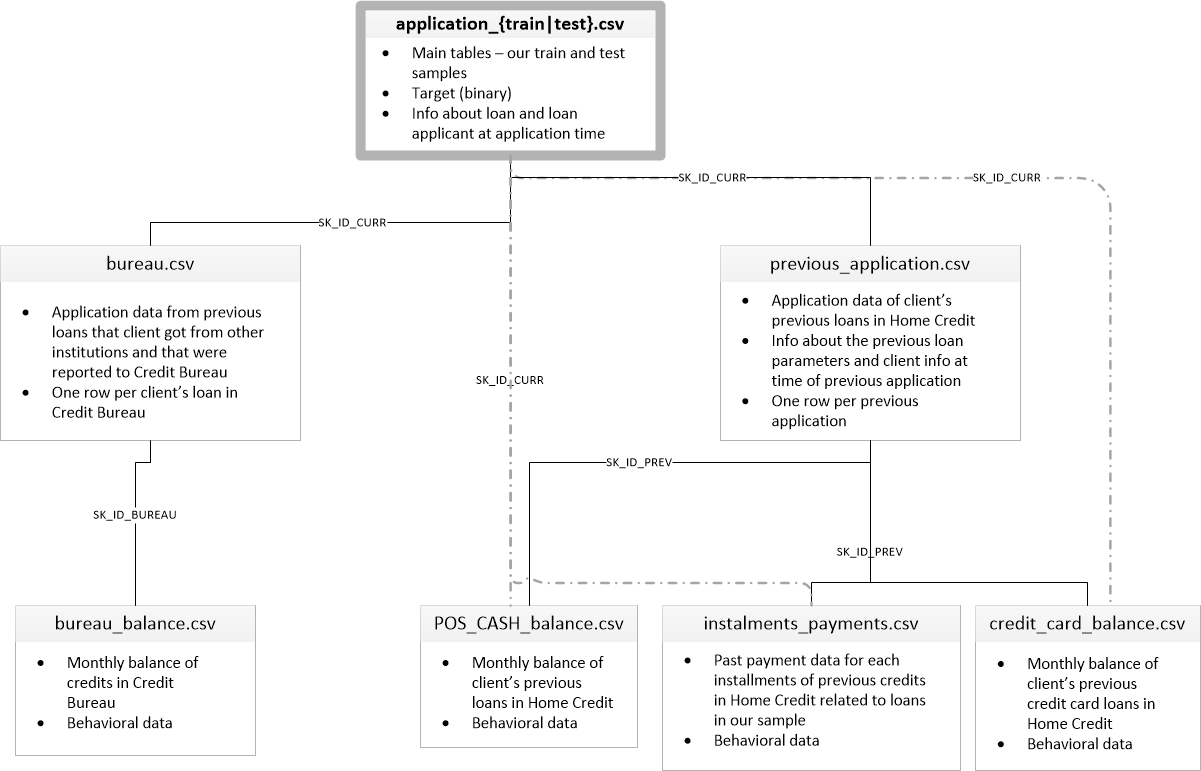

In [4]:
# View files relationship
base64_data="iVBORw0KGgoAAAANSUhEUgAABLEAAAMDCAIAAADSeBDzAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7P29s11HdqcJc8zxxp42JfhypYA3jpyuCf4DLUXAGGci1AZMRYgO2pqWxqAnlYW4oPilBkh2kaDYgYAECYwrMgihKaEpqqiaVoCDIt6gAn0pjtiBmXofnN/GqkTu83G/zvfzGIe5Vq5cmTvPydz5O/tc8KVfiIichP/+3//7/09E1s0///M/D2tSRETkbKgJReS4/Mu//Mtf/uVfvisim8GHH3747bffDutTRETktKgJReRYIAg/+OCD4SgqIhvD//1//9/DKhURETkVakIRORY+IRTZTD788MN/+Zd/GRaqiIjIyVETishi/vt//+/D8VNENg8fFYqIyFlQE4rIYn7+858PZ08R2Ty++OKLYa2KiIicHDWhiCzmv/7X/zqcPUVk81ATiojIWVATishi1IQim4yaUEREzoKaUEQWoyYU2WTUhCIichbUhCKyGDWhyCajJhQRkbOgJhSRxczXhB9++OH/JSLL5D/9p/80rLdpqAlFROQsqAlFZDHzNeG9e/f+RUSWCapvWG/TUBOKiMhZUBOKyGIWasL/R0SWiZpQRESWh5pQRBajJhRZL2pCERFZHmpCEVmMmlBkvagJRURkeagJRWQxO6wJ/+Ef/uEv//IveR3s3WJzrm4tI9mcyz87akIREVkeakIRWcxCTfj91vKjH/3opZde4jXmN9988xd/8Re8xjxHlpd5Fj/+8Y+5tPbqzgsu5KuvvhqM4/Hbv/3byxjJfPLmwh/8wR8Mrq1FTSgiIstDTSgii9kfTfirv/qrrXmOLC/zLJ6JoZdeot/zVUT/9t/+22Qe7OPRzfNq4MIz7Scd7QaiJhQRkeWhJhSRxeyPJox+OLt0+YsJ7VPB88p8TP76r/86PTKMwTVtVKcgMwaDfTy6eS7OZUhhaio8GS0TMri2EzWhiIgsDzWhiCxmfzThj3/8Y8pvvvlmzFMTHdI+oDuvzMektBCFwTVtVKeAhFzIK6+8MtjHo5vn4lyGFKammjoP24iaUEREloeaUEQWs1AT/vPyufOcwX4OvZcz5Z///OcxA54a4bP2L2YorRLzpz/9KQG8xgwkHDeEBEMbn+DokN/5nd+p2qmZ4Vn7CYP9nIXXNR/iM4Zc+6xRxZ8ykQkOGXDVFmlSkW2Grqqlm2eYNaSCPLOyZWwVPydV+SnEM4t0140BcLZtY9LjYD/vHQZ7OagJRURkeagJRWQx69WEv/Vbv5VjffHGG28Mdf/8z/EwhvrLMagATuqYSBE8qQo15k6rjKXLK6+8MmkxkMwffPBB2x3QJDrh93//9wfXc5JtnHkciWeoe35dXUfthc+HhmkSc9ao4ucaMzzAOefqqgm0JhkQY/FDGx+SP52GWUOCbgCU6/2i8Bu/8RtDxYtX0VKpGEY8czRb9+Gh7dS3klHhTJmLnTR9Rn1CBns5qAlFRGR5qAlFZDHr1YQ5cHNShzq71/OcmIGAofRcA0QTBtq2ATn3x8PrJFlv1nG/2qYqaiHO+CE6AeVQngQQjD9OXp/lbfRGN6of//jHCRjsCW1Ap7WmwlVHOFV3s0bVyh6aUFXOqVfXNulMSIaUk79IHl4He/aQ6i2LsxLmHa8mVUX8rFQhYTinflBJm4bQ5qxhcFFJzivxJX3THNKkVYnLQE0oIiLLQ00oIotZqAm/Wybvv/8+Qohe/vzP/5xyTuSUUxvz13/914nBxB/P7/3e77UmR/ZJ+HelYUiFWcf91LYmCSeBL/3Wb/1WahkDzVMAAsgPeZJZSSANExzmZ8bzK7/yK3h4jScBdV2vv/56PHSXgDkkkr7Stoi/HVXNRuucf3XVpDMZYTy5kHY2oL38lknTF3qv7tI7JOaP/uiPqE05by7Q8O///u9TTlWbKnAt6R0GVwOpUkVYechZ15U5pDYDqE9gPj9EtubyUBOKiMjyUBOKyGLWqwlLDrXU0b8zodUkpSgopLYO8WnSaZXWHLct0AmJ7Biqp41qYeYSITFTrgxzBjOmxlY6LcTZjqrrNMy/uq7JOEN7pcVUJ0yavjCkeMYkph7T8S4j0lrRG3+bKpSKG/cOswZWnxOg03bay0mZMcRM1fJQE4qIyPJQE4rIYtaoCUsLAQf3nOChjv6dCYnhlfJUKRVPmrTBnTm1bUgY/Pqv/zrlqFAYqk81KoLjjJlyZZgzmKl02UI87aimhs2/uq7JOEN7pcVUJ0yavjCkeOiU4JZ6EFc9hvr4xWxThYy/HhR3kJlaXge7gcypDZWhHi1SZoraquWhJhQRkeWhJhSRxaxRE5YAqCdCMevoH7N+TEhYPDmml5QqRVFPjfIMrZMErVlt26dt+aVi/O0vGOOJCTFbfbIwMwOOM2bKleGkmrDiB3tCPO2oxiOHeGZd3XwT2istpjph0vSFIcXTqaxMe1uo97EiY7apQvztvFGuD20Ghm6MCXyEoO2x3po4aRuzHhLWp2t5qAlFRGR5qAlFZDGboAmRTxzlc4KHOvrHBDwE5K/RIHKrpBHg4eyeBzuQ832nVTpzEviM9I42SFWclHGWMIC0gpgMhoAIhi5zPXxL5rrMUmIx6zLrQijEM5+p8fG0o6p+ExDimXV1XZNxhu5Kw1QnTJq+MKQSYGTGCXkuRyHxBFAmuHsA+KzNi6mAdzn+NIe6onxuy0xD3g7SUqB3Cnl3MgAooVhvH1COc6moCUVEZHmoCUVkMWvUhHWm7+DInoDBfpHSHhzoB9eLVPNOq3QmkmAS/ktQDvhLJHSkFSRPSLYuM6IltS31L8pAPDXOuhAK8cxnavx4VOSPmYAw/+q6JuMM3ZWGqU6IP6SWGWgVVxE9NhgN3RO/UB2N56EGHA/d1dcEBTlbMRxKfEI7RZQH7zJRE4qIyPJQE4rIYhZqwqNl8tlnn3Ec/9f/+l//m3/zb37yk5/8+3//7ylTSG3O5TjRb/jhD//wD1MFf/Znf5aAapgkQ/XRUZy8TjWBDOkdyPzo0aP4KceJJGCEFMicKiAMfwLIgGec+csvv4wTaMv4h4oJePDXUAlOJH3FM5+68PQexqMiP+V25GHO1XVNxhlyUTQc7Al4GAyvg/2c8ZDiZACZAV7baWceKp4CZvwwNdV4HupyKme6S0Pe64rkHakxdO9OvR3QjmF5qAlFRGR5qAlFZDHr1YTzyYm/1VotY0mwJ6BzcuHMzGpEy3zQTgyG18FeCVw4l595KAW4pagJRURkeagJRWQxasKNAqnD5cyiFGBkGKxYiU1lLZpwo2bgjKgJRURkeagJRWQxasKNop59TaWm4tGjR/nV66zJWSVr0YRcOD0yCdv+kBDUhCIisjzUhCKymIWa8L+tj/zF13/8j/9xsF/k7/7u76gFCoNr+/njP/7jXNRUqB3iNon8wd7/8X/8H4MtJ0RNKCIiy0NNKCKL2WRNKLIPqAlFRGR5qAlFZDFqQpH1oiYUEZHloSYUkcUs1IRPRGSZqAlFRGR5qAlFZDFqQpH1oiYUEZHloSYUkcUs1IRDnIgsBzWhiIgsDzWhiCxGTSiyXtSEIiKyPNSEIrIYNaHIelETiojI8lATishi1IQi60VNKCIiy0NNKCKLUROKrBc1oYiILA81oYgsRk0osl7UhCIisjzUhCKyGDWhyHpRE4qIyPJQE4rIYtSEIutFTSgiIstDTSgii1ETnhcvv/zyrVu3BqOBMz1VX3/99WDLcrh06dLU+d981IQiIrI81IQispjt0oSvvvoq+urq1auD3YAeoOrKlSuDPYPLly+TZDDOlZdeemlq5k8++YQqXgd7D+BiVy+DZ83/5qMmFBGR5aEmFJHFbJcmRGlcuHCB0//R0dHgek78MNgzIIAkg3EMEDbEH+dcTuYd04THv/YORPvqL3nq/J/6EsKlS5du3LgxGEtDTSgiIstDTSgii9k6TXjlyhVO/92jwlu3buFM1eCaASfsEz2/Or6im6pJYHs14alHjmJf/fVOnf8zTv6s9/R8UROKiMjyUBOKyGKWoQmRBMgz9Nvly5fP9weE5OSMTtoLFy4MrgmXLl3Kj0I5xA+uydMq4qEVkAysTvlUceBOGBnGh2+k5sWLF8nJKzH1yGhq5ugHYvCTrXRIJ0uYHMLSvH0GRQCtOudJIQnzQBJStX9ch6cz0wuXTJn3KF2nNky9dgp0kTc308VreuS1JrDSVrn9SIyf8YZZ7xddM5iMsL2Kmsl0nfkf6iZMvQSg8KybyWepBsNocyFxYlKmLZ80CgwjYcuAwQ/rbRo1qyIiIqdATSgii1mGJsxBvDhHWZgjewRAnZXJj4lWoYpCnEgIjvg4EQY460xPBkgZPyd+IiOlMDu5gok+wc8rMamdlZkyJFtGQgE/r1UmA5OTGJQJ/jTPJaSX1D7LeEKSkK5pngHwmqq2DGUSSZlJoOuSTGHqtSeYy+faGTNvASYNCcgE5r1OWl6rTFgGFnn2rIMXmTWrBNOWVvgznqQFmsTPAIihqr1GmHoJ9JJWQAESnOsijCTJQ5m2cZ7jZ3iMmlBERJaHmlBEFnPumjDKpKU7qZ8FFEKy5QQfJx7MFOguzvYQj790CIUqE1xJEAyYnS6CCANeB3t2ZsJQKSkDYiNmmwFxUiIEkCVUUUhMnBD1clLIkMkJ7Wx0VWWm37aqpR15wKzrBcbZDrWC24Yp18TmkscSa877lTc3MHt5y/K9ANnijzm+kHYkkLAaM4WqbcMqYGrOc0dNKCIiy0NNKCKLOXdNyBmak3TLOZ6qUQjJluc/ObujGTAppOtncZNjPU7iIyrKH0/K3dimDrUTFTArc9f8yuSnkhTaDHgoT5o+A4WDSUIUUfxjUQoJHtMGj8fZeihMvdJxq5ZxbZcHqEWkZTxT03ZJOrM4zvsFZearhzgDZjc26LojADNJAmaEJe9FPkj5UIWpOc8dNaGIiCyPF26WIiJTOXdNGHnTMlXnnA4O8TmjpxcyRxvkHJ8T/yTw2REfOO6jBxAt5Y8SSBlne+LvzDDWMLMyd80pp6M2Ax7aUm6ZhD+7omRDmXQyYIgb0T5bw+zG2Xq6sZU5btUyru3y5KEfHmISPE7blsdmMWtWJ2/XFE1IRxUTMNuxha73tMJsyYeHV2ojR+sTOzXnuaMmFBGR5fHCzVJEZCrL+HvC6LRQfxh2LqAH6oyePyfDg4SIJyd+Chz0KfDa+WGiKU6gCTmRt6nmZO6aM7x01DZhqIx5Uj8dlAmypP0N6jGJSM4jrxDBFt3Yja3M7nI6umuHLk87mTA1bddFZ4bOSRLMlLsuyszVLXym111C+w3CLJj86n1qznNHTSgiIstjuKWJiMxhGZoQOHZzEG8fZJ0L6IE6o0cVwFhLRAlEIDESZFj8UKICcLYn/s4s8NeDozmZKUBO8AlLq1bwpJzmwPykRyLr6E/OU2hCyKVF8GRsdaVtzjyFS7/t2KZSVxGqYSAnmVOO3Bqn7brozHDM9wvKJIyYGkx7UR346xLSqr6nwEyZAVQMnrb3+sZhedD7sN6mUR8MERGRUzDc0kRE5rAkTbgkOKO3537O7heaf4CEqjrNRyQQz2vK8T+TFCfUhHlwRKvUzspMIXKiquLvVFAGGcFGIVIkMXi4HDidDKAVbZMnr2ieVCU/nRLAIKnKtXRjG9NdO+V2iugRDznJHMZpuy46szjO+wWtGRVKp91FdXSXkK8SaIKHQjQh4jzjB5ylD69O/myVyFLUy0BNKCIiy0NNKCKL2S5NyPm4ffbYmZTbAzQm2gNdBOVvm6Q2ZcBss7XQqpUxUzOXp8sTz2BMiKdzwlTnSclQxxfSDqwmYTy2Me21U6BJygXOTAKvqW3Tdl3EHCeBqbNaQw2YVQVE0qS7qDFUtWMATKD5YE9IWOesUQ32EqDfYb1No71eERGRk6ImFJHFbJcmFNk91IQiIrI81IQishg1och6UROKiMjyUBOKyGLUhCLrRU0oIiLLQ00oIotRE4qsFzWhiIgsDzWhiCxGTSiyXtSEIiKyPNSEIrIYNaHIelETiojI8lATishi1IQi60VNKCIiy0NNKCKLURPO4saNG0v9P5WLBDWhiIgsDzWhiCxGTTiLV1999aWX3Ehl6agJRURkeXiUEZHFqAlnoSaU1aAmFBGR5eFRRkQWoyachZpQVoOaUERElodHGRFZzHZpwk8++eTSpUsvv/zyjRs3BtcvfnHr1q04r1y5cnR0FCcBmJynL1++TNXVq1dxVnOaJIwATFqhACkQXEfwThNWW2K+/vrrwTvpCCdVBAwukZOgJhQRkeWhJhSRxWyRJkSJIdJQd5Fn0WCY0XiYFyckOIoOkypiKNMkJloRM0dtWiWM+KTFjLBsNSHCjzKvFRNZGD85oboWORFqQhERWR5qQhFZzBZpwui3wfjFL6Lc2kd2bUAUXdWiGy9cuFBPEakigEKa5CkiEFBmqwkpoPpShmhICrySOc5KLnIi1IQiIrI81IQispite06IBrvR/HAUMC9NftWJVCMAmYezVXRALQzGxGw1YZqEqqoMiSH5JMczMK9cuUIVQpHy5cuX2wwiJ0JNKCIiy0NNKCKL2a6/J0QWIsCQYRcuXMhZOT8Eza868xvRyLNz14Qkp1DUE0jK+TUpDX1UKKdATSgiIstDTSgii9kuTRiQXmhClBhlxFgkHCDPSuCdWhNWwsqQ55Ptb0fHcHAnpn6DKnJ81IQiIrI81IQispgt0oQ3btyo8/HFixdLE+ZnnJBHiKfQhGTLI748acwzwDZDmtdjQMIyEmLi5JVgNaGcAjWhiIgsDzWhiCxm6/6NGbTZhQk5K+df/kTU4Tm1JkxDnLzWHyu2Gegrf6xIDB3x2mrINCynyIlQE4qIyPJQE4rIYrbut6OouKi+AiWGJw/3qgqzPUx3JuWKR86lOa+tqOuaAGZ1VKT3LlLk+PDhGdbbNPxoiYjIWVATishitvHvCc+R0oSDLbJy1IQiIrI81IQishg1oZpQ1ouaUEREloeaUEQWs+eaML/8HAyRdaAmFBGR5aEmFJHF7LkmFFk7akIREVkeakIRWYyaUGS9qAlFRGR5qAlFZDFqQpH1oiYUEZHloSYUkcWoCUXWi5pQRESWh5pQRBajJjwLR0dH+X/fwyeffHL16tWUV8/XX39dI5HtQk0oIiLLQ00oIovZIk2I5hmzRhkG9H7hwoWUGcxLL03feG/cuHHr1q3BWBqMhI4GQ7YHNaGIiCwPNaGILGYbNSHi5+WXX0552ZoQLTdHaDGSGgCDmaUJ8TPgwVgaV65cuXjx4mDI9qAmFBGR5aEmFJHFbONvRyMIB2PJ0NcsOcdhHbFXR/Y5mnA1zwnz/9//+uuvB1u2BDWhiIgsDzWhiCxmSZoQCYRGWtJPGadqwvR49erVVhThwUxV+RkVZlF+NFXnyU9DIf44C2pbEUhAzORv/1f4rSakivwc9CmQ4ejoKH6gnLa8lp9gPBQITtqYRZucAWCmLNuCmlBERJaHmlBEFrMMTXj58mXESbh48WIre86FsSacPMx75rx06RKd1jGaMn7GcOXKlTgpA5H4qcUfBciYo/0y+CirVhNSfpaxgb5IMhjPNSHJyUDaJE/Vs8E9j8RPw+TMYOJnGDhpW/7MW57+0ZxW1HIVmCUCAbPGRlh1KtuCmlBERJaHmlBEFnPumjAapmWsps4IygfhNBgTWo2EmqpaekdolSjN2MqkHO3HaxvGgKlK+ZmYm/HbUfyItMF4rgnrMR0FzAjONglOyumLWswMnnKd/qnFnyeNGTOCMFUQ6ZgybamtkbcdybagJhQRkeWhJhSRxZy7Jow0aun029lB9oxzoo5wApKpFFTX+yxNWA/uAoqrwuaorG4YlGk1GM/1XnRdmwRn26o16ZHxYAL+aOmMOXlCalNmqK1cbDuSbUFNKCIiy0NNKCKL2YHnhEipixcvlqijULqI3rtIPHmQSEz9PpNyqwlDmlAFKXfgrzCgTPLBmIB5fE3I0Z9yckL5x5qwni7mcurJJLQdybagJhQRkeWhJhSRxezA3xPmp57VS6uL8LeRyCfGk2dxvFaTSy/+ZWBLm60D//i3o4Nx8ueEjIGxxQnlH2tCIBvxXAJV7fS2Hcm2oCYUEZHloSYUkcUsQxNCfsnZPsI6R5A9rayijDRKGYE05zlhIq9cuUIBSmhFXKHiYkL+xg8Ia6VaS6ckiSRJXXKrVJ8JtUWasI3JM8P4p2rCDJj4VpTC2CObj5pQRESWh5pQRBazJE24VFA+razKE7k4EYRIuBJXpawCCg1PNCGvCU4VTaoKf/3rnVFfmGOtRSRVgzExaQhEEk9V6UOSzxpSmfnXYtI2eeKfqglzIVDaNeA591/qyrJRE4qIyPJQE4rIYrZRE6K1Oo2ELEQLIaI4QFPVPuVrj9SYpc0gcqsC8myzawKE4SyBVxDWNieMGNRajSR+wD9nSHUt+DFpzuXQJGGUceZ5Y8ulyf91YzAm5HLap52yFfBGD+ttGu2nRURE5KSoCUVkMduoCU8NgrB93IfuQkSN5dbxuXDhwrqey9F1PcwMmLN+5iqbjJpQRESWh5pQRBazV5oQ/YYIRBa++vx/OHFGRUdztNlgrJD80LRTC4xk/DBTNh81oYiILA81oYgsZq80IXDCRsjVTzQH72k5Ojqa+sPOZfPJJ590ajY/MR0M2SrUhCIisjzUhCKymH3ThCKbhppQRESWh5pQRBajJhRZL2pCERFZHmpCEVmMmlBkvagJRURkeagJRWQxakKR9aImFBGR5aEmFJHF7KomPDo6+uSTT85+nv76669Xdiino83/vwsyyPG/qbPKWdo9mLphvU3DiRURkbOgJhSRxWyXJjymaiLmpZdeunjx4tn/RxGvvvoqqQZjybw8YTA2FWZj/A+crnKWdg81oYiILA9vzyKymO3ShEim4/wfF87xfxt47mpnjqxVE+4nakIREVke3p5FZDE7qQmJOS9xde5qZ6qmChNJqCbcO9SEIiKyPLw9i8hilqQJ8+d85/7XcUimEiT1wI0CfcUJlC9O6AaQsPlDSkz793KldmjYVYX4u4N7F1n9UiDb5cuXx01grAlnjTmdtv5MeBXGTVoISHBBR2mSHuMs2pzH1IRpMk4FY//83ncernpYb9OgdogTERE5OWpCEVnMMjThjRs3UAjhypUrg/c8aDUhZcRV5N+FCxd4jQzDn64rmFM1AZCqS5cuJbKFmKRKDJcQf9QOV5Eu2iqSJDiv1NbxHbMVTjGRPYnMSNqAgBNSnjVmXimXnxlIPFIK8+rVq7ymqsbZcuvWrQTkWmrAeKZOJqRJ/MRQHo88szQYv/gF05VeaEKBDPGfovd9gHkY1ts0apZEREROgZpQRBZz7poQ5cNxv2WqODkdiIcSJJRJHr2BhKCMIqoqSDlVpZ0yvLGqYZD1hCrKKuWonWoeM4qFLkq98Np22nXRml1VS2WYM2YUQl0mZfwZdjQhzTOejHMS9QL480QO0JbpDigQP57MlGvAx9GEKZeSiT6sUZ2o9z1BTSgiIstDTSgiizl3TRhJ0DKWEKcG8VDZKEPK0JptGbHHGKJJQh76DcaLcP5GXEUTRr3kclILJcOi0+oJGOQhWFpRaK+6Nbuqlhr2wjHTC2MAwiK5U+Y1AZ3ZgR8QeJWzug5lEkaeEnKAOR5/O0vkZLQpQzRe+73A8XvfE9SEIiKyPNSEIrKYc9eE0TMtsyTQKUAqVLZOObRmW27lShh7gJM3EgVoeHHyy0Z0C/5xcKqgYkLrodBedWt2VS017HGn5UFiEUM5wZWtG09nFnl3uEDacrGU40+2lKHM8Ugwx+Nvw8YB5Tlp73uCmlBERJbHC3dxEZGpLOPvCaOpivYp0xlBKpTe6JRDa7blVq6EsQeQKJcuXUq5FVRdcJ56UdXGhNZDocYJrdlVtdSwxyMsTx6v1SPEytaNpzNDnm3WzzLbXqrrUGYemcYZMMfjb1ONA+I5Re97gppQRESWxwt3cRGRqSxDE6JYrly5wrEeAXOOghDIWXpjIhymC4m2zJEa7dGqI6pK/hWtksmvQNMk0qXO5XN+INqKnLYqAygTwdy2aqlhzxlzxUAEarJ1IrAzQ+fMX/ql3KaFMruRdNdS4KlU7R8KQjql4Sl63xOYnGG9TYPaIU5EROTkqAlFZDHL0ITLA6lQgqRTDq3ZloHyhQsXbkz+FRkUSyTKUPccYlBrSD7C8rPGqJeoHcAfQVh/LJcqXolMmZhURfBUNqhhMwBMmlAbTzEZ9S8vgbDxmKsjmud5bDITRjljHpshGpJs+JMHUtV2Da1JL+3MQF1LkWwpp+vLk//fBk1Sxn+63vcBNaGIiCwPNaGILGa7NCFaC5lR5VacYELK+KsMqJGrV69GaeCf+uiyfbbJKZxCwugOPx7EDM766WOgNv5IoME7ycYY4icPGWrYmDjHqYCwuqI5Y46fftFpVEVbtmMucywn8KR3GjJgksTfdg2YkHI7M921FJmHwZjIwvSCsw0+Re/7ANMyrLdpjN9EERGR46MmFJHFbJcmFNk91IQiIrI81IQishg1och6UROKiMjyUBOKyGLUhCLrRU0oIiLLQ00oIotRE4qsFzWhiIgsDzWhiCxGTSiyXtSEIiKyPNSEIrIYNaHIelETiojI8lATishi1IQi60VNKCIiy0NNKCKL2VtN+PXXX+/tafuTTz45OjoaDFk3akIREVkeakIRWczeasJXX331pZeGfZJjd/s/hd95uPD6f8Sflz5c6hzutohVE4qIyPJQE4rIYtSEQOHll19O+bw4xXNIZA/iZzCWSWlCRtjqwxPRicDzncNWBJ5lkFsBFzist2mc9FMkIiLSoiYUkcWoCeHy5cvnLjkQSCfVSO2QlkpJLHQXg7x161b8J6LTaec4hwhCkpc8PssgtwI1oYiILA81oYgsZus0YR6mdQfleqzUVSW4Cu1zrVaA0aT73SPBadgydlZDCm0V5sUJ4yZFV0UeZFW0EORyOtJLW0UrnCl0VbPGBq2c61plopKzSPJkC5gkYcAVXN0VadWlwpPuxlWB2qtXr5KcV2KSs1pleFWIE9JXmQVdVJKNhUEO620aU2dJRETkmKgJRWQx26UJI+RefvnlCxcuoLhKA0RC4KSKclWhBzBv3LhRVciYNGk1IVWQ8q1bt5IBaBU5EScxOCnUMR0PCSuY1/R76dIlwtKEcoKLqdkYDxnih07GEDPp5CJVxHBF8dMKz5UrV9J7WxU/r/iTuYZNuTRhW86c0IR4XvFwOYw/JlWZPcYWM/40pwDPskxaUU4qXhlA13VV1dtRMDm5kFxsHg+mFYW8oXmvE0ZALh8wq6OMAWc6Iib+DYQxD+ttGnVFIiIip0BNKCKL2S5NyMk+ootXjvslZjj0lx6ginIrIRAPaRWTV8pRJhQA2QAU2raAvkpOPCXS0EgJBgrER7ekLXKlqiqsY1a2dkgdjCTDhjxGSzlNOqGbiyUt5VYiVkf4iezK7eRARBSXX1dEuQ1ok0Cbn0LNOa9tFa144zKr6THllm4kUH2liklLcgqYdflkrjI9Vjkjr6nYNBjesN6mMZ4fERGR46MmFJHFbOlvRwHVUYf+0gwBf0RIJASv8UMpSV6pinOiWZ7FIxtwRm+MmXT7CclJEk81DK3ZlqcyztYOaSrIA5pEE0ZVdk1wYhJDuRtALi1lCjVdVWYkTGmcHaSdDPbZZJayapNAdZcxRCcHyngy4K5VZ4Z0xOtgN2FdFU7MlCHPRSlkDEwUkYFLG3e0IagJRURkecw7WIiIhK17TshZP/Ijhfgptyd+yqlCDFDFa/yAP5GtnHiWbhLfOlsiqNAVhCHhxg1Da7bljlnZZvUOCAMigSY0JCwXNW5SVZP+fzmATEXKFDIJbbmLD3nKR0xqpzYMCaAwnvPW07XqzDDOUGFdFU7MlAGzHUNmuKgHnpuGmlBERJbH9IOFiEjLFmnCSKk6Iuegn3JphlDPi8bqop4XtXKiUnUaI9RDp5hTG4bWbMstc7JN7T2gBi89/7vE9qK6Jki4quoGkId1KVOgYVfu4kMeY9aD06kNQzUfz3nr6Vp1ZhhnqLCuCidmyoA5awybjJpQRESWx/SDhYhIyxZpwk4A5ClQyvhLMgEyBjFDIdqgBFj0WH792GabyJlnqSKc2lN4fqqKswRGnlWmXA1Da5Yu7ZiTrZVtHfgjiiBhyZCrqAFHNudXmvTeyrn2R6pttiq3I4E0nFzQcBURnNWw1HVoI9swoFyZu6rODOmopggqrJu9NjNgzhoDOWEwNgw1oYiILI/pBwsRkZYt0oTRAxz0KeQfF2kFAOCkCvFDObooTSCtkDGQJq2cmMiZIVVi0F1AgVaRKEmeVlMbQmsiRAkjSSRoMScbp3/KOGmV8RekzajIhrQjjOb4kwEPfmopI+2qCWZa1WBSRZmGXTmCOQOLtsSZ/ElOqrYhkfRLcNJOLn249rTita6xJqHNAJ1Z4M9IIGbCMCnHCUmeMmBOHUMmbWPFlZpQRESWxy9vkyIis9iuvydEfiAVOPcjcjjoRydATv9AFZqwjtGRELTCSRV6qR4W0ZxUKeOvVAQkD7WlZEhYGcg5tSFgQsqVh4bxFLOyAT2m604Tko3gZKM5hQTQBReIhyY464koYALXziu1UW4h/nGZnBkYr6W7yFkZGMM4OJ1S1U5FprdLBW13gFmT3JJpoTZtq1V77YATM2UgVc0/UDt1DJsGFzWst2lQO8SJiIicHDWhiCxmuzThLKIJB6MBJUDVJuuBMxJNOBgvghZq9ZJsLGpCERFZHmpCEVmMmnCrURPuAGpCERFZHmpCEVnMbmhCxE/7i8SC8zRV3e8wd4n8RHMwXqT7MadsLGpCERFZHmpCEVnMbmhCke1FTSgiIstDTSgii1ETiqwXNaGIiCwPNaGILEZNKLJe1IQiIrI81IQishg1och6UROKiMjyUBOKyGLUhCLrRU0oIiLLQ00oIotRE4qsFzWhiIgsDzWhiCxGTSiyXtSEIiKyPNSEIrIYNaHIelETiojI8lATishi5mvC27dvcyQVkeXxl3/5l8N6mwYBw1oVERE5OWpCEVnMfE0oIutFTSgiImdBTSgii1ETimwyakIRETkLakIRWYyaUGSTUROKiMhZUBOKyGLUhLvE9evXX3vttbfeemuwZftRE4qIyFlQE4rIYh4+fDicPWX7+eM//uODCYMt24+aUEREzoKaUEQWc3R0NJw9Zfu5du2amnDH+NnPfjasVRERkZOjJhSRY/Hhhx8Ox0/ZctSEu8fR0dGwUEVERE6OmlBEjsXPf/7z4fgpW46acMe4f//+sEpFREROhZpQRI7Lf/2v//WDDz4YzqGytagJd4l79+79v//v/zssURERkVOhJhSRE/Av//IvP/vZz76Qbab+jZnBlu3kyy+/fPLkybAyRUREzoCaUERkv3jjjTeiCQdbRERE9hs1oYjIfqEmFBERkRY1oYjIfvHee+8hCF977bXBFhERkf1GTSgisnf85m/+5rfffjsYIiIist+oCUVE9o6XXnLzFxERkQGPBSIie4eaUERERAqPBSIie4eaUERERAqPBSIie4eaUERERAqPBSIi+8XR0dHv/u7v3r59+4cffhhcIiIisseoCUVE9ouPPvoo/3/CBw8eDC4RERHZY9SEIiL7xcOHD//wD//wP/yH//Ddd98NLhEREdlj1IQiInuHf08oIiIihccCEZG9Q024z9y6devVV1/95JNPYn7xxRc3btwYl8fQMK2+/vprMgScqZ3D0dERadtg8rQdkbDMREIbQHycV69eJdvgFdkG+HjzuW0/upRxjssdxPOZT7nWxZz4FtZyF4zZNiRhTF4niZ/RBgyuZq+Q3cZjgYjI3qEm3FuuXLly8eJFznkvv/wy50U8KVPgOMgHY875jzCCKfB64cIFXlMg4RydRlpiLl26RDAZGADOlBMAdFomY7h8+TIBpC0nBcBJHgKUhbItZFnxsQcWQpy10HDWh3wMMUSmXOuCV8rtNyZjCKOv6jRKrzoN9BszwbwSXDHpGiekMGkku4zHAhGRvYN7/FD6xS9++OGH2xO+/fbbwSW7Sx0E4YsvvuCV0x5OVBYabP5BM6qMQprECZQ5pw7GiKjBwZg8bOS1y8CQyqxTKUOiHPlXXQPjPM7DSZFNoP1sZ8VBPuQst/nfpxBTe3WtC4i/fabXQi+1cGIu1IQ1wshICm3XLDfGmbLsMGpCEZG9o2728Pjx4/wzpPDRRx89ePDg0aNHp/jnZ2g15kR5CB6avchQfTyGNi/iMAI5OfBxvGuPhjkRdsptKiXM2kMkcGSsByBjph5euwyMp8w6uUYTxlldQ8af+Ymn4+nTp0OpAWcmoeP7778fIo7BkydPhmYNrKCh+hg4jJZ9GEaeE/LpbbUfnqtXr/I6RxBCK8wotMuWVTDrGxz6mvodTZeBNRWzXYzsD1lobdcs8Ha1HodzfFNO9C7IWVATiojsF/fv30f+/bt/9++45cte8corr/AB4MyHhOOQV88JMamthxizKGHWHiKhPT6OmVo1zlAm8fmNXH7PFie1kFaAh2shUlbJr/3ar+XtgGwjU3n33Xc50A9xExL805/+dLAncNb/kz/5kzQZMzV4VuapbMgwWFaQ3zzX55kyH2+cMWfRriwKkXAhy2EwXgT/1KpxhpgEZ62x7ijkG5x0jROViDNP5v/bf/tvz1o+h9l48803b968OdjPuXfv3nDxI2YFP3z4cLAnJHOaBKb9o48+Yhiff/45tUOcnCtqQhGR/eKdd97hFnvt2rXBnvDkyZPDw8Pr16/nBlx0d19icPI62BOISfBUZgVPzTwLh9Fy6mFwch2qf/GLnP8ocOzjdHj16tX5P2ODOoamSZww/6dlnCzHabsMHEDLJJ6x5SRaMpVaoBXOPB6pU3g3G7dv38bZzca3336b4KlwKh3iJiT4j//4j3/44YfBNSGZpzIreGrmWWz+MHhrBq+zcexhoGESw4eZCcynl0Kers//tXaEWcoUWkXHiotOG8Myye8/O7oMLKiYWVa8krMapmucCFcis4S/+eab1IbHk9+YIN46hczAcu1jZgXXLIVknsWnn346xMm5oiYUEdkvpmrCov3JIgegwfscTkL4u/MQEJkmY6YGz8o8lVnBDiMcfxi8uXUozJmPAsc+znwUUGIwqZxOVBmFahLm/+6Ug2ZbG5mXA3E8wEm0uq6Ta9tLdZ1hc0LNB/Uss1F0h1Qg+MmTJ4PxnDlvyqzgqZnTZMzmDyMfmOBstMwZxn/+z/+5vhOpj3E+5KyF9ouPMbVIodYFRF7O+gaHxdXWUsijP1ZiSVCcxMRfCy3O9NJ2XcP+//6//y+eAvE2no3vv/9+uPgRs4LH80zmNPm7v/u7+/fvI84/eg7OIWgCk4+kZEMYbDktakIRkf1iviaU3YZzHuqLEx6H0TwTaE+EnBrzj5FOpY6Gac5rCrSqA+iYnF/TKRnqQQStkpCqOp5CnUrbE2p13ZVllfB2DCU5NiyoLJb2c14fbEQatbOWTyvMKGQRJc/8B4zEpFOWG4V0Gq2IBz/OWomYrKmu3Had8pw1vl7u3r3LHe327duDLafF5S0isl+oCfcZDnYcUjn55UgKaLY6X1KmKuUxnCnTiiMmYaHyzKE6JcPgmkC/OKlqj5uYpQ+rxypAO2BZJSUS5ETw0e0+5+2HnPKsRUQ8DVPOYgEK1XYO1WkbXCu37bFdUNVj2zV0eTaKf/zHf/yTP/mT7i8/5RS4vEVE9gs1ocwnp8mOoW42ddxs2dhzpJwCNeHyGBZMwyyh2FJCsfDrEjk1Lm8Rkf1CTSjzURPKVNSEy2NYMA1qwlPz9OnTv/u7v/vZz3422HI8XN4iIvuFmlBEToGaULaChw8fco+Du3fvjv/1GpmFy1tEZL947733uFm+9tprgy0icgzUhLIVfN/8Pydv3rz5w+hfIZapuLxFRPaLhw8f/uEf/uHHH3882CIix0BNKNsCshA1GFn4k5/8RFl4HFzeIiJ7h2c7ETkp7huyRTx9+jT/mwro/sVjmYrLW0Rk7/BsJyInxX1Dto7bt29HFn766aeDS2bg8hYR2Ts824nISXHfkK3j6dOnP/nJTyILHz16NHhlGi5vEZG9w7OdiJwU9w3ZRr777rvr16+jCb/99tvBJdNweYuI7B2e7UTkpLhvyJby9OnT77//fjBkBi5vEZH94v79+wcHB++///5gi4gcAzWhyA7j8hYR2S/yN/dvvfXWYIuIHAM1ocgO4/IWEdk7fvM3f/Po6GgwRESOgZpQZIdxeYuI7B2e7UTkpLhvyA5wd8LTp08HW57j8hYR2Ts824nISXHfkG3nu+++e/Z/pTg4oDC45DkubxGRvcOznYicFPcN2QF+9rOf/fSnPx0MaXB5i4jsHZ7tROSkuG+I7DAubxGR/eLo6Oh3f/d3v/rqq8EWETkGakKRHcblLSKyX3z44YcHBwevv/76YIuIHAM1ocgO4/IWEdkv3nnnHTThtWvXBltE5BioCUV2GJe3iMh+oSYUkVOgJpSd4f79+w8ePBgMmeDyFhHZL9SEInIK1ISyG3z77bfcBOHx48eDS9SEIiL7hppQRE6BmlB2gydPnkQT+j+laHF5i4jsF2pCETkFakLZDX744YdoQn8+2uLyFhHZL9SEInIK1ISyM7z55pvcB+/duzfYoiYUEdk31IQicgrUhLIzvPvuu9wH7969O9iiJhQR2Tdu377NvfCtt94abBGRY6AmlJ3h+vXrasIOl7eIyN7xm7/5m0dHR4MhInIM1ISyM6gJx7i8RUT2Ds92InJS3DdkZ1ATjnF5i4jsHZ7tROSkuG/IzoAaRBP6b8y0uLxFRPYOz3YiclLcN2SX8H9Y3+HyFhHZOzzbichJcd8Q2WFc3iIi+8XR0dHv/u7vfvXVV4MtInIM1IQiO4zLW0Rkv/joo48ODg7eeOONwRYROQZqQpEdxuUtIrJfPHz48A//8A8//vjjwRYROQZqQpEdxuUtIrJ3eLYTkZPiviE7w7fffnt4eMjrYIuaUGSruXXr1quvvvrJJ5/EPDo6whyXx9Awrb7++mvCAs7Uzied3rhxI//Tc/JQThWQsEwKydwGEB/n1atX/d+mrwvPdiJyUtw3ZGe4ffv2wcEBsnCwRU0osr1cuXLl4sWLiKuXX34ZfYUHuVX37FSlPIYmqeX1woULvKZAq/k6jYbJfPnyZQp4KONMLTCGMhkMYQQQWU4KgPPSpUsEKAvXgmc7ETkp7huyMzx8+PDWrVv+7yhaXN4i2wrKKs/64IsvvuC1NCFKDCY104kqo9ApOspzGqI82+A8V5yvCTNChF/JP2rTNaAVj/lwUs4Xz3YiclLcN0R2GJe3yLaS54QlCyGasFNuUylh1ik6FNqFCxcGYwSR7a9Aw/E1YZzVNXTjl5Xh2U5ETor7hsgO4/Leen7t136NbVr2kFdeeQVxhYRDZbXPCfHkp6RzKGE2VnRkGIwRRI4l3HxNeHny29H8PDVOaiGtIE6u5dklyUr4X//X//Xg4OD999/P5IuIHAd2j6EkIjuHy3vrcY8WdFce7kXRoQ/zmtqpRJVR6BTdrVu38leCUyFy/FPPLsNYE165coXh1XioBVrhHD91lBXwzjvvoAmvXbs22CIix8DzhsgO4/Leetyj95Z6ZBcp2BbQWki7Of98S1QZhU7RXbp0Kf6poO7a4Mi87uemxNRfJDKYDLLtpbrOaP03ZlaPmlBEToHnDdklvv/++6EkE1zeW4979N7CW1+/zESJ4SlNCFQh8FIe02pCmvOawnwlSRUBaUv+eqLYOhnA119/HT/laML8PWHK1XVXlpWhJhSRU1D3F5Ft5969e9wHP//888EWNeEO4B69tyC0rl69iqaK1oqnJFbKJc86bk37/xNWnvnk/zrIK10MrudOxtM6MWsA1WMV4IsvvvDno6tHTSgip8DzhuwM169f5z549+7dwRY14Q7gHi1zaCVfMUsoFqdrJduCmlBEToHnDdkZ1IRjXN5bj3u0zEFNKGPUhCJyCjxvyM6gJhzj8t563KNF5ESoCUXkFHjekJ1BTTjG5b31uEeLyIl47733uBe+9tprgy0icgw8b8jOoCYc4/LeetyjReREPHz48M033/z4448HW0TkGHjekJ1BTTjG5b31uEeLiIjIsvG8ITuDmnCMy3vrcY8WERGRZeN5Q3aGmzdvqgk7XN5bj3u0iIiILBvPG7IzPHz48NatW48fPx5sURPuAO7RIiIismw8b4jsMC7vrcc9WkRERJaN5w2RHcblvfW4R4vIibh///7BwcH7778/2CIix8DzhsgO4/LeetyjReRE3L59G0341ltvDbaIyDHwvCGyw7i8tx73aBE5KQ8ePDg6OhoMEZFj4HlDdoknT54MJZng8t563KNFRERk2XjekJ3h8PDw4ODg/v37gy1qwh3APVpERESWjecN2Rnu3r2LJrx3795gi5pwB3CPFhERkWXjeUN2CX872uHy3nrco0VERGTZeN4Q2WFc3luPe7SInIijo6OPPvroq6++GmwRkWPgeUNkh3npH/7hH/5Otpl/9a/+1VCS7eT27dvDchRZCR9++OHBwcHrr78+2CIrwfPGtuN5Y9vxvCFzeImPyL+IyPp49913h+UoshLeeecdNOG1a9cGW2QleN4QWS+eN2QOakKRNeMeLStGTShrwfOGyHrxvFE8evTozp07jx8/HmxBE37xxRf/j4isD/doWTFqQlkLnjdE1ovnjeLmzZvcBw8PDwdb1IQia8c9WlaMmlDWgucNkfXieaO4fv0698G7d+8OtqgJRdaOe7SsGDWhrAXPGyLrxfNGoSYcoyYUWTPu0bJi1ISyFjxviKwXzxuFmnCMmlBkzbhHy4pRE8pa8Lwhsl48bxRqwjEv/Zf/8l++F5H14R4tK+b27dvcC996663BFlkJnjdE1ovnjUJNOEZNKLJm3KNl9Tx48ODo6GgwRFaC5w2R9eJ5o1ATjlETnpWvvvrqL/7iLwZD5OS4R4vIPuB5Y+f55ptvOBHxOtiyYXjeKNSEY9SEZ+UP/uAPXnrpJWWhnBr3aBHZBzxvhB1WTVwaJyLORTG/+uqrv/7rv075HInyHAw5CZ43isPDQzTh/fv3B1vUhGdHTShnxD1aRPYBzxvw4x//uFVNO0anCSlDyufIb//2b5PWc9cp8LzR8uTJk6EkE1568ODBP8sZ+P3f/332pjt37gy2yAlxjxaRfcDzBty7d+9HP/rRBx98MNi7BWchTkSci2K+8sorv/Vbv5XyqfnpT3/aHbHeeOMN5hD/YMux8bwhc1ATnhU1oZwR92hZMUdHRx999NFXX3012CIrwfPGztNpwnMB+UfOwZCz4XlD5qAmPCutJuQ1hRY83bdZrae+AEvh5z//efwBz9gZcKZ2sJ+DZ053U5mVKv5uqN1g4hwMORXu0bJiEIQHBwdvvPHGYIushI09b9y7dy93utz1MOMPcfKaQnc/Jbhzzr9XJklXGyd0ycfBU5vj6cZ8HMYjh+RPOQFdXzjTJJFdv3haTUhtFwDEQJcWMkXjhL/xG7+RUxak60QmoMh4KqaIP92RvMrzmToYiL8yJGHKBc5xww3B84bMQU14VqIJef3VX/3VH/3oR7xictgaqv/5n9v9Edg+Wk+aE88rzV955ZX442ErzDdk5Qe2pHR0iu7GZAB0lG23UtEjZrrIbz8++OADPD/+8Y8TEKil4WDIqXCPlhXz8OHDN9988+OPPx5skZWwsecN7nTA3S03Vu50FOpYn9to/g4wkfETQFg14TVSYf69cnxTzt2W2i4PJJjXmJBbdnnqqBA6OTSL9lqm9khanMmJ2Z5AJo0WzFVdXQJShsxMNay0tMr8dAlz2sEDFCBHlG4SYOEcMuDJ1fwGyTHbU1MHDTnzJAnBNRj8lTwJcabfunxgzHjaGdsoPG/IHNSEZyV7U7spZL+orZlyu/t3O+a4OWTfrD2LKsxqgr/dztLdYJxQE+bG0HaUyAyA1/irOU621JQhe192Rjk17tEisg9ssibM3S1CgleUQN3schuF9s6b29/v/M7vxEwT8sSkata9srspd6Iit/vKk2BeYwINy0OnlEt+cMtuDxJzYNh1REkXdR+PCXWxOSfUeeA4c1VX155PcmntjFWZ+LrGXFT7V4htktBOAhxnDqHikzDjHxNBWNm48ExFeqmrzoylr1YBEtw23zQ8bxSPHj3iI/H48ePBFjTh3/7t334nZyB70/vvvz/Y333353/+53j+6I/+KCZlYlKG1JYnzV9//fWY4dcnDMaEbFKD8SLJQNqY87vr+JVf+ZWuo8DgadVeVPi93/s9/OyGMRP293//9zHldLhHi8g+sLHnjRIJg/38xsrJnnJuowiYVIXubgi5IabJnHtle1PGQ5ngSdRAmyfBdX+H9o4fQdI1PwUkYQZSTo9dTjwcQlI+zlzVkSPBKTOBXcNZtK2gM6GdhGPOYQ0JOHFV846p2UKOYePxdwc2wjhZDcbm4XmjuH379sHBwaeffjrYoiY8O+3eVLQbUFuGbnua1ZxtBWeRzXSonsDG1FZRiL9NDvg7T8usKpJTBeyM2VVD7kClYNkH6z4hp8Y9WkT2gQ3XhIMxIbfO3Fin3kZpwtGfqiI6hAK1c+6VBFS2lLuvX+MkW5WTM9Cw9WTkHAPG3+EuhEGSB8hAnjhjji+2AigQkHJIE16rXM3b4EmOIclU0GM0B6ar7aJNEtpJ4JXywjlsryieNO9YWMWbTtrI+5D3PZ6cndLvZuJ5o/A54Rg14VnpNuiApzagtgzZVsozqzn7TjbQou4o7OOYxMRPZJuhTQ5ddx1zqtjaqEpyeqnvxurelq/TTnEfkg73aBHZB7ZOE+YGN/U2mibP7sEvUmph1r2yzZYyr6kK8wPwdx6UZ0QU9+v2O9w5JEkdMyjzmqq294JauqgyASmHNJk6V20wZUi5g7Z12AAK1QriGYwJ7SSkx5SLdhjdkGBqkzCnCngr8y081LPEVgfmCWSdlzYQzxsyBzXhWWn3ppAbQG1AbRmy45Rn3BzwzHn+xtYJtel0GeZ310EVG9xgzCDfgdX3XjHpPYU45Sy4R4vIPrBFmrD9eeHU2+i4Scese2WbLeV6nBgQSDjbrlMO3R2/SOSck0ORS6t7OmByOSknT3exHDkq4ERz1QZTJk/KLTkytSPvuqCqNaGdhPS4cA7bK4ontR1Ts3XwnkYZlgJnhNHMFCDOzcTzhsxBTXhWsje1yiqe2iwo1xdskK2ktqd2ayvYU3B2XzW1Cdsfu1NuM1Ce0x05iazM2XnbjvIdZ14DtV0GTHZMepn6m3s5Ke7RsmLu379/cHDAsWmwRVbChmvCVgm0siQ6oW6CIUqvu3e3j+lm3SvbbImhr1SFtmsSUm4fSZENT/pt79RAVZdqKjl1kCpmN4YMj1QVEE9pyAzvmHPVVqXfjDxk/GmSx4wh1zgYzxsOxoQ21cI57IYE8dRIGEaVp2Ybn4tazVlm3qz2QjYQzxsyBzXhWcnexBaGkGODyH1iLBF5pZaYbHa1PaW2dpbA1pOcbLtU8coOVXeFbHapiuSDynCc7srMFkZCdrFky1ZIw3JGoLa7YWpxtvc/OTXu0bJi3nnnHTThtWvXBltkJWy4JoTcOnNjLdmDJ1Uxi9xeuekTwO2SVniGuglT75VdNnrBJBI/5Ibb6opkIAwn+dMpkVTR9a/8yq/kMJCbe9twFgRXj7QlAya9tLVAR2SDlEsinmiuEpwyGcjTDTh+CtVd5U8rIB6TIxCtAE/aplwBs+YQD2YNCeLhNWZ6LDPZuC48GU/atk5GC4kP1LYXu7F43pA5qAnPCtsHGxCbGrsGOwLgGeqegydV+aatjUlVq7gCCQmeNPoR21DtbtBW5W5Eoc0wp7tscG02GrLVTsKfxZMcZ9sFtd3w0iOjGmw5G+7RsmLUhLIWNlwTcuPjvpa7WykEQNHhbO+bBfdWDgDU8ko5N9Bi6r1ynI2wuguPb7jkzOmCLmiV5iUyawDdmOdDZHuldFqSCZOpwMxpAepgEPAcf67IzPBSBlpNPVrUOSTTmItKVahW6YsAyu1E5SoS02aG8YR3c5jp7bLl6jKeOGuQ0M0JZIS8Dvam4nmj5cmTJ0NJJrz0N3/zN0cisj7co2XFqAllLWzseeNf/+t/jc4ZjP3mz/7sz5iKf//v//1gj3CuthrPG8Xh4SH3wfv37w+2qAlF1o57tKwYNaGsBTXh5qMm3G08bxTXr1/nPnj37t3BFjWhyNpxj5YVoyaUtaAmXAGPHj1C183is88+G+JmQIyacIfxvFGoCceoCUXWjHu0rBg1oayFjT1v/N7v/d6/+Tf/ZjC2HFQfsm0WXOkQN4M0/8lPfjLYI3ZprvYQzxuFmnCMmlBkzbhHy4pRE8pa8Lwhsl48bxRqwjEvff755/9NRNaHe7SsmPfee4974WuvvTbYIivB84bIevG8UagJx6gJRdaMe7SsmIcPH7755psff/zxYIusBM8bIuvF80ahJhyjJhRZM+7RIrIPeN4QWS+eNwo14Rg1ociacY8WkX3A84bIevG8Udy8eRNNeHh4ONiiJhRZO+7RIrIPeN4QWS+eN4pHjx7duXPn8ePHgy1owv/8n//zExFZH+7RIrIPeN4QWS+eN2QOakKRNeMeLSL7gOcNkfXieUPm8JKfD5H14hqUFXP//v2Dg4P3339/sEVWgnudyHpxDcoc1IQia8Y1KCvm9u3baMK33nprsEVWgnudyHpxDcoc1IQia8Y1KKvnwYMHR0dHgyGyEtzrRNaLa7DlyZMnQ0kmqAlF1oxrUET2Afc6kfXiGiwODw8PDg7u378/2KImFFk7rkER2Qfc60TWi2uwUBOOUROKrBnXoIjsA+51IuvFNdjib0c71IQia8Y1KCL7gHudyHpxDcoc1IQia8Y1KCvm6Ojoo48++uqrrwZbZCW414msF9egzEFNKLJmXIOyYj788MODg4PXX399sEVWgnudyHpxDcoc1IQia8Y1KCvmnXfeQRNeu3ZtsEVWgnudyHpxDcoc1IQia8Y1KCtGTShrwb1OZL24BotHjx7duXPn8ePHgy1qQpG14xqUFaMmlLWwb3vdJ598cnR0NBgbD0P94osvBmOFMEswGHNheF9//fVgnDfb9WadGs8bxc2bN7kPHh4eDraoCUXWjmtQVoyaUNbCVux1qI7zkgcvvfTSq6++SoFsx5Q9C1meLmKoDHgwVsXFixcvXLjA63Hm5+UJKZ+vhCMb135e79Em43mjuH79OvfBu3fvDraoCUXWjmtQVoyaUNbCVux1ly5dQh5cuXJlsM9AacKrV6+eWnJ0IpA8pYvOl+NoQkZyjs8SSUWPx5e4pQnTMHN7OrpZvXHjxolGsr143ijUhGPUhCJrxjUoK0ZNKGth8/e6o6MjtAGCcKE6Og6lW1CDiJnTSY5O/Fy+fPksWmgOx9GEpcrOhTydG4xjUL3zNlG4detW/Kegm9ULFy6g2wdjp/G8UagJx6gJRdaMa1BWjJpQ1sJ57XWIK+TEOf50sEAYXLx4kfxohlZy4MnzsXHX9cSJQvcksIQH8V1VPMlZJHmyBUySoAMruLor0m/rrO5S6OI7athjTYg/VYFIJie/82z942GPyUjaVmTjuugRJ+XB+yJdk9KEgJ+cKcM4P1QMhbYLzHZWee0eCx9n3rYUzxuFmnCMmlBkzbgGZcXcvn2be+Fbb7012CIr4Vz2ugiJcOPGjcF7TiB4ouIo0FGcgBM1gnLIH7+1XcfPK35qqSr5QTnZIkJ4jT/qiybER+QgQi5duhSTqnSNJokZf1JRgGdZJrKKqmpFhpJAmPnBaqpmTVRqqzmv8aOH48/F5ooSED9lPFOHPSbPXYkhkkLEdiazzdaSAdB7ZjXyjEhIALWZEMgvP6kiErr5TxWvc2a1pa6dgHHttuN5o1ATjlETiqwZ16CsngcPHuT4KLIyzr7X5fTfco4Pc0hFwiiKCKr4IdKiNE/MrKAIjFYiQsr4IypaTdjpwzyhotP67SLlNqCShMpP71TVkDL4tjvCMsKMdhL1Au1VpNMKo6omFsGWHmHS+VCGOcMu0gu1MaMP5w8sl0ZtTOY2zdveKyAXW/mZELRcyvhLInZhbf4OusibArO09PbieaNQE45RE4qsGdegiOwDZ9/rOK9zmm8Zi5BTg0goOYF4IHn9fLRTLxFg6XqiU34pk6JaU6bQ6pbEI1ouXrw4qe8hLTEJLjVSSUJ1l44irkKevFFIBl7j78yCPCUpobtGoAm0Kqt6b5k67IK2JbEgei9h4x7D+NJC2zsBmZbMZwYArZivmNCaXVULXSCDx73vBp43CjXhGDWhyJpxDYrIPnD2vQ4BwGm+BRkw1J0Z1AtiINICSF6/aRyrl+q6FSqQhilTiPCIc2p8QIHgJCa11RDaMiSAwnhI5Wm7G5tFl7lNGFWG1qIvpqX81XuYM+xi7CxP22PLLH96SbmSpN9UFVF0FRNas6tq+WLyi1wC+LDVw9KdwfNGcXh4iCa8f//+YAvrws+HyHpxDYrIPnD2vS4P6IpZD9xOQR4MDpJiAsnxRF10KgUn5lSNl79GS5lChEeryrr4kGdx6QuqYVeGat4NCcrTicDOLLrM1TyTXD8KbTuq3sOcYRdjZ3nazC2z/G3vlaR1dnRdt2ZXNYb3sf0A7AyeN1qePHkylGSCmlBkzbgGRWQfOJe9DvGGFEEGcKY/x/N6/fCyiDRqf+VYf42Wx2h5iMRIWl0UmZRyCY9WleUP6ib1z0jDia4ZhA2eaggok1a9VGREbKv08OfBZicCO7No/1AQMDOwLr4dMOW2ybOhzBh20fWS5JnJzGr8LdHVNdswnqXqKz8WrfmHerhXMaE1u1ltqeaz5m2r8bwhc1ATiqwZ16CsmH/6p3+6efNme+QSWQGbvNch5No/ewsoh6isqBdiUINRLBWMSsEkEn/0CYVUUY7waNVFpCZpMaMtcSZ/kufxVCkWIumX4KRtdRGFDInaKLos6ra7sVnkQugozdMv/qi7jDADix/qAukUc86wi/SOVKaQ66WcqjRPuYNsQNpkzuDba6++Mlr8RBJGckbexYTW7Ga1hbB2Slu1uQN43pA57J0mzOY1GBsPmxFb2JK2JKaC5Fs0G7uKe7SsmD/90z89ODh44403BltkJWzsXoeUQlSMvyXhLhkRwr0SeUAAOgFP/a4SMIE7Ka/UtrfU+Ckkfz2AopBHnVFKcZKzMiA4K08Fp1OqSthwNkgrwF/5u+5mXR3QS66IK01Y/JTTKWmjjuLPmQQ/tfHMGnZLpFrC6GjwTnqvHjuqo7ZJe+1UVV8EU4UHGE8dmdoYwKxU3ay21LXzWnO4M3jekDlshyZkWbIRTN1rTgrrHFIm59Rd8qSw3423lXOBzNyH6p5xjjDgfGcGg2sLyQejbgBbinu0rJiHDx+++eabH3/88WCLrITt3eu40XDHHIwXaQ8VIhuO5w2Zw3ZowiuTH/rDYJ+B2r4jt06niFCn7XddJJx1tzgjx9GEyNpTXAVjZlYHY2vJfXoZmnmVuEeLyD6gJhRZL543ikePHt25c+fx48eDLduiCVGDea519keF7fbNLn+654RtEkCTrPE54Zx71Rwuzv4D6y3C54QiItvC9u51N27cqN9PdrQ/aBTZcDxvFLdv3z44OPj0008HW85RE6LW2Bbbp2fnBZmjeZAx9RN2iB6ggGRK16UN8GQkvFLVKslWzlHVasI8cIP2F+S5LiRfOSnnoWWC8XSakGGk37YV4MFML1TNUTI17E4T0pyGqYqHApdDDE6o7sbDLvBQRRMaUmA88VCV5AmDJIF2ljK3dY2pwkzbcXcw5+3AQ23mpL1MzNZDGKQcqCUske1MJhW0vZCH4Q3GxCRgMJ6PqvpaPe7RIrIPuNeJrBfXYOFzwjHnowmRamiMgHKbo3ZOAcnz/RzHevLHCRziMfOnwJzpEWl0nSpMykDtlck/o1y/k3ymCJ9rQvylDSgkLPGROgmmigGUk2GUJozSSNtnWSaahHJa8Uq5xAll8qRhhhd/B60SQ4EYWkWukAc/w0t3kcc40wtOyMzjAcx22EV0FP7EUJuZxCQ+aclD1xkGnuRPcwr4qWUkyZ8JwSQDJvkTWdDk2dXOfjuSP6qP1wQkMuNJedLiGZlkOsrIS85lqNWWzPGTvG3emsQwMDwUWt24StyjRWQfcK8TWS+uQZnDOWjCnMtbzvdsTcKoBTQA5ZJY6TeaAVKbyBz6U4bIjGiVZxJkpAnbtoDkSHD7rCnKIeU2CbQaA3WEUkoZGB6elImhVWRbdy1FO1SIyInm4bXENg2rx7b3MGvYLTQpf2ZyPOzqrh1VusuQgPyYkZ3EUx6/+2ky6+2o5pBpKTPaL28HheoUyUe/FDLy+JO2S5VOuylqzWoO1XbFuEfL6vnhhx+GksiqcK8TWS+uQZnDOWjCnLBb8Ax1ZyYH/RInCJUSga0eCKV/Og0QrZLIiZrrNSEypo1vQV8RA63Ya5MAtWkeDdMOKYOM2KjuQmeGUjuhu0Z0DkOlVbRi0lbvLVOH3dL23vUCbW3AE7GHv+2umwrKXUPomsx6OyBvBPEFZiQu08LkJIxyBtOOnMtsUwFmrj154oTWpEDMutRgcI+WFfPpp58eHBy89957gy2yEtzrRNaLa1DmsOnPCTmvo2om6uAZiAHyRyK2eiCgAYihwCtVcYaKfCZBnisHnLPigV7ornqnUA3bJFDNx0NqPdVd6MzQZW6bRx6jBmnVPj+s3sOcYbe0vbe9hLY2lIfXtrtuwJS7htA1gequa55IXlvyRJEPFddCIQ8A42xH3qWC8pCkHUBrogaJweR1XcrQPVpWzDvvvIMmvHbt2mCLrAT3uiXBTTDnIlkLHEhyJtl8XIMyh43+e0LykDAqqMCTHwS2eiBECFFIWJzAWq3IiUwYlAPOqfEhz6zqWtqGbRmqOaKiOgoZZMQGhXQXOjNwsW3m9hop1IOy1t8Nfs6wW4ip3ttsoa0NeCL1u+66/JTHF9U1mfV2QAY/GC+SDwMzSUw9+WxHfrrnhIEhRUgP9mpxj5YVoyaUtbC3ex13rqVqBu5o4zvvsuGKTvpFKjfr7nxIhpMmOS8YP+M5l94nB5nh+DG+xo3C80bLkydPhpJMOB9NCPmxYtTaedH9cDRwds9BP3oAERV/TF4p59Bfg4mZPO3SxZltlE2Bcv0ZHjsFpFU8tG0fuFHFMFKGNpKwGhLkOWfK1V3ozJBLpveYEdu5qDY+2in+XHjNUjuYbtgtbbZ26gL9tgIp3WVUbX6YTOcv81MeX1SaLHw7gC7aSKg3BZhMRkJ8BbQj76Yu72kiU5UeeeW9w6RMcN0PuutaJe7RsmLUhLIW9nav4+bS3unOHfKP77zLhjvySW+axLcnDZgcAZY4M1PhGJDB03XOA+2p4xTUVeTgUe9Fe8bYEDxvFIeHh9wH79+/P9jCCt3kzwdrLPKvJfqEJR09wHomLAf6EmMxqcKTf4KyFvxk5Q4bEP5aulFfBCeeZRx9kuQIpHSU4GgMItNjuksVGqZa8ZpUqaJc3UFnhigWukvzjCp7aAaWTrOLxZ9xMlFUzR92CzHVe2ay3amTJMPIGGoC8WCmDCRv81OutEWaLHw7QoKJpEAVrYaKybTnwqPuoBt5aukivZAkfuIzFeSkkCvCz3RhVjyviV8x7tGyYtSEshb2dq/LHW0wlgD3r6Xmn0r7m51jwjjbkwaMzwArgMMA1EGCk8AZZ6+ugpwU6rvs8m8OnjeK69evcx+8e/fuYAsrdJM/H6zSbvsA5Ap+XksPIBXwtA+UMKlicbJnUS5VBgRXZFdFKjw0IXk8FCoDtW0XCY62oUxY/FCtqK1NB7ruMGk4GA00yRWllkKNhwFUWgqVnABMOo1nzrALAqr3NG+HCjUMImsA0F0syTMJgfL4okhynLejIIAw6KrIgLPtbjzyTBG0vUD1TpO0ip9y/ONhrwz3aFkxakJZC5u813GPyF0gBW4N8QPl3FDwt3cW/K0nDdv7UTXktU0IeLpeagChyxazS1KMNSHBbfMi/bb+GiSFcZOpzlANoS4w+eMccxxNmB4rc6gxUEhHgKc1i4xh7A8cIRjG1NpcxTgtJownAWfG2V5FRVIV8TlpvbYDRofnjUJNOGajNeF8WGPj/SWwOVI1GLJufDvm4x4tK0ZNKGthk/e6nCgQDBcmf3BBuX5pwi0sh37O9/VkLL8uSSSvyABURDIkAMiQ+EnrQTMgFeiieiEgEqI70rTmree/P6JVp/0CteWP5okaaf0lUdJvjZMAnAyV5BSois5JFWb6HX97m9qUiSHDJP2zHzrxOlZQQHxdYKAhpEwTyumRV5LUSDDpriaNyc87RQxmXUsytGHxt1AFg/Ei+DMPFDJvebOeXdWLHfFe468qqJwZKgXeWcpA1UkfqC4PzxuFmnCMmlCWjm/HfNyjZcWoCWUtbL4m5HA/Vmi5hZVEBDwVySvl1Hanf1pFReAHCgS3qSIjIyG6I01r0rbkTcmSli5JxURMJgnOSn61+efccnWVn77qEvBHCjLshZqwDabc/p6oiJ9hFK2aotDOKmZV0RABlmd3GXxFRsVNop5lqLlFzhE2ni6cmasxNG+b5ELKpICZMUyGNowt/jLb/G3YhuB5o1ATjtliTcjKZOFlU+hgo5m6H8la8O2Yj3u0rJj33nuPe+Frr7022CIrYfM1Ia+DPfqXzNvDBlVoD4ID5Rz9Iw8Sg79alTZIQJsKMRZJk3he429N2tbjxKkQmaEyEsRSnKH0akApkTOyKvImV5daaM1KO5U2si4wdGZBfERggYdXqiKPW+UZQZtBUqiRdBOVMArJ0GpO+hqPv03VwUja2cubNeSaUP1SoDZhMLmU4Xrb/K1/Q/C8UagJx2yxJhTZDVyDsmIePnz41ltv/dVf/dVgi6yE7dKEnOZzuOeVqjgDJkIuJ/4Q3YVsoyrCBrFXD9wSQ2GcqjzdAFozv2DEpJdopA6qMtTqqChPkmTYKJ9K3g2pNSOKAOdYkbaR1UvozIL4usBQke31htaTMYz9ZVah05zj76OZgam/KYU0GYznFxhnQS/piNch7sWGVNVQW/+G4HmjUBOOUROKrBnXoIjsA9ulCespUyt+Qnvu70C2RR+iPeqpV2mDcarydAMYj4ds0XJjeYYz46mOivIwntKobfJuSJ1JX1GGXVpoI6uX0JlFdVpU5Ph6Ww+FXGDnL3PsnwWT0D4MbKnBhG4qivwqte2obUhVDbX1bwieNwo14Rg1ociacQ2KyD6w+ZqwHivlh4j5feBYG6ArurN+Pb5DuaG+IhvigdIGU+VEpFpXlZ93xqzkGWTbPOCMDkmrEo15bpmLqhjI7y2Tp7u6MmlbecYzAK2zLjB0ZlGdFm0ktTVCaPO3Vd0kxEy5y9BeQpH4kushM9wOBsZvVr0RbUd0kaevMduqK1eutAk3Ac8bxc2bN9GEh4eHgy18ev18iKwX16CI7AObrwlzoKd8cUKq8OBPOST48uRPClEXnPvb3yimKk8LwzOp8VwbUEBCoDZpixokGO2RqnSKnx4pUEUZP4U2fqxzcEaHUEWZLhgVJGHicVLGSSoGUMm7qyuT2sQnT42/aBtS2wZ0ZlGdFm1kEvJKTMrR5BB/ytS2eWKm3GbIZdbctvDWVBhXhxlZ3g4mYNabRTzl+BF7ZMCfyWnnJ5lTjkQnpi5k7XjeKB49enTnzp3Hjx8PtvDp3fDPB0tr6pJeMVn5g7Ec2HHam8q2wM2GYW/I21Rs12S6R4vIPrD5mjAKgfM9h/6SXhwAohlauOUlkqruxM8NET8JB3siIUon5KZJAOCvR09AOTkJJoxCbqzVF69tfEFVHVEIyOMpoKO6Cgrxk4SEFJKquzpMqlImJ1WYGU+cRduwvUDAhMFoIFV3VOgikzODbCcQT3uBbZ5cS8pQY+4ydFCVKSW4ZomRtFcRZr1Z8dOcVAy7rgJnDZW0JMRDX/GsHc8bModN14TtNy5r5Nl+8OK3R+cOl8nFpsz+UnvKhsOGeHHyRxeMeXBtAO1kbj7u0bJ6fvjhh6Eksio2XxPOUREiO4DnDZmDmnA6Vyf/nPFgnEoTIupOJJNaGUPhLBL0iy++OMdJm38hDHUT5Gs3SDWhyBw+/fTTg4OD9957b7BFVoKaUGS9eN6QOagJp9P1ewpNeNImrYw543PC81VEcy7kaPKnC5twE+0GqSYUmcPt27fRhG+99dZgi6yETd7r2p9TiuwqnjdkDlumCdmvr07+eg3V1P66nTKezk9w2qKvUhV/QMmMnZDff9Mvt4cKmCiOl6lK791tI/mpKj/lCxPwQ5wt7YDjoVwyBmerCXMh0KovyoRVnqqiIUPNvEE3VKhsoQZQqY55IfR4efKH2rxSRfMaEub8tICTeDz4qypjw6RVwjqOOUheM5kJrskJJKEJ/hokTB38anCPltXDCdifj8qKca8TWS+uwZYnT54MJZmwTZqQk3opkGiAEhKU488/ABVFwSmf+Py1MVWU64+AY/JKKwLiDFEF1KZVtBnl9EgG4qktQUJVIuPP3z23KoVyIosMOK14zQDSaQImKYenXrlq+gUKDDh+4knCxeJJVYbaacJMRUFtm43m0T8MG5OGNEnzZJtzIUwvXROZmc+8kTD5KRMzKy1gQjKnVfrC5BVPwlqOP0gK1I4nB5IkY05HmSLMbvArwz1aRPYB9zqR9eIaLA4PDw8ODu7fvz/YskWaEB1FuZUlHOg52VOgKkoMON8TludC0YQc8VMVcRUBEF0Rf7VtqX5DFEjpQLqutCU2AFFRrWgCKXcwbDIMxvMMNKSLeKptrrpGGD0TM/HVOzlLR7WpOkhbIyeshkGh1cbtCGswYzLDmW1Iv917NCctwXk78q6VPOOiMMfvy/EHOWdyaFIjpLsyx4NfGe7RIrIPuNeJrBfXYKEmHLM1mpDDOuU4Qw7xKXO4R/LhiTMn+06xtCbSApHQyrkOIkk1GCPJ0ZnkSdetaOliWrrkAQ/+lKttrnqSewAzw055Ev6M1uyqWkg71oSRmjVRkLmKKqvBjGmnFLp+T5QWP80HY2K2DeFE2bqRlJkkSEQ8gRnIhFBum6wS92gR2Qfc60TWi2uwxd+OdmyNJhwf2cuTgz6SAE+cvOKPZigV0ZpoSIQBJpJgqjKsJKGTHGWSB21JkknPzwRGhVXMmC55wIM/5Wob57PUDXlcSaHioTW7qpZUoYKAQn442k0UtJ4azJiuYddvVwutp0uLn+aDMTHbhnCibN1IykyTVhNCMlBom6wS92gR2Qfc60TWi2tQ5rALzwnz0C9OqCatZhibUMqwfhRaVJLQSY4yMyrydP6u3NElD3U5UG3HV1208dCaXVULqpWcBECesMGJHsG1dFPa9XuitPhpPhgTs20IJ8rWjaTMcZKia7JK3KNlxfzTP/3TzZs3s3ZEVsZu7HUsHO6k3C/av2U4HWu877Q30L1ijXO+CXjekDls2d8T5rkWIMPYlFF0lFs9kEN/mmTLKwHQmvVssIspSJifFIa2Cyiz3VwypAqjqlWqLZ2ITe9tqsrfXTXUyNt4aM1cVCnVFvxkJhhIW2K4JjMwQjwpEznrQrrZI7IdEsxJW9cYaEjzwZimCeH4g+xG0ppdEj4wU5+7rhL3aFkxH3zwwcHBweuvvz7YIith888b4/vOGO4guXmNv00+KWu873S3782BkwkDW55YXeOcbwKeN2QOW6MJIT93ZDvGw8keDRDZg0yKnwD8kCbdlteaxLR5EtBCbbpOqk7AlBnNRrlSxQ/Z1xgSqeIpIlzTitd810gZZwJwQsrxZ7Q4a7RtPLRmRkVaeu82VsLIwCsQQFhEZuaQ/Ph5pVwN51xIN8O0xUw5zEmLCSkDVcQMxox78/EH2Y2kNdskeZfVhLJvvPPOO2jCa9euDbbIStgNTZjbx2CcjXO/75Bt1ti447f33O72vTmoCZeK5w2Zw6ZrQlZvuzVQxgNRMkX8Vyf/zzo2lDShjLMel8WMAMBJGCavqR2TgOyYlNseMSFlEubXmHRKcBuGOasLBpBWFU8wnpRp0uaZetVtPKSvwXh+sQS0Twspd/cA7hBRpFAXQu9tK5h1IYThz5RCN6QwK213jcS0A2vTthxzkN1IUjUYM5JMHfxqcI+WFaMmlLWwG5qQsPaGchbIc776ZM7YuN1vhSZcNuc+59uF543i0aNHd+7cefz48WDL5mtCOUdyD2i11oXmf6oh68I1KCtGTShr4Vz2uhs3bnDn4l6Gwsn3v+dFq5Eo37p1K7+mgfq2MWaI8+j5P0wADGzqd4vEcKtNzMWLF2vY0Sd0NPWKqI0faF7fYGK2vWASyZ19EjhQ3/aGyhPw5FrIQ6cUCGi7riHBVJGJk4YV1l4UfkabqUvbdorqGgmo3z0BMdQyqgysslGod4F4auMnM56UoTVnzWcYN6wrbSeZjuiu/HEC5viDsUV43ihu3rzJffDw8HCwhY+3n4/9gc2OvQ/YBIH9jnLtgLIuXIOyYtSEshbOvtdFMLSc4y2MbCU5kjzSi1fK9XUqZW6gKQN3UkgtCoHasU7IPTdDjToqP+U0pxalwU05VdGQGQ+v+POXEdANoDW7qhYEEgzG85kkbbpou0bztF1PzTln5PRCVUabaSEMkzDI5VPIXNWsxqSQHtM7tUmVtpmTNMkAnrWc0JoU8saRpBXPoY2cM8mMOX5UZSUEymV2H4ytwPNGcf36de6Dd+/eHWzh4+3nY69gV2W7Z08ECoNX1oprUFaMmlDWwtn3uno+U+Tgfi602Sh3T4daVcANNOXIp1YVICqQE4MxDbqgCfdiyuSpclXxiodCqy0jmRJJoQYArdlVtUzVhHUMiJmnaoy/TUK5bRhwEl8jj3AiCWWCSx9CpmgwJlQkhbpG3tnosYwkAbwFbSrAzPuSAcQJrUlhzvGmIudPcgtXVB8GAmZ9MLYCzxuFmnCMmlBkzbgGZcWoCWUtbJcmRDykDK3ZllspEsYeQGbk+ViRjsbBqYKKCa2HQg0AWrOranmmCEeasLro8neMVe6skVPoOkpkRzQbc8IbmrBytiPpUkF5ugG0ZqaazEnSUZFtR6H1MBiuGjPUMCiTIWXozM3H80ahJhyjJhRZM65BWTFqQlkLZ9/rcmpvGT/VOTVkK4VAedbRvy1TwEw5jD2AokBg5HFiKzzGwalqY0LroVADgNbsqlomYuq4mnBWkmLWyCl0HY0ji3TKO4gAq+eB7Ui6VFCeLm1n0jzKsH2mFyqy7SiUJ4V6AFidAn4ypAydufl43ijUhGPUhCJrxjUoK+b27dvcC996663BFlkJ57LX3VjVvzEz6+jflhEzmAt/O9o2id5IRzgpl6xNFReFh8KsnzVSqGyJLJOZqXIHAythA+0wOpPxExz/LLqRZx7ydkwE1C87Gk9RCwMmgO5KvLUjwVlaMWAmMgOIE3C2ZpjqrIZzJrlL3l4R/naGO3Pz8bxRqAnHqAlF1oxrUFYPp7cffvhhMERWwobvdZzvSyPNOfp3VagUBEM0T/7REUROqgpiLl26hNggLL9ITEfkoZxHiNRSKO2BTKJVwiKTSjWRisg2W41nIl6eZRhrsPSVVpjJWdfbmpFGEUsRSJW/SLapI68xFO0U0QXB8QMXlSsted+OhCaUiaELIBIzeYivQWbaIc0JSzwTRWacLRl5yrMmOTMQf5LXFVFuZ6MzNx/PG4WacIyacNdg/6q9dQ7sYscJkxXgGhSRfWC7NGH9dBDao38nA7iToj1wAmpnLAiBmIg3FEj0Ru6/5EFslKSJbkwTCpFAQKu2R0QRreKnO8pVy/hxUkXbeIq2FWYkUB0DYtblM6TkgUis+At6pCrXAu3I6QUz5UDXs6aIAeDMkEI3MIIzdUCS8kPNGyMkjAJOhpHHg8BI2viQkac8Z5IrCZ1SrivCM+uDsRV43ijUhGM2XROy2MZL+hSwJZFqvK+dFHardjvYQI65Q23dRrbDuEeLyD7gXrczcH7gFDEYsj24BovDw0M04f379wdbNlwT5uui00kXlGTbMPtXvgNDGWLm5wcLuXXrVn6cEPI122BsJFNnbHzJp5hYxHB9iSjniHu0iOwD7nU7Q85UgyHbg2uw5cmTJ0NJJuzsc8Juw2qfE0ZqHlPeIAJhMLb2OeH4kqeGzecUTeQ4uEeLyD7gXrczdEcs2RZcgzKHbdKElJF2eQCIMGt/CBrJV878wj4aBqhNALU0z8/HecUTmXTjxo32B+6YeTZIwgsTJmmeyaFOE5KQSKpw0sXgnWQgEg9+atsqmoydLblAaMXwnIRAFU5iSD5WblMvOWHk4ZWcmbdQF5WE8WDShFmNP5EBs509sqWL0JrpDtoAmmPmqudH7iru0bJi/umf/unmzZvtDiOyAtzrRNaLa1DmsOmasFU4lC9N/hUpPBcnxI9soOrKBGrxdJoQSZOYaI9WIOVU9OxRYPMwsEz0zEQSPuuRMh4KtJ1EDX8bTSROXimXNJokeJmG+dNkqqLiGAllPDShdnwmi59XGhJZ6mtWQsiQ8HNF+VNsPKkKUy8Zk+D0NZnLYTJJizOR8TNmSC+MgUKrACH9ppwLJKw1E8+1UGacQIFWiZlc2fBm5XpnRe4q7tGyYv70T//04ODgjTfeGGyRleBeJ7JeXIMyhy3ThIgHZAZlpAtmxAYB+Cchz/RPCtEwKUNpwq4cJqpkiibsytCmRTvVP0UFSBc8KdOEsJJt0XIU0nWcXEgFFK3cokl1PSth5qGkY9RUzVgxvmRMco4nk3LNYRRdtZqaGWhIVVKlDG0VhXRRmSmUmUurqjmRu4p7tKyYhw8fvvXWW3/1V3812CIrwb1OZL24BmUOW6YJW01S5tXJv0eMHIosCVThHIwlaMJolTZJ0ka9dK3KTCuSoHxSNYYYAoAm6QsqQyiz1WMh+QfjOeNL7sJak2xM5rMRTC42D0hhamaIdIwuRammVfpCJ0c25z2apBzAjAqtawlzIncV92gR2Qfc60TWi2uwePTo0Z07dx4/fjzYwjl/BzQhRDmMPSlDK4rGAqmTJa3ZlqHSjpO0nq5VayJvLjz/3we1Wi7gpCrKiibpC9oMUGZ3mYBZk1CMR9uFlRnVSnJMaMO6Ji0Iv/zC8+LFi/RCOY8xudJoxUrVEmFc1xLwz4rcVdyjRWQfcK8TWS+uweL27dsHBweffvrpYAvn/N3QhKEeGFKminL80IqisUDqZElrtmWotKd7TlgkODqqSM56JtZeQpehTC62YgJmNy0wvuQurEzUXf1xILRhUzMHhoH8ywPDmCTJr0Cje/PWTGJ76lrCnMhdxT1aRPYB97rdI+eWnHwWwr2+/Yub9cKY8wX95gxpBbgGC58TjtkFTdj+sLCcUUH1IK4TRZTbVmizEkLZ4EqlkK3VSJjUpsxu0oo6thU8KU9kzhQJxwBqSOUsukGSsPrqgsuM7ooMhkjEdpYK/FMnKpRZmSFTUWH48/RvTIaBnMveGnFIw0rVjRNqMJMOf3lpcyJ3FfdoEdkH3Ot2j+7cMp+63deZIf7zhZPYcWQe57caTDz7gGtQ5rALmjALOwoEZ5Z3dhz2BWQM2qbbttgyUHo0ifaI+ElwdpPsFBCVhT/yjyaYqUKrUG67Jk+qMCFlKJNs5CeebMSP1Q6jSgDxlKuvyhBaM6kyQpoAzVPV0l0yTdqwMnNRpMpUZDCJSUeY5WkhObW1xXcm0CqZKTB4AuJvryXMitxV3KNl9fzwww9DSWRVuNedmvZYslGsSxPOmRDOLdQOxmxoPvUwcwpyhjzmJKwX16DMYdM1ISu2hFZbBsxagSgZTPaXegoHbDrlTLlqKeDHEwEJbTBp2+dUmFTFQ7ndxWiVPNS2XWO2eg8TUuYSiIfquoUkRFJL8ySPH+eshJDLj4fXqRtTd8kUZk1mRkgwkWRrwzDbyJbMUl1UhtTOCdS1d9fSmmFq5K7iHi0r5tNPPz04OHjvvfcGW2QluNedmomY2h1NeHbOnophc8YYjLNxoklYL65BmcOma0KRncc1KCvmnXfeQRNeu3ZtsEVWwibvdTnWf/HFFygNChee/wNpcHR0dGXyP8uFixcv1vekKAqCecUffTI/koSkperSpUtEpiHQJGFQA4DLz/8hurQqEnnr+b9XB6VtchVUxY+HDPmND1RYC03yux5oR4JJHoaaqpoNqK5peHXyTwCM5VA7FVxRpoICJAB/fevdDrKCgTJjrjw1vKkTUtCqnhNSO76KzFIRZzsG8tfYWtqLqveX5vGEqQ03B88bMgc1ociacQ3KilETylrYfE2IGIi8iWCrn9UAeoByZMOzBs9j0AZUHScyUhAhQZmOCMCMfuOVMJJQjqigTOZSUBSqDGmVoWbkdFFlktNLhkQ2TDoCenzW+EXoJXkysJI0lMvklXISZpBtd5AMLfRFvzWGxLdXUUmAMWQ2MkiqKOAnmDIyDDPDK2napupoq2gC46tIVQ0AGAOkNjKv+iqIh4wt44w/8zCehA3E80bLkydPhpJMUBOKrBnXoKwYNaGshc3XhNFmodMMIWFRBdRSLo3RMY5MGVAsyI+UAe2UjhA/JWYgGVKeyJxfVtG8HRvl1KZJK2aoavuaD0nqWRx5qgyYUVa5ljihVacFV9oNI0wu4pdqLZeQDHGGSkhwO3jMegA4yfTLCWlpq0g19SpSrjnMGNq3Esk3f97a9zflbhI2E88bxeHhIffB+/fvD7awKPx8iKwX16CsGDWhrIXN14TtsR5dEc3AuT8PhYqEdeoIjhnZihaojiikVUtUx6TFL5sMdQ0RMOOrqMeSdJFUHcgh2k5yPKN6oZxRhTJRZe1Ixj3CVCdMLqLPzyvljojzNh5asy13tFWkmnoVXTljSDmMPTDr/Z11vRuI543i+vXr3Afv3r072MKi8PMhsl5cg7Ji1ISyFrZUE1JANeUhUhs2lg3HjHwmWV6UOtVR62/pqsiWJh1tpwVK5urkF6RUdU81E1+Pztpeui7KbGNgao9TndC2rYS8Uo6zo42H1mzLHW1V9RJasy2PxzB1VKSd+v7Out4NxPNGoSYcoyYUWTOuQVkxakJZC5uvCfN4CtBRmBFLFEo8tKf/sWw4ZmQrWoByWl2Z/C+g4uy4/Px/phdQJngGo6HttCNXVMMLcwbWBZfJazvI/Oqy6xHVhPNEvx3txGpo46E1uwlpacOql9CabXk8BvIzyYPxnLZJO9W53qnTvml43ijUhGPUhCJrxjUoK0ZNKGth8zVhnezzE8H82BIJlH8ehqM/OqFikAeUnzV+zjEjW9EClKM0Ii1QhukXTVV/PpcMyZwqzIgunNQmQ64inQYyxExVp9OSJwEIYMo1MMrJGcrMj1Gruzx+bHsM5KlHamSOun522dPykwR/gklVYqyNh9akLRlqQlrasLYXaM2uqh1DpqK+IChmvb9Q2cbj2Sg8bxRqwjFqwvOBXTJb3sbC8BjkYMgm4RqUFfPee+9xL3zttdcGW2QlbL4m5EYZkcOJv+6YFCIAqIqISlVkSWLCMSPRFSVagHKJkygigoGwGgNKgzCcZI6nhgoo2MjIXEW1gjZhK4EKJGhq6Y4yr/HjaU81mNWcS0vXDIm+KJQ0KhhPdDXUhRA/NT9Xhz/BjLbEWBsPmJDyeEIK/Me5irYMjHDqGFqImfr+Ar1Mmk55OrpReN4o1IRj1ITnAzsLe8FgnBPsNaQF9qZs92eB4ZGKAjspheMkZGub9P8Mymcfg0zFNSgr5uHDh2+99dZf/dVfDbbISth8TTjWNiK7hOeNQk04Rk34Asge9M8pHv3TaqomRM6d7kujfHXHK5nz3dUpRtVSmjBDrTvf1atXZ90FJ1/JPfv+Ei5cuHBx8n9hGurk/HANisg+oCYUWS+eNwo14Rg14Quc+q4QoTUYDZFVg3Fskq1+kwAM6bw0YfecsPxjIghTJp7I9jcYcl64BkVkH9h8TdjedkV2D88bxc2bN9GEh4eHgy2brwnRJGiYW7dupRBnVA204u3GjRuYSBd0C1Xdzk6T+NvfQCYPhWqSn7/z2iavnN0Tv7YvXmk4VDyH2gsTqIXBO3l4GM/U20/UVxvfgn88IQz1WbrRE874c8mVM1eNByjgj/YbP89sNSG0o6LQDh4z09VN6aTyGSTHxEmng2tCLgR/O3I8U5PvKu7RIrIPuNeJrBfXYPHo0aM7d+48fvx4sGXzNWEUy8WLF69cuRKdgLrAiQkU0G+JJOzSpUsIMPyRduiNVKVJlF5EWhQISiP5aUgt+dMwkemO17Zt/X6S17QtP+azzhpaTUgZD62IjCd9UUhwkVG1oqglnbYTQp42YUk7PJiZjQwvfSU/r50mrOkq4k+ZGWuTV7bQJa8pxZNLTipeqa1Lw4w/P44t/6zku4p7tIjsA+51IuvFNShz2AJNiOCJDIMokxIPFMrs9EaUEoU0iSQL+CNXImAQJPFD6aXBngRXW4ZRZuWPf6omhMiewXjeqi4nYrV9RAbon6mpAlVdhtZkbGnbSbh0FGXVXWP5x2Tw1AK9tBPVteqSt5FccmtSLrNVoUxgJZyVfFdxj5bV88MPPwwlkVXhXieyXlyDMoct0IStHojmwVNgRlpEwCQMcFJFoWRSkVYUxgqw80RzomrSFyCNrly5QlWe1CUMqOp6Cd2oiCFyMCbgKc0ZZqUKXQb0FUPCExgqAUjEXH5pRaiG3TV2CVsy+Eni/iFk12pWcsCsJECZqRvqmp/RtppzVvJdxT1aVgw728HBQfuljMgKcK8TWS+uQZnDlmlCyvG05DnbRL/8Un1FnFAgIIWiPGMB03litpoQUoufcsKAcnJ2dKPqWsHYEznXPTwsuniSt5ow4Oe1G0817K6xS9hC8rYqOTOwrtWs5ICZPEWEJXoVcViDp1ATNSv5ruIeLSvmwYMHaMKPPvposEVWgnudyHpxDcoctvI54WC8CIqiRAXk15IUzv6csA0oImYG42yasHtO2P3ss6PLcOnF//VtUZdfVMPuGruELWRuq9qGXatZyWFW/rwv9SRzMk9qQpEV8ejRI38+KivGvW4huXdDdzAQyAGj/kRIToFrsOXJkydDSSZsmSYc66X6+ROKot0sSmN0TRAhyLnLzd8TtgIG8LQ/qargQP48KMNJVZx55EXDmC0Mvv2pZNsKoouSsIUw/O0vP6tf/O2E5P7RZsjgu6tOWBp2V80stT+CbaGq7asdLVdRreYkh+6SuajUEk9kOYnJ+wWzku8q7tEisg9s116XG/FgrApuf7nfjQ8GSyI32a0QWu0B47zenRyW9keBe94oDg8PDw4O7t+/P9iydZoQoiXYDiigIkpxUWYzjZy49OK/Y4mnmhBAk8itsYCBBBAZQZVfckYdZQ/KTk3y8tNk1vaU3ZYBEICZ3Yf4ypZeOhgemdOQyFxO+qWAJ2Ghjczlx5/86ZorykXh7646YVSltoXMkKputNGHC5MDw2ZUuWTiqW1Va/JTSwbKaTIr+a7iHi0dWSlQn3w2gZTZHFgR7fdWLdmXUmZZJQmwlLLpzYLa6pS+Eky5Xcus0JjZ1kJlzooORG7FEVNWzHadN3LXG4xVQY/tolsBWc77owmzSdYkZ+NSE+4hasIxm64J2aDHWxUe/NAejDiFAMsbP8ubwlAxYWqTBHdHJUya468MFOJh62yDy08BKAwVL8LWk7YxyUAZz3iQHe2Yq1/M8YQQkMiuKv50zWs2wQy1vZCMp7bIIv4wHm17XXOSw6xLppwJZNg0b9+aqcl3FfdoaeHTjpxj1QDnnjjZ3FgRFBBs5RxD2zon1bmHhUYrlGT8U0naLM+sSgrtyQkYQ0xqKVNghKQlnnLbNalImLJIsV2acPVwK+wWnbRkkznj/JxLku3F80aLvx3t2HRNeHyeKcLnD5pEtgj3aGnhsBJNONgT2Nw4rebh+eCaRo47KbfnHrLNOQYhBanteoSuCWOIWZowZUZFoe2a8nwJKvvJxu51WQJFvtHgs005AbUAE0AhX9nEzNeX4datW/WIniaD90XQfnSRGFZKLat4Qr6gKTKAiqF5LVjMq1evkodCUpGf+EngL5/kU85SDYwTD4Ws3PpCGX9SAb3UMEjYftGDCSnXqKqvFjLUxbbDpvmcK2IYNb017Ay1na74gRnItPOa75fJVu8XV5QL5J2KJ+T7rCrA1LcGapYyOfRSM7ZdeN6QOagJRdaMe7R05DDEoac9P3EWGWvFjhxcUqZQBxogAwlT/uGHH+7fv//48eOYhE3dPMcZYpIn8Zz2GFUOxNU1I2T8QFmkZcP3uiy6wRhpwqqNrmAxRkhEeGRhRmhlmWRFtAlD9CcLhCaQ5pFeaZLmHRlAWhFM77XE8AOjSsLkz9iyQrNaiafVpMUzMKPx2k4z/mpLw2pCOXlCmUgjmkQg0XA8eHrJFsHYGEw6BZrTcM4VZRgZXrvJpIv23ck7Ej+v6YIAIDllMldwmyRgEkkhU5chwfitYZBpSBftZG4RnjdkDrujCdkU8uWQyHbhHi1j6uvqnEg4P+VY0x5lxuTgknIXTIacseDevXsHBwc/+clPYhKW413HOENMzk9UhZylIF0HRp6jmEjLVmtC9EzKgL8eXkVIZGkQ02UYrywadnICM9myiNpFV3QDYC3X2CiUmgJStZ0mJ4WIt+wnQHkstOiiTZVLy8mKnG3aMtP8mOudCamroPmcK6rpBfaTtq8MtX13umGPaQfZJgmYedcWvjV1yIy5jY8KPW/IHHZHE4psKa5BmQVnnRxWOBJRyLf4c45fOamkTKE799QJ5u7du2jC69evx8xhcZy2y8DxKCYjyREtX8+3Jy0KydY2FAlbrQnzmQ9dZH3gKXS0sid0qaA8WURT107FhFpuQKEdDGHPOn6RLFKWcL4Yapd82ymFNhWUpxtAmSThGglDlZXgbKGvfL1VxF8ZwpwropzIdqg4Z8UHBpbv0Yo0bJMEzKnXCOXpWo2TbAueN2QOakKRNeMalBYObTm3ccDiDJfv8jmX5NTC6/iUWeSkknIdWchTX7SHThNCvmjPGZEeMwA89cQPT32DzhgqWw2s7boNECn2QRO2/ql0qaA8WURJ1VExoV1uXaddZAth2T2uNH+Z3HY6Hn95urSdyaaBSXD3cy12D5y1t5AKM1VdhjlXRDmR7VDbVF18oAkXG5naNmzLoZpPRvTC1JWnazVOsi143igePXp0586d+hsKATWhyJpxDUrLF82/D1EHHbRZlaltf1jVkq//U0bCJQmFOpOFsSaklpjElw5snXRK8gSjD3NOgpyNKLRd05ByxYuEDd/rWCmttKBcH2k+8PWZB/xtJGbkQb5biXMWC3+gOFVp0Hv7ZRDxNbZuMOP8RX4LyvIkoPsZ5NTxJ37qb0eJbM0wdnZX1E3pnCvKhATC2JQotNnaVFzOeNqprWlpG+aiakhQkeOpm/XWdOYW4XmjuHnzJvfBw8PDwRbWgp8PkfXiGpQVM9aEIitgw/e6Z6JnImnycKkTMKkKpSJCyYP8mjrP9pFexLRhIZoEpUEA5GuX9DhHadA7VQTTJN+/VOa2DG1+TAYTQRXQVwQTMNgvdtqOnzwEwyRq+Hs/uq4xZ0LI1v6uodNmGUyGl44gVfOvCJI2Q8rw2qG2V5FyxWQMDCZfb+VCKgAopy+qOpPycd6aztwiPG8U3AG5D3I3HGxhLfj52GrYkti5BuNcIe0x9zt2TB8InAXXoJwCTiQddaKaQ85h/9v/9r9xL/w//8//k3J70hVZKhu+13HLQ0iwKCIqWtXBMmmVVbfcMOt2mV9Z44EInvhbbr34/3uoG2ik0dQ7LwMA5Epa5eFVwIx8KsgwNT9E2uUCA8F4KobrmjX+aCQgBhgPTg4AdBH/1OtF1CUhQ0rv8c+/IkxqKdA2GhXaoTIAyvFDTKCXPNgkLJOQDBTqGjMMSGYKNYGz3ppulmLyGnOL8LxRqAnHbI0mZCmy/GpBSmBXYiukcHwJd0y6DXcOx488Ned+dRuFe7SsGJ8Tylpwrzs1UVCDsRPMuaI62Mi54xos1IRjtkAT5gueCxcusH3wCvU7eKmtM997nUU40bb7RvBi81v/OaxAE5796jYZ92hZMWpCWQvudadmjoLaUuZcUR1s5NxxDRZqwjGbrgkjCOuXAxB5oCwMtXWil9he88P3U0DzVnTlV/XHfCq7Ak14xqvbcNyjZcWwoLgXvvfee4MtshLc604Nd8D2x6s7wJwr4kRRP+aU88U1WKgJx5ybJsyv+8791M7W0P7KPLCV1CMsdEs6zY9L42zBCePfuIdUkaGLmTT6pSdXlzLMN8MpBpYmyTZ1JlNF2GA3mnA8hlxUG1wxXReYUdq8xk+h1eGQbEQOdsNYEyY/DHbD2L9woqBGDgTnouYMabtwj5bVwyL64YcfBkNkJbjXiawX12ChJhxzPpowT/PCWMKdGk78JBzrhAiYlNGH+ZUjXLhwgdcSCRx64gHiO5ETMuCEpaNcS7WK4iIV5RpJVFCUSUwypFwwsPyRNHmobeNnDSzXQhWF9NuSTqlKQJx4EtnNFV0nOK+Zk8Rk9lKVruuPqnnFP34G23Y9q3Ywmq5z1RVPIf70VbOBZ9Y7WLRXR3fEZKIotKm2FPdoEdkH3OtE1otrsFATjjkHTfj15HeGLVPV1ylotV9LqxBQFJQjPNASlGlV5RpJlF6eR7XghBIVyVytImPSEQok6gvSaTqKOVbCialUmEBhzsC6Ji3tJUN1h3OsCaOaoqx4jYKqGHpJVavluvwdVNUMl8Yr2jwp13xGH1Z3Nf+Xmv+Ddq56/A62dFdHuWaA5tv+ixr3aBHZB9zrRNaLa7A4PDxEE96/f3+w5Vw0Yc7oLXiGurORzIPR0CoEJAHED2VGaxFTVJMWnK2cywOrwZhQgqqtSqtIkciYceYaSch4qjAZ0UA1J77rvRgPLNA2s93mQb4S/yz1BMoZCeWK6cyuqqN6mUr7NtF1O5+ZnFbl0gUwJCLjmczTlHewhSY1vO5TMetDskW4R4vIPuBeJ7JeXIMtT548GUoy4Rw0YUROyxz9cCKSOU+ZWlp/JyHKjFSIWURUtHSjTdhgTChPnhnSKUmQZ19Mfk1a/knsC1TDEFVDYc7AUp6E98yqIlXGn/zJQwHFlSYBDdbFdGZX1VFvMX2N345cUcqJSTmUJ0mYOsbD8KpJRpgydGZoh9d2B525jbhHi8g+4F4nsl5cgzKH8/l7Qg76nMuL8U80T0d01/jHisd5ynRMqUBMq2GqedF6Mhji8ygME5VCOYqro20IJR3nDKxr0jKrqsbfqqZydrQxndlVjUEKRtSNh9FeEYWu63jyA+P6UWjbpLu0zgzt8Nq20JnbiHu0rJh/+qd/unnz5rb/Ia5sHe51IuvFNShzOB9NiGBAGnGURx2dlyAMed41GBMiFEt4TBTEFEWRsFbkTB1YmwryF4z1KIwCZimZS5cu5TIjU7lY2jLCsWoFwqiqVKVj5wxsMvZeDgX6pdVgTAaWQo2/VU3tX+uFdNHGdGautKpaqKrupgqw1tl1nS645LYvaC9nctFT3sGWtnk3hqlD2i7co2XF/Omf/unBwcEbb7wx2CIrYfP3Ou6V3FNyG+KuXfcsORc4SzCxU49Msho8b8gczkcTLo8oqGwi7M7RbO1zucnWPV1RUECG3bhxg4bs8pFkHWSjajCeSyMa0h1cnFCKiFQkKQVSZgW0kIQqmpMnw6ZQVVMHhh9S7uBGRQYUF03yvC5+Chk/fsq8Vjn3MzolZ2RtGzM2KSd/eQJmrgIojEfIAGibMsHVdcaZNysTm/yJhzSZXPT0d7BIWl4pt91BZ24j7tGyYh4+fPjWW2/91V/91WCLrIStOG9wn+JmV7eq9rwhZyQzzMQOtqwczxsyh03XhICcQNJEKrA7ozSGiglXrlxp9xdMGIzJc780xDn1OSFV7P6DMYEwgtOK5q3eo4yz8hOJOWt3myR4lpzX3GOGiglTB0Z5zl5JGJdPkyiuODGTma2WcqXCTDBd14yNYzB5jUlOgvFU8oIuUsXwxgKY/NQOxiTPuGuoIXGZ6Sv+7qoxYTCe04686w6TqsHYTtyjRWQf2OS9Ll9ccpMa7AncqnC2NzI5I0zp+BQhK8PzRvHo0aM7d+48fvx4sGUrNOGWglDZdq0iq8E1KCL7wLnsdfX14tTvKE8Nwg/5V9+ZFhcvXqxvIemU3vOVLs76RhUYCeN5dtd/+eWpGrK+2aQhhTgxrzTfQcfZfe9J2lapYo6/NqU5+fMNKW3b76BnDQwTeZbe2wsBwvAztvoat+aZMrWZgcqWL3nxEF9f3WKmNqQhBfw1PNK2349XL0S2M9Bmq1Gd77u/P3jeKG7fvn1wcPDpp58OtqgJl8dkl1MTymJcgyKyD5x9r0MSoNwKBNtQcWbQJFP/wKT10yNl5AoqCGWCGVnCa6QjfgQMflqlSUFVmqOCoo5QYniqFVU5MyCZ8EdcAf7qKGapx4KAGgBiCZMC/jkDo0wqroLuqq9ABqqAJtSSoQ4zFPDjIWG6SFpeMemIMtlyaa32K5MC+eMkD+AHMlOVy8wlPGs5oTXpnTHTF06IU46P543C54Rj1ITLgp3XDUuOg2tQRPaBs+91UWItUSZnB00Cg9HAfZxeUqbAAFKOzkELUUakoW3iBxRONSkYJ872VICCantMQB7ZVeZoYIQQOcvsJBzgJNtgNM825wyMwtTrhVxyPTxMq5g0oRzlFjAztkB3uUYKpT+jG1OmkADG1qbKfEbutnMOrUmh3vF2GHJMPG/IHNSEImvGNSir54cffhhKIqvi7HtdNEnLijVh9EwoM6NKBkAOYXaKJZKvHW2XDcqDoouoQ01RQIhGXyGZ0IfPQl+kS0WZYVDglarJoJ7RDmzce4Gf2sGYgJmRJ0+ckIsibfyAOR4q4y8tXf0mPs5Qnm4ArUlfpCW5gvB0eN6QOagJRdaMa1BWzKeffnpwcPDee+8NtshKOPtelydOLeOHZqdjLIRCCRUgIHomlEkAWgWB1JKYAg/xrb/LBuWpB2tIKfTPrVu3oq/Qh/XwraVLRTljnjOwce8F/vReYKbhs7kYaUJGOEk8kHckjzTrsSf+SYtf9tulgvJ0A2hNpCAms4Enj1LlRHjekDmoCUXWjGtQVsw777yDJrx27dpgi6yEc9nrkEnogXCOqiC/kCzpElAgONE8MSlHz4QyGRLSK85ZkLnLj7BpBV76yhWljKAihteYrcrqwN8ODOkYcTVnYF2TFvzUDsbzv3vMyEu2hQyp/e1oC8MgVQnaUP2Ox4aJk0I3gM4MJB87ZSGeN2QOakKRNeMalBWjJpS1cF57HVIEiYJSGuxzAk0CecwF5I+nOio9E8qM3itpRIY2LIw1YaROdRetW33RL4qx1BRKLAExO/BD5GIkXLTlnIHhHw8yZGCRZ4D6aofRakKIp4aNfi7VyhhyFa30rX67sRGMmfnBSbm9HEi5vgUgZ5xyIjxvtDx58mQoyYR91IRsK+d+LxE5Ne7RsmLUhLIWNnyv42AQ3RWdk0J7WsDT6qjWjI5CAqVhSZdirAnJXL0guqDUFCCuqCph1um0Dqry3CwJ27BZA6PcXktL9cWQaEi5BkYSSDlQlRj8xPNaM0YBf3ddbb/RdTRPhnbS6nJonqnAiaZNMHTxckw8bxSHh4fcB+/fvz/YwvLcls8HOym0u/OpYSvJlkS2doOeAztaBgD1rZ7IueAeLStGTShrYSv2uhwMYHze6JyY7XmgGg72i8w6b5ABf6uaQuIrf8y295acaromRfww2BMwZ2WLJqSQk0+cAc/UI1Aix1XjDF2/U8cWqm1i4oT4Zw1e5uN5o7h+/Tr3wbt37w62bIUmzK8ILj7/lqv9Fup0lCbMl0+118za7KC+AAOazPquTuQUuEfLilETylpwr1sSdao5F0oTyu7hGizUhGM2XRNGELa/EGC3QrwNxqmo3RM1iMYrHThnVyWsqui9G5LIWXCPlhWjJpS14F63JOacXk4BqUg4GLJbuAYLNeGYTdeEFy5cmPVQLj8eQNG1vyLIbwwgZhF/5F/tnnFO6p9lw09fFMaas9WE0O6/xFfvUL1U8vzOYVL5jPkj7LrGMzW57BLu0bJi1ISyFtzrlkR3VDgjHDPO+M27bCyuwUJNOGajNSHbHOqL18F+EaquTP5VrouT//0OnhuTf7cK/YYTalOrX5/iRPWVoqv87ID5USgBnfwLrZOdl8iF/zh1klOejGX4N7tmjZCw8jPO2txnJZddwj1aVsx7773HvfC1114bbJGV4F4nsl5cg4WacMxGa8L6x6amQhWUrIoGKzP/ZBaFSLiSUlM1YarasA7UWh4hwqVLl44j24ik3EbGMx4hIG4TxivOSjgruewS7tGyYh4+fPj2229/9tlngy2yEtzrRNaLa7BQE47ZaE2I/kEFDcYIqtr/6Q0SKw8MQ+lJyhTan1yWskoVr51/TJ7g8ZoClLTrWnXJ6/+9A7NGGFCD8RNDZJyzkssu4R4tIvuAe53IenENFmrCMRutCfNLy3rO1tEJJNQansi2grbE4B+CJlRDBBhlXjv/GFK1Vfk/52RgXatZyYEkeCbj+iVJkv9LTzwppEllC50pu4F7tIjsA+51IuvFNVjcvHkTTXh4eDjYgsrY5M/HF5N/4bN91NbSCaQIqsFoGP8AtRqeWhO2DbtWs5LDrBFG+taDxzZsVnLZJdyjRWQf2J+97sqVK96sZQPxvFE8evTozp07jx8/HmxBZWz45wN1dPHixcGYcDSBQieQov1SFfJ70QjL0mYxp8o2Opq1iTOMtir/aE1UXGWDOclh1giJxx8PMIypmrBNLruEe7SI7AP7s9c9+2b3+X388uXL53Lj5ghx6dKlwRA5FZ43ZA6brgkjhNhbkWHoK/bE+lu+TiChtdpIduHaPVFZgP/GjRv5a8A07GQb8VRhjp9MkpaEVEEe69Wf/OVnnwuTw6wRJpJWFPKr1LqXzEouu4R7tKye9sspkdWwn5qwvaefCG737T+akOPBYIicCs8bModN14TA2QUpmB2W/bFUFmYn3ogkIJE0qUNP+ZFhX3/9NWUkFn60Jc7652coEJC28RSVFtiX0zyQnI0b//zkYdYIuRDSxknzEn6zkssu4R4tK+bjjz8+ODjwgycrZj81IYeB7iRwTNokQJJ8IS5yatz2ZQ5boAlFdhvXoKyY27dvownffvvtwRZZCRu+16G48r0wr6W+8vVu+/1sVd24cePKlStItbSiXN/zYkLK+Ot7XqjvuOsb3vqy+NKlS/VNd54K5hkj4CEeZ2ohXxOntv0iGyeR9UVz99W57DmeN2QOakKRNeMalNXz5ZdfPn36dDBEVsIm73UovQsXLqCm8pcdiLE83Msfd1yc/HMD9fcd0X548jcd0WDEoMEmyV7QhF05f8mS+PzuiQxJjrQjOVU4GQ8BiYkKJYbaZ1kmtZQZDLX0Toa2C0wakicJ04sIeN5oefLkyVCSCWpCkTXjGhSRfWCT9zpkXpReKCnFK+V6EEdMmRFp9dgQDVbmMxU40oQRcqXQqsf2l6VEkrbKaRhaTZhngClDBlldownjB8QhEncwZO/xvFEcHh4eHBzcv39/sEVNKLJ2XIMisg9s+F6HssqvQAGJFW0WuVVCDqhNVSvSQkUmSZxVHseH9legBCQY4kkZ2uYUMoaiPF2rzpQ9x/NGoSYcoyYUWTOuQRHZBzZ5r8tTPmQVog5KYqXMa8IAiZUqXqmKM1Rkq8SqPI4HBCHO/AoULs74ASq0zSlkDEV5uladKXuO540WfzvaoSYUWTOuQRHZBzZ5r+u0U0ksdBplXuOHqmpFGrQ/DW2zVTl/3ZffixZdkgqG7geibeSFCxeuNP+bCnJSdWPyj9a0GaAzZc/xvCFzUBOKrBnXoKyYb7755v3333/w4MFgi6yETd7rEGAXL15MGXGFxGo1IVXRctF1+QvAiLT6az0y1B/ytUqsynkkWH+aeOvWLWRkKxSjKqsh+du/DGw1Ycr1h4j5R3GSpLoLnSl7jucNmYOaUGTNuAZlxSAIDw4OXn/99cEWWQmbvNdFj+Vf7AytJozoQlzxmsdxUJowrSjnX3mBVom15ajN5KcVog4hl7bE8No+Gyw5GmXYakJaJZ5XamFq19CZsud43pA5qAlF1oxrUFbMO++8gya8du3aYIushM3f65BhEVe85rFbhBmv6Dde4wwl0gimKs6Apx7itWUgQ/VSVAYix8Hx8Nq1wjM1VZsBswuQfcbzhsxBTSiyZlyDsmLUhLIWtnGvQ3RFEw52Q/vgTmQr8LxRPHr06M6dO48fPx5sUROKrB3XoKwYNaGsBTWhyHrxvFHcvHmT++Dh4eFgi5pQZO24BmXFqAllLWzjXpdfbw7Gi4x/zCmy4XjeKK5fv8598O7du4MtakKRteMalBWjJpS14F4nsl5cg4WacIyaUGTNuAZlxagJZS2414msF9dgoSYcoyYUWTOuQVkxakJZC+51IuvFNVioCceoCUXWjGtQVszt27e5F7799tuDLbIS3OtE1otrsFATjlETiqwZ16Csni+//PLp06eDIbIS3OtE1otrsFATjlETiqwZ16CI7APudSLrxTVYqAnHqAlF1oxrUET2Afc6kfXiGiwODw/RhPfv3x9sUROKrB3XoIjsA+51IuvFNdjy5MmToSQT1IQia8Y1KCL7gHudyHpxDcoc1IQia8Y1KCvmm2++ef/99x88eDDYIivBvU5kvbgGZQ4vffDBB3xEZHv5X/6X/2UoyXbCGhyWo8hK+PDDDw8ODt54443BFlkJnje2nf/xf/wfh5JsJ543ZA4vDf+VreWll3wTReQEPHz48O233/7ss88GW0TkGHjeENlhXN5bj3u0iIiILBvPG7IzPHr06M6dO48fPx5sURPuAO7RIiIismw8b8jOcPv27YODg08//XSwRU24A7hHi4iIyLLxvCE7g88Jx7i8tx73aBEREVk2njdEdhiX99bjHi0iJ+Xo6GgoiYgcD88bIjuMy3vrcY8WkRPx8ccfHxwcvOv/qEpEToLnDZEdxuW99bhHi8iJeOedd9CE165dG2wRkWPgeUNkh3F5bz3u0SJyItSEInIKPG/ILvHkyZOhJBNc3luPe7SInAg1oYicAs8bsjMcHh5yH7x///5gi5pwB3CPFpEToSYUkVPgeUN2huvXr3MfvHv37mCLmnAHcI8WkROhJhSRU+B5Q3YGNeEYl/fW4x4tIidCTSgip8DzhuwMasIxLu+txz1aRE6EmlBEToHnDdkZ1IRjXN5bj3u0iJyI9957j3vha6+9NtgiIsfA84bsDGrCMS7vrcc9WkROxMOHD99+++3PPvtssEVEjoHnDdkZ1IRjXN5bj3u0iIiILBvPG7IzqAnHuLy3HvdoEZFz54svvrh8+fLLL79848aNeG7dunXlypWUcb766qspj7l06RLNKVy9epUMgfLR0VECplLBNP/kk0/izBiAwtdffx1nmzZDolC1kMEPhsg54XlDdoabN2+iCQ8PDwdb1IQ7gHu0iMi5w9aK9EKblUJDBCK9KGBS22qwDmrThHi0GWX0JOWLFy/OkYUVTL+Vv4ZB1YULF7pIiPjELL0KlFtT5Fzg0ziURLacR48e3blz5/Hjx4MtLPDhv7K1uEeLiJw7bK2l31KIJkSDoc2ixGZBW9QaBeLbx4k0ROANxog2uMqVKuWMpEsLaM5SjLBwhCKnwPOGyA7j8t563KNF5KTM/xGjQJ7L1Q9HARl2cQICbHDNYJYmpHzp0qXBGFHBvDt0nV4qFRqvdnsiCeAVaoTURgfSkEHGKXKOeN4Q2WFc3pvIr/3ar7HzHpP/6X/6n4ZmIiLH4OOPPz44OHj33XcH+yScaHfaXl555RUuFrkV9RWtFU1I7Vk0IZ7BGJG+eKU5ijROynSaquoXs347Wj9hrd+LUpWnkVwFzUXOkclnTUR2EJf3JuK2KyLL4/bt22jCt99+e7BPwh7uTpcmUIiiQ4YxCXP+mBAIIIwC8a0mRK21ZkcpvTY5qRB4qEEKrSYc56kHiQuHJ3I68gETkZ3E5b2JuO2KyFL58ssvnz59OhgnYU92J/RVCbArV660mpACIu3i3H8thlkaa8KFYnKq0qtUN27cuND8GzNTtSUBqMqMVuTc8XAiu8STJ0+GkkxweW8ibrsispnsye6EckNfIfyAQv12NJoQ0F2or5THlJAjjOa0Ig/O9q8Tx8zXhECqZKi0IbWAWF3Yi8ip2ZPlL/vA4eHhwcHB/fv3B1tY4MN/ZZNw2xWRzWSvdifEWOkxODo6ijhMua3qICxPEdGWSVIN50AwDMZzKhVUAK9JG1IL80clckY8nMjOoCYc4/LeRNx2RWQzcXdquXLlyvCo7jn5V17mk3+6pmOoE9lgXP6yS/jb0Q6X9ybitisim4m7U8sXX3yRJ3XFMZ8HDtENQ53IBuPyF9lhXN6biNuuiCyPb7755v3333/w4MFgnwR3J5G9xeUvssO4vDcRt10RWR4IwoODg9dff32wT4K7k8je4vIX2WFc3puI266ILI933nkHTXjt2rXBPgnuTiJ7i8tfZIdxeW8ibrsisjzUhCJyClz+sjM8evTozp07jx8/HmxRE24mbrsisjzUhCJyClz+sjPcvHmT++Dh4eFgi5pwM3HbFZHloSYUkVPg8ped4fr169wH7969O9iiJtxM3HZFZHmoCUXkFLj8ZWdQE45xeW8ibrsisjzUhCJyClz+sjOoCce4vDcRt10RWR5qQhE5BS5/2RnUhGNc3puI266ILI/bt29zL3z77bcH+yS4O4nsLS5/2RnUhGNc3puI266ILJUvv/zy6dOng3ES3J1E9haXv+wMasIxLu9NxG1XRDYTdyeRvcXlLzuDmnCMy3sTcdsVkc3E3Ulkb3H5y85weHiIJrx///5gi5pwM3HbFZHNxN1JZG9x+csu8eTJk6EkE1zem4jbrohsJu5OInuLy19kh3F5byJuuyKyPL755pv333//wYMHg30S3J1E9haXv8gO4/LeRNx2RWR5fPjhhwcHB2+88cZgnwR3J5G9xeUvssO4vDcRt10RWR4PHz58++23P/vss8E+Ce5OInuLy19kh3F5byJuuyKymbg7iewtLn/ZGR49enTnzp3Hjx8PtqgJNxO3XRHZTNydRPYWl7/sDLdv3z44OPj0008HW9SEm4nbrohsJu5OInuLy192Bp8TjnF5byJuuyKymbg7iewtLn+RHcblvYm47YrIUjk6OhpKJ8TdSWRvcfmL7DAu703EbVdElsfHH398cHDw7rvvDvZJcHcS2Vtc/iI7jMt7E3HbFZHl8c4776AJr127Ntgnwd1JZG9x+YvsMC7vTcRtV0SWh5pQRE6By192iSdPngwlmeDy3kTcdkVkeagJReQUuPxlZzg8POQ+eP/+/cEWNeFm4rYrIstDTSgip8DlLzvD9evXuQ/evXt3sEVNuJm47YrI8lATisgpcPnLzqAmHOPy3kTcdkVkeagJReQUuPxlZ1ATjnF5byJuuyKyPNSEInIKXP6yM6gJx7i8NxG3XRFZHu+99x73wtdee22wT4K7k8je4vKXnUFNOMblvYm47YrI8nj48OHbb7/92WefDfZJcHcS2Vtc/rIzqAnHuLw3EbddEdlM3J1E9haXv+wMasIxLu9NxG1XRDYTdyeRvcXlLzvDzZs30YSHh4eDLWrCzcRtV0Q2E3cnkb3F5S87w6NHjxCEjx8/HmxRE24mbrsispm4O4nsLS5/kR3G5b2JuO2KyFI5OjoaSifE3Ulkb3H5i+wwLu9N5JVXXhlKIiLnzccff3xwcPDuu+8O9knwUCiyt7j8RXYYl7eIyH5x+/ZtNOHbb7892CfBQ6HI3uLyF9lhXN4iInvHl19++fTp08E4CR4KRfYWl7/sEv4DMx0u73l8/fXXn3zyyWBM/gLniy++GJfHUJU/10mGkKo5TA3G2XbU9kshwcTEA22SriGejCrMySwiMhUPhSJ7i8tfdoa7d+8eHBzcu3dvsEVNOIfLly9fuHDh5Zdf5jWi69VXX8WkgHy6ePHi1atXJ4FTYN9EgFG4dOlSkhCP88aNGwmYSgXzSnz0W3UaSFsmCQnDpEBYnJUErly5EicwWsLaMc/JLCIyFbaRoSQie4bLX3aGw8NDNOH9+/cHW9SEc2Dviyr7YgKFElHIRXgWNAPaRhMSX2oNT/mn0gYj9hI5R7lVNoZXO3WbpIWE+HkdbDWhiJyc2mpEZN9w+csu8f333w8lmeDyngl7X/ckMCKK10uXLg2uGZRa6xQaSrJ9dtdBMAE0vHHjxoULF47znDC9pJz4SgL1m1IKJKTAa/QtqAlF5KR4KBTZW1z+IjuMy3smaCcUFNQPPhFRmOyJpbVmUWoNldVqwk6GdVBFfl4vXrxIoXs4GVrlRi+oVjxo1HJWEqiRI0SjbymUKFUTiuwn33zzzfvvv//gwYPBPgkeCkX2Fpe/yA7j8l4ASolNMLouIury5cunfk5Iec6PTttgCuklncYJnSZEPUZA5iEhdD0GAtCHtM1fFcY5J7OI7DAIwoODg9dff32wT4KHQpG9xeUvssO4vKdTEgtKO6VAFTKs+1lpxyxNSMM5/8xMG3zr1q10Sjyt4gT6LUVaveApqdn1CKQiEn+gjAf/nMwissO88847aMJr164N9knwUCiyt7j8RXYYl/d00FroJbQTUIjKiiak8PXXX5cem0rVEp+/7iMP5VaDjWmDq1MkKNko40fFtf1WOePJL1orScCD2arEK1euRPvNySwiO4yaUEROgctfdoaHDx9y2PZ/Udji8p4JMgl9BRTi4dNTf4xHec5TNary14BXr15NEjyU28ePYyoYKA/eieRD1+EkSSvbqhdA2mWcbRLAw2v7B5CU4095amYR2WHUhCJyClz+sjPcvHmT++Ddu3cHW9SEZwRJhpRqKZE2B5TYEN0w1ImILBk1oYicApe/7AzXr19XE3a4vM/ElStXnj2Ma6gHiXOoJ5AtQ52IyJJRE4rIKXD5y86gJhzj8hYR2S/UhCJyClz+sjOoCce4vEVE9gs1oYicApe/7AxqwjEu703klVdeGUoiIufN7du3uRe+/fbbg30SPBSK7C0uf9kZ1IRjXN6biNuuiCyVL7/88unTp4NxEtydRPYWl7/sDGrCMS7vTcRtV0Q2E3cnkb3F5S87g5pwjMt7E3HbFZHNxN1JZG9x+cvOcO/ePTTh559/PtiiJtxM3HZFZDNxdxLZW1z+skt8//33Q0kmuLw3EbddEdlM3J1E9haXv8gO4/LeRNx2RWR5fPPNN++///6DBw8G+yS4O4nsLS5/kR3G5b2JuO2KyPL48MMPDw4O3njjjcE+Ce5OInuLy19kh3F5byJuuyKyPB4+fPj2229/9tlng30S3J1E9haXv8gO4/LeRNx2RWQzcXcS2Vtc/rIzPHz48NatW48fPx5sURNuJm67IrKZuDuJ7C0uf9kZbt++fXBwcHh4ONiiJtxM3HZFZDNxdxLZW1z+sjN8++23CEJeB1vUhJuJ266IbCbuTiJ7i8tfZIdxeW8ibrsislSOjo6G0glxdxLZW1z+IjuMy3sTcdsVkeXx8ccfHxwcvPvuu4N9EtydRPYWl7/IDuPy3kTcdkVkebzzzjtowmvXrg32SXB3EtlbXP4iO4zLexNx2xWR5aEmFJFT4PKXXcL/EUWHy3sTcdsVkeWhJhSRU+Dyl53h7t273Afv3bs32KIm3EzcdkVkeagJReQUuPxlZ7h+/Tr3QZThYIuacDNx2xWR5aEmFJFT4PKXnUFNOMblvYm47YrI8lATisgpcPnLzqAmHOPy3kTcdkVkeagJReQUuPxlZ1ATjnF5byJuuyKyPN577z3uha+99tpgnwR3J5G9xeUvO4OacIzLexNx2xWR5fHw4cO33377s88+G+yT4O4ksre4/GVnUBOOcXlvIm67IrKZuDuJbDKffPLJ119/PRi/+MUXX3xxdHQ0LnfgpzZlCiSB8hTj5Z9IaDMPrhlOwA9dfoY97lFkSagJx3h330Q8dYnIZuLuJLKZIKhYni+//PKFCxdeffXVOPGgwSjcuHEDfyvSWoinYco0uXjxYvJAq9O65V89AoVbt24dxwmYKEA8rXy9fPny1atXB0Nkydy8eRNNeHh4ONjCAh/+K5sEG+VQEhHZJNydRDYTdN2VK1dSRgGmwIJFE6LBOnXX0WnCyEjAj1lKslv+hJUHOUcXY2fSts7i0qVLrQgkoJWIIkvl22+/RRDyOtjCGhz+K5vEeOsUEdkE3J1ENhP01cWLFztZxYK9desWr3MEIczShIDSy7M+6JZ/q/Sq3DkZUjl5DalFuKY25RqAiKwF7+6bSLftioicL7N+QrYQdyeRjeXKlSus0MuXL5cyxETU4Yk5izmaED+1KXfLn7AEIxpRd3lK2TnTNk5ShUnrZ7sQzgz10qVL9WxTRNaCd/dNpNt2RUTOkY8//vjg4ODdd98d7JPg7iSyySC0UICs03zvQ+Hq1au8nvo5If72l6gphFbp1a9Ay4kWRem1zpRbGCpdRxye+osqETkXvLtvIlO3ThGRc+H27dtowrfffnuwT4K7k8hm0moq1ml0XQqIOhTaHNE1SxNGrbVPHVMIU5VeOWlLp9GTUyPh1q1biVn4JFNElo13901k6tYpInJefPnll0+fPh2Mk+DuJLKZIOqQdqgvXlmnUYAUIvCuXLlSqm9MpwmvXr1KqyjJ+ndroFv+U5Ve60yGcvIa2j96JADqTxZFVsbjx4+Hkkzw7r6JjDdZEZFNwN1JZDNBaF2+fBlpx2uJrkuXLtWvRinPkl74S/slSfLkKV/RLX96IWwwntM5MwAE6iTlQJsW/Vk/MRVZGXfv3j04OLh3795gi5pwM/HUJSKbibuTyFYzPKpraJ/azSKRLP8U4DitRDYW1CCa8PPPPx9sURNuJp66RGQzcXcS2WqGR3UN3cPAqSSS5Z8CHKeVyCbz/fffDyWZ4N19E/HUJSKbibuTyN7i8hfZYVzem4jbrogsj2+++eb9999/8ODBYJ8EdyeRvcXlL7LDuLw3EbddEVkeCMKDg4PXX399sE+Cu5PI3uLyF9lhXN6biNuuiCyPd955B0147dq1wT4J7k4ie4vLX2SHcXlvIm67IrI81IQicgpc/rIzPHz48NatW/4vCltc3puI266ILA81oYicApe/7Aw3b97kPnj37t3BFjXhZuK2KyLLQ00oIqfA5S87w/Xr19WEHS7vTcRtV0SWh5pQRE6By192BjXhGJf3JuK2KyLLQ00oIqfA5S87g5pwjMt7E3HbFZHloSYUkVPg8pedQU04xuW9ibjtisjyuH37NvfCt99+e7BPgruTyN7i8pedQU04xuW9ibjtishS+fLLL58+fToYJ8HdSWRvcfnLzqAmHOPy3kTcdkVkM3F3EtlbXP6yM6gJx7i8NxG3XRHZTNydRPYWl7/sDPfu3UMTfv7554MtasLNxG1XRDYTdyeRvcXlL7vE999/P5Rkgst7E3HbFZHNxN1JZG9x+YvsMC7vTcRtV0SWx6NHj957772/+Zu/GeyT4O4ksre4/EV2GJf3JuK2KyLL44MPPjg4OHj99dcH+yS4O4nsLS5/kR3G5b2JuO2KyPJ4+PDh22+//dlnnw32SXB3EtlbXP4iO4zLexNx2xWRjeIf//EfP//886dPn7o7iewtLn/ZGR4+fHjr1q3Hjx8PtqgJNxO3XRHZKP7kT/7k4ODgpz/9abs7ff/9995QRfYHDyeyM9y+fZub2uHh4WCLmnAzcdsVkY3i888/v3Xr1nfffdfuTj/5yU+4p/KKVvzhhx8Gr4jsKB5OZGf49ttvEYS8DraoCTcTt10RWQ1Pnjw50U2x3Z3yPWuBiTj0//gksqt4OBHZYVzem4jbrogsle+++45XBGHJuc8///xRw6wfhba709OnTx88eHD9+vUkKd59910yD0HPSY9jhv5GDNUvMjUJzqHNi8wKHkovMrQZMVS/iMNo2YRh8FGcmoTP4dDmRWYFD6UGMg9tRgwRDbOGsTN4OBHZYVzem4jbrogsD4Qcyg0dyPn1zTffjJAb84//+I9Dg4apu9O333776aeftuIQhTnUTSAVzp/85CeD/Zz8+nQqs4K7USXzLKYGO4ywvcP46KOPhqDnvPvuu/g7nfazn/0s8VPpHo8nmEUx2M9J5qnMCu4y//DDD/fv32dFjB+h/9qv/RoLaov4H/6H/2EoiawV1s6wiuT8UHtsInzch5KIyHlz9+5dTq5IOMpPnjy5c+fO+FkfWnHqY5P5uxOnYQQnJ+CnT58OrgnbKz8cRsuGDGOsCfMB7jThT3/608RPpXsSnuBbt24N9nPGS6OYFdxlZjkk/o//+I+7peG9XuR0uHaWgXO6ifhZF5Hl0WrC4vvvv5/8IO4ZU9VgOPXuRM5OKMKcH+ZNDZ46MJxDmxeZFewwii0dxhDRQPDG/nb022+/bR82tr+s9l4vcjrOZe3472Z3uB9tIt4nRGR5TNWEx8TdSeQUcPq8efNmZOGbb76Z35e6mkROx9nXTu6D9+7dG2xRE24m3idEZHmoCUXWQv2O9E/+5E++e/H/7CIix+fsaye/9OZuONiiJtxMvE+IyPJQE4qsi/orx9u3b7uaRE6HmnAZuB9tIt4nRGR5qAlF1sjnn3/OAvz0009dTSKnQ024DNyPNhHvEyKyPNSEIuvlhx9+4NXVJHI61ITLwP1oE/E+ISLL4/DwkHvhu+++O9gnwd1J5LxwNYmcDjXhMnA/2kS8T4jI8njy5Ak3wocPHw72SXB3EjkvXE0ip0NNuAzcjzYR7xMispm4O4mcF64mkdOhJlwG7kebiPcJEdlM3J1Ezov/+X/+n4eSiJyEs9+J8v8LPTw8HGxRE24mnrpEZDNxdxI5F/Kvj/qYQuQUnP1O9O233yIIeR1sURNuJp66RGQzcXcSORfUhCKnxjvRMnBONxE/6yKyVL777ruhdELcnUTOC387KnI6vBMtA+d0E/GzLiLL48GDBwcHB7dv3x7sk+DuJHJeuJpETodrZxk4p5uIn3URWR5qQpFNwNUkcjpcO8vAOd1E/KyLyFLxt6Mia8fVJHI6zmXtPH78eCjJBPejTcT7hIhsJu5OIueFq0nkdJx97dy9e/fg4ODevXuDLWrCzcT7hIhsJu5OIufCt99++7//7//7w4cPB1tEjs3Z70SoQTTh559/PtiiJtxMPHWJyGbi7iRyLty5c4cj6a1btwZbRI7NudyJvv/++6EkE7y7byKeukRkM3F3EjkXPvroIzQhr4MtIsfGO9EycE43ET/rIrI8njx5cvfu3dP9aM3dSeRcUBOKnBrvRMvgZHP6D//wD38ny+df/at/NZRkmZzu3+KXLcXtq/hP/+k/cRj9D//hPwz2SXB3OjvnuPP4qd5e3n//fZbhf/yP/3GwZds40UJ2qZ4v3onOHT7PJ9OEtPkXkV3h3XffHT7Zsge4fRX/+I//yEn0b//2bwdbVss57jx+qreXr7/++s/+7M9+9rOfDbZsGydayC5V2XD4PKsJZX9RE+4Vbl+yIagJRXYANaHsEifWhF988cX/I7IrqAn3Crcv2RDOcefxUy2yLk60kF2qsuGoCWWvURPuFW5fsiGoCUV2ADWh7BJqQtlr1IR7hduXbAhqQpEdQE0ou4SaUPYaNeFe4fYlG4KaUGQHUBPKLqEmlL1GTbhXuH3JhqAmFNkB1ISyS5xYE/6X//JfvhfZFdSEe4Xbl2wI57jz+KkWWRcnWsguVdlw1ISy16gJ9wq3L9kQ1IQiO4CaUHaJbdKEf/AHf/DBBx8MxpZzlmvZpXlYO2rCvcJb8jny1VdfsRf99V//9WCfhLO03Q3UhGfE+6BsAturCd+cMBibDYv9L/7iLwZjLlzRj3/848E4IXRBR998881g7yXbpAlfeumlH/3oR4Ox5ZzlWnZpHtaOmnCvONH2hWLhDlHMOoAib7gPzY+pVKc7xdKqmo/vWEk+60ZIfIZHAEMdvM9VWesJz44JxzsocAdlLyLJYJ+Es7TdDXZJE/LROt0H+yx4H5RNYHs1IcunVhC3CXbjjf2S7vg3C66I4ME4IXRB22OKz11FTbgeznItuzQPa0dNuFecaPvKHYJXeOWVVyj/6q/+anvX5D76b//tv8XPa2IIwGzPx8TkLkUtMb8xYag7BtyfyAmTUfzBb//2b3f5IWOA8R0ddYefAdA2YdU2qmx8/yMYBmMuZ9F1Z2m7G+yMJsxbeczPzDmylk5FOnZDE7IVb/KGfPyxcUUED8YJySSM74l7xYk14YMHD/55TeQeMBhbzlmuZZfmYe2oCfeKE21fv//7v89aG4x//uef//zn3dLL7efevXuDPeF3fud3cN65cydmkpQJb7zxxlBaBJlpS8LBnvDTn/60zQbE/PjHP+YV2Tm4JowH3Lal0A0sEN82mUMycIGDfRLO0nY3OMedZ4035ZDnhINxWkhy/KUB3Wd7lXCx+/zR7WCbYjbYWwZ7zzjRQl77Um1pt3puFryJdS/btPf0+DcLrojgwTghdEHb8T1xr1ATroezXMsuzcPaURPuFWfRhBC9lzsl51fK41Nsp8TOcoui7a/+6q8Oxgw4nmZI4+D5uiu14/sfeWAw5nIWXXeWtrvBLmnCc4HPwzE/eOGk8ecI/dL7YOw9e36S3g1N2LFp7ymDOebN4ixrc88/yWErNSHnMN48Xjl+pQp4I7sPTfdlHmViODxR+PGPfzx4J2e4JMQ5/l4kaaH7HnRhd/OZfy2AmYTQPYiotmFOJGmBQgK4wK4XyBdC0F3g/GnpIIAwgmnSdlH+GlhiUg7E41zXOlQT7hVn1ITx5LP6W7/1W11tkaoshJS7hXkcaEJDehzsGSBTIwVZaF1HycAABvtFuApqx+uOvaXdXuaQDIyQK80y7/YQYAeYuo1U28Geu4/hIZ6ApOo2kDCrbbXqBjCVVe5ju6QJufB665kBTArMFQUYT3verJrkRPJ54JM8afHLJgTMemeJrw8q8WkFeafqjUjyqe9+BXdv95xLyLvMOPPpheqIqnzSaioWQlsGQIH8ydZdI+AZDzID664oE0Uh2XiFs88G/lnZAA/vArPBRpS28R9/NmqSu8huqLxitl3D1HlYMcvWhFPnh7kFJjnvSPt+5WMANBxcz6k3hVfMyU7/wgpKk1nv6ULqE5KxDd6JP/3Wu1ng5D1N79QO3iZV3vEst1TNJyOnQMOpPUKqoPvI4aFt+xljQqZeUTJQqHdn3EtdQtcWpr6ns5j1hsZfyTOkbhiJGYzjsWWakL34N37jN/JJzb5cU4AnH4WiPhyBcs5nr7zyChkyj8wyHiJpjpMyU5x4MtNXqvLXRJipgoXdzYfIOdfCu4uZqoyq/VUYJn2lPD+SsFwCjHuBXFeaEwnxz5mWMVRVcGY4XcSf5HSdDO1xObBs8HQf95WhJtwrzqgJ8+lNmY80n/mUO9IwtxY2ZcowZwVNJesiSWbBOiKGJUY5a7Zd/sCKxsmw21UfsnWM8z/bLE6iCQlmKug3m0ntIZBLwM+EEEa5boFpi781s1dkw6FVqgCTS6AXqsa9MAlJ/mwEkz/p5DVVm7yP7ZImzLylzCxh5o2g3L3vzBjvXaqYUgo4mbS0ih8y8ws/FdVpRZKBmLw7tKJMdxSyENp3p31bM8iqxYM59RIYPx78eCgAXeNvP2m8knaSaQEEJ086Gl9jPvZUJYbazEy6ayMhA6BwvrPRZesGycc+8Wmb1XH82SBPtWVUEH/1AvSbweCpgJBLG4w1sVRNOGt+mNWYzAAx+RC2i6saJh7ypqS2mlNIbd5lqihPfU8Xko8QDWmS9yWf1Tl3AcBMMAF0lx21TcWA82HI2BaSLsiZ5l2PDClXTVWmCDNVgBNPJhNIkukCClTliiCRZKj5bHuBWbMBuZxMCM0ZQHsfacGfzASnL17jp1W6JhsFnHl/E1DgoffBOB5bpgmhPqBMcXvBeZNSDpnNwRg1B2YWTztlSZI3j9f6cEDe43rXF3Y3HyJh1rXQb32AIJ+h+txQpq+U50dmSF0vxMTkWjBZsTEhkfOnpaMbOdSQ+KTWOMmZbT3TWEMC2uYzvRbUhHvFWTRh9txaPpTr492RhrV75DMPfM7bT/58uiRTSebalCadvLAFse6yCQAjb5cwmeOko5Z22c4nGSBLG7otBbP2IiBz3YDTlu7KbMfW7WPP+mh66fYQ7oJtLa0yIRTwb+w+ttuasJYJMC01M5k35jZmFaBNEhZ+KiqeSMz2dEUZTw0jH4YyE9/e+0hVg5x/CUAwAYMxIWMbjBevaw7pqB12PO1HPQXIR7TOfLnAlCFLL/HnOxvjbLnYemsy5vaSjzkb3XYBGX+ulLRxYqavrl/ArKtYF8vThLPmB/IJ7K4971q9TXnj2iZtbbZNnDETXHM+fk/nw5tC/NT9c85dAGgF7ec8H85KhZmLrbHNZzwz7UphSO1F0S9VuV9Ad9XtqHKBtfoS2fbCdUHKc2YjDdu7VZenZdatLcOucVahHQPQkLD2Ko7DiTXh3/7t3363Jrg83u/BmMCk40w5c51yyIdjMCbNf/3Xf30wJrz++us4//zP/3ywv/vu7//+7/GQarAbCGurFnY3HyLnXEtH+qpxjtsWXeR4SMxAtZ3V44mm5Y/+6I+o4sM32A2/MoHP8WA/h3jWQMpZElMzrwY14V5xou0rq4lX4BNLmbVTn+eYKXekYbuCaBUnsAbHi2LMOMmYLOHKlkG+//77MQuSZCsAVnc5MWny7PIaWLOzrqsjGWgy2BPwzGqeMaQ8tW2Bn9q69i5nt2lQZh5Sbtnwfewcd5413pQD115vUPfewe/93u/hSTlvCrMds6VNMpU5n4rxx2k8DIIrPisl5dB+WuZfApCna56EUz8/cxh3lGNceyEtVNUlZMC12DOAfErPdzbG2ei0zTZOfszZmHUCyTodL+pMDmOL2Q1jXZxoIZ9oqc6aH+C9o6rdlKZubrWZT61tT4Pduzx+T+czZ//syMgHY/KRXngsP9Hu2uWHjG3qtZzoqqmq6RpHtlvE/LtJJQnj1Vfgn3NrG++i6Zf3OmaGNL5zzWe7NWHemHE5jD98U5vz2hLPEDH50MSfd66qKLTJoetuPkTOuRbgjWTLe9bx8wfT9fnr2s6JHA8JD4zLLeShVRIW8QwRDakajBfJlg1MXbt42jWQD3d9iFePmnCvOLUmhG6Lp2rq8gGCqW0/84Gl2m0jc5iVpMidsr2hZjXRxWC/CKmohdwkYo7zz9oWxiRDdy1dc5Y2oyIGuB0SH/+47fF3PGjbdnkKnKlqmR88GC+ypH1sfzRhN7d5c/nccoLJRzG0SYpjfirGHyfKbTAQXPEU+DROsg7k3Uw8Ztc2nsF4fgmDMYG3Ph9vznB8GAbvIsYdAR4Oc4MxEUJM1LMhToLrErL8c2RMuRb++c7GOFs8lY2qLvkxZ6MdQ0dykoSpaJcVnjolM0jMlNfI8jThnPnBz/wMxoS8KczJs/fvOcxPMqSWpZTgMEk/5E8ATWJSwGzf0/kkfjBGzLoLAOUaQ0iqdmcAPPgHYy5k60aSS2uvhfJkLNNP9W3krNU3joxnXO5IkmfpnjMecIGfgMF4kbTqdlHmGSeemEx17QnHR034bNI7cvjjlTkFdiWcUz89KYc5b+2YWYNJOScM3m+ckMz1+Wvbzo8cDwkPjMst5KFVErZ0Z+KAv+uihQ8rH1DmkJi6z5EHM9sT+3tt8WtBTbhXnEITDsYI1s6sWj7Ss6pyepu67joiRWp/H5O1T6rJ6nxG9igYIkbki8PsD7xWueXZpnCM4UEy0O9gT2ibpztmI8PLPpCqru3xd7zQtm3LLThT1bEh+9jeakKgtj6rdeKn3L3Lx/9UdB8noNwGA8EVT4F3c5L1BXK6otC1jWcwZq99Bpwqxjy45jLuCPDgp8Bgko25wpPgugTIHBKWiao85zsb42zxVDaquuRh4WxMhvDCO97CByMbCJSYYRliZmAU5myPK2OTNSFk6lJb0xja/AkgPiYFzPF7OovED8aLzLkLAOUaQ0iqvMUFHvyDMReytfkhl5ZrOc6pPpHzV18bGeIZlzuS5Fm6hlkfY4KpHYwR9J7xQ+2izHOWW25PU29289luTcj140yZuaPcfpK6D8e4efaX9n1tSfJKSBhmvUMLu5sPkXOupatNXzXOtnZ+5HhIeCp+XBvmT0tHelz4yWuvDliTfJqZPZzcOQbvOlAT7hXnqAmzTLq7LOS7Oj7egz2CWpbDYMyFyDmHy6wpBtmSRT0eVSCA2qzWbGjjZT7ZIV7YmmaRDOQc7Al4cnW5J7W1GVvKXVvKbacZZ42tq4Wu7dT53PB9bJ81Yeg+IUzm+F0+5qei+zjBeBgEV3z3PnaM28YzGHN/7gXH/+CNO8qckIHyOA9mXQJQhYcPHpfD7A3e856NcbZ4KlunSDvmzAYDmNNvYHG1H4zsrvTIFkehjsJrZKmacNb8jKvG+23L1FpuLjWx3bs8/z0dkw/YeP8c99uNnHKNIYw/MNlgZ11ax3hmkjBjy0e9zu3dVecq0vX81ddGhnja8ng2oE2yEIIZ8GDMoJvhvHH5PqXdE47PlmlC4JpjZi7q7JW5qNqYEBMod29G9pdu0tlrstEQ3M5pPiLd1M/pbj4JrubdtbRlyOe4Pn+U60LmRxKGmXLAU227S4AcJedPCzAVkHKC2zFwLTihXTAEtCPJZGYAg2tNqAn3inPUhNxXuKeyRfBRH1zPnbQqZ7u+IJ/8WZqtIwuk9pyQlcUrVeMbBlX4sx4TFj/kdFUiM5HtIg3tFjGfZIC6+dW6rtq6/PSOJ2Zq69IoH3PHC23b7C3tlW7FPrafmpD5rwNZ5rzeAjJ034BQe8xPRfdxgvEwCK54hkFtdR3KnH8JELMuBNplns9DLYo5JA9XXalyjcxM1aYMOSTUJYSsaPwED67zno1xtngqW8wsujBrNrhM8lRkqtrgVJGwrhq4xnYVUwY+GK1zjSxPE86aH+C9oyrlgk8Cc9V+LJn2epuoamuzldVnIG9ivcvj93Q+Wcvj/TN56hLonTHgiQmUawwhqerNpcn4Ez6HzEyNJD1CTGqrDHzI28wUMDNjKc9afW1kiCflWbNBIU9NsxwCI6z5wU+eqs17VGOAvCO81vuYvtrFG5PL7Fb0MdkyTcgHhVdmKm9Au5lCPjpMOgHMSIKHumkfPsiqoyEJgQIkJ/OeJvh5xY9JOQ0hnlndzYfIOdeSz02qyJyO6vNHuS5kfiRhmCkHPNUWaFjN8ZMh/jnTAlRBypBgmhOZhFkAnbM+95BauqNqcK0JNeFecY6aEPgY8wknJisoi5GV0u74mPmc10IgbKg7Bt1KzKbB1pSbWbumCrqjitXa7mCAH2psuVu3d7VAPAzGXJKhLiqX365oht1WxUxV2jKqmNU240xkjY1yN6S2LVdaHaV5jWGT97H91IR5o+udat+OhDGT1OZTevxPRfdxgmRrh0FwxUOSs6CIpNy+ieO28QzG8+7Ihj+fB8ZGhqSi6pifh6QlT9pmddcHrD5dVJEw5fYSIPsAEDy4zns2xtniqWy8g5gZZ8JmzUYatv3munglGD+tcGbjKifldkfNOiWyXYlrZHmaEKbOD2RaUi6YJQKAaSc+H6eaOgqYvDVJBZR5TW33Lo/f04XkfSEh8Rl2us6yZUj5MMRME0iTwXhOUuXTmMvBPOYwcl2QkaS7moT5p3oKmPlgz199bWSIZzBmzwYTixMz72mq6pOcJLzGJDgjZAZwMgDi8WdCyklM7aJADE4C2j3h+GyTJuT6mVYunn2Q8tQdAWeqCOMNozxUTJrzgRiMBiLTCuqjE5jT9JWG44A53c0nqeZcC7X4E8YwKBCcKsrthcyJJC35Uw54ur6qeTc5c6aFnF3amiiaVO+VgarxpzNVY/+KURPuFSfavo65omsFQbdSAs6sjqkLYSHtSmSRZn1RwExAR4adjghOJHQLnIAKa6EvGIy5JANdpADtPTKk91w4tRTiT5N2umoaKVTmVFHuBo+n66sus3sL2tnrqhhMjSfQLx4iaVK9VwaqCIizSNXYv5Bd0oTMQL1B+fjV7EE8gzH7jgP1aanmx/xUpKp9f8fD4J2CwZhQb3f3zi68BKiBVcNZn8A5EMzRjeTJP/6AMYZ8wHhNuZs0nGTgUDjYE853NsbZ4uli0paO4pk6GwwAT3cJNZOtvxIyyHbYIfGDsW6Wqglh6vwwLczPYLxIzXw3z1Czmipe6zOQ97R7l7v3dCGz3rUMiSoCyNaOvAbTUVedIdHkmMOg6ySkQHMadp+fbhKqC+iWCYUkyeVUZugiIZ7BmDBrNqCurquKv8YTMnudvzKMZ49+8ZN5sE/IiTXh3/zN3xyJ7Apqwr3C7Us2hHPcef7/7b0xktxKc7X9boaLUAQ3cdfALdwt0JT3ejJpyaSjuB4jZN8IGZJzQ/4Nud/PDfxP42AOcwpAT2O6pru6cR6jIyuRlVVAZSUqe4acRPWD8q//+q9UdP/5n/85t/fzH//xH3j4t3/7t7kdbs6ujZytGgYnNWE4NKkJD0XSVxiE1ITh+ppQv3v2v//7v3M73JzUhOGZSE3YH1I8uX6La14AoTupCQ/FOOlr/Czx7//+7/Ns1sgx9EpSEz49b+4gPq+sCen+L//yL3Mj3IMj1ITjvK3mITeYjcIVpCbsz/invWBSEx6K1ISXk5rwQ0lN+PS8uYOUBP7v//5v7rATOtL9v/7rv+Z2uAepCW/5tpqH3GA2CleQmjAcmtSEhyLpKwxCasIQnoAj1IThOOyuCf/nf/7n/wvhWUhNeCiSvsIgdMw8ieoQ7sWujZytGgYnNWE4NKkJD0XSVxiE1IQhPAGpCcMzkZowHJrUhIci6SsMQmrCEJ6A1IThmUhNGA5NasJDkfQVBiE1YQhPQGrC8EykJgyHJjXhoUj6CoOQmjCEJyA1YXgmdteE//3f//3/QngWUhMeiqSvMAgdM0+iOoR7sWsjZ6uGwUlNGA5NasJDkfQVBiE1YQhPQGrC8Ezsrglzhg7PROL5UGS5wyB0DMVEdQj3Ytfuy1YNg0OIpiYMxyXxfCiy3GEQOoZiojqEe7Fr92WrhsEhRFMThuOSeD4UWe4wCB1DMVEdwr3YtfuyVcPgEKKpCcNxSTwfiix3GISOoZioDuFe7Np92aphcAjR1IThuCSeD0WWOwxCx1BMVIdwL3btvmzVMDiEaGrCcFwSz4ciyx0GoWMoJqpDuBe7dl+2ahgcQjQ1YTguiedDkeUOg9AxFBPVIdyLXbsvWzUMDiGamjAcl8Tzochyh0HoGIqJ6hDuxa7dl60aBocQTU0Yjkvi+VBkucMgdAzFRHUI92LX7stWDYNDiKYmDMcl8XwostxhEDqGYqI6hHuxa/dlq4bBIURTE4bjkng+FFnuMAgdQzFRHcK92LX7slXD4BCiqQnDcUk8H4osdxiEjqGYqH4m/vrrr2/fvs2Nrvz8+RPP//znPxliVt2J79+///jxY248OLt2X7ZqGBxCNDVhOC6J50OR5Q6D0DEUB49qTv/UIeJpKoGPg6f0j3/sO5VdyJcvXz5//ox/SrJZdSd+m5gbD86u3ZcXUBgcQjQ1YTguiedDkeUOg9AxFAePahUAU0n4z0+fPlGW/Pz5c752MRSTd69kruHy+fOU3qwJ3/c0cDtITa6QmBsPzq7dlxdQGBxCNDXh+zmTvkl5X758mRtvsctYMO4H/YbJu+EtxawGnNgZEs+HIstdOZN2du3ipK930DEUB49qwoMXpWSqQZ7w77//rubl4ATmxgNy+fwvqQkv92b05P/888+5fVfeMf9h2bX78gIKg0OIPlVNyNGExLd6QFGq/fz589zuwfma8PKst8tYMK5ftIPw6dMnTenvv/+WZnySow9F0lflTNrZlV7O+Nki6atjKPZy9WP6Jc/uP44jNupa12jhUVOBc7X5+RWlS50JNqyOFgikNBjLkk+uNq7++usv9fI/osNM9kZXmQwCTT0H+5HbppqScaPHkqZvyoF0fv5Q/6Ufn+yO+cLa/Fe94UHz5HP5Y1hmRR2OWz6xsYHuFOwcdBcat7lrsXrvsJyq8AOxvWLAd+0H9Yjs2n05b1RY+hrqFcLj8u8Zz/jZYpf/28C+4y6ATTGr7gEh+lQ1ISvNsYnH2mQZsg9K0iifs+pdEEYMMTdSE76GKa2+QkYmOfpQHDx9NUnjTNppLM9zxs8Wu/zfBqZ0y/TVMRS7uFLNIN73651bEBurUUdBQkh//fqVqwzqHx6qyScandtqFbQ8MKFkwoA93ujLpy+pl/SculDiAdk3SAFDk09WH4ERwX7kFmjWKlFXZcZV6XVrjIgeJ1zSRj4/f+1uOmq2jEhTl7bmPzn75Y1RaDINNNOTaJePW9MtyIargJmc6BKCjHUX0mjEyta9YyxvdarAQ5OZDDRh/CMDxvVBPSK7dt/gLyBWh7VgXZr4Ae0OWF56N4QEDufGaxSEc+MtzvjZYpf/28Bj50YQ7rsXCNF9j3LwmGaZlXrINbNqQonsHaHT0ERSr5jeZSx0O3NjAPRmTU0YRubg6atJGmfSzq70csbPFrv834Dbp6+OoXi9Kx/4zLJ0eTfEhtea446dM6jPl6ocJFd7/8RpCrH1GMOYvi5CtFl0rnIVB+wpedAcbI+e6ghBD8FDo69m2FC9IKi7J6bIURP/yD7S1Y08TX99/tRLWEpWqYYTNVfnD403RvR88ED3ZSTr7qzXoH7+9aHhGdkOK2fufWuqjOK6keE0AQ2x+qAejl27b/AXEMGv8HPYG5aMZeLSMrQuhx1U41Y7d268BrNqeZ4zfrbY5f82XPlse0GI7nuUXWKaJKLII8hqKrkelpn4WIYIw5F0Gj1NRTlw1flRTtD4kvQ2FmjkkFvQJTpWJ4DAJedEwBhLmwkZyxtgbwOiRM8Kat6kib3kMzYMp+/hoO7z2sV+WBemIWWdQwUbO8SDgtgzF8714zN4jg59OUL6ornc9TrMGZ1up6zzK+2sppcbpC8qBN0In85RdERTHzWyLkHt4iVAkBLsvAEbz4eHoEzlmYvbpK+Omed6V80TgK0H+A4cHgQAnpHnC1NYspRcIma4pCVmXVgjL6uQk7nxGk1+biyKInxiAHS3GbK2ABAzrlFrx8atPCBgjH5yOUNTsz1NsUyyNqvcoN09Nxbjbs2/8cZds3dkiZnuqNLcHTKWkoV7LZ2bM/cOy6miQfCgphmiaT4Wu3bf4OcNrR2bkZicVRN6fWj1l6t5Oc1CM5ziZEljeZ4zfrbY5f8GbO2U20OI7nuU18e0Unal44NgmYkPRXBNVTRR1tDR+0lD88mLwUcfnHAJA6aqvj6pTIHUxjQanGPcOJGlBpISMJC+ggYbLuEEV9UPm1OT1Eyc65EZXfIZGze1n3GOrOej7sja/1LKWMrlPGWjeYJuDSWXmACypvFADJ6jQ1+OkL7Qw3LX65KTBijtrCY6W350+uKqazNGR4+l9Mi4UndskBFAZtKrOwKPqyrtvyIbpzimbZ/qou63oWPmud6Vbr/ilboenjOwHKDFFVpHQgU9n8h6/kSRmqyOd4GcSG6gO8ZzY8Ku5IcYxobuNtPQDKSQUPg1MdC4lQcJ6PmsyMM0x1+TrM0qN8jb3Hg97tb8G2/aXGhOU3mZ3nzthebuljbWNM4rdl7Rva9OtRnUNEM0zcdi1+7rsuuJW5IeDxZ42rO2B1o7rVrdqiyrMjl6ryZ7B+U0i1/frwEe8KMXByBIz3aWRqDBDAE/ukRHbk3Gp4CYQoK4cpYGDNRlbk8s/XjyzMrPCmHpH7gj34hnCzTx6e5+OULt4iVgUHxKybQ9VgUbO/TLUfM3fpJ3gRD9lfUu4fqY1jGl4md6PSyJvCHw6KVkebT8evQICqy6xn5JIGPMakkP1RUySAY59NrbP9hS+dpB3IwrsKwjVj8VzByyGOhOGxqbJsT1pkdZt5lAqQkL7f+58cKyI00NIXuF+APRJUeHR+EI6QthdddLrrPF7Vais+WN05fHUj7xuGrqTc9YPBPpDcrqEFkPrdJ05NXbDHfL9NUx83RxxZPhCQgelF9q18NCbK2142H5/JmApqQTEk6WCyqaeNOy4qoJ3WqmHcS+8OaCZg6NW0eUMoCUDdMcf02yNqvcwDu0Ph+Pe2b+jTe2bd2AmFWHorm7pQ0aJYrGeWXr3rem2gxqmiGa5mOxa/d12ao8K56qWa71u8GVFsLnOsEopP26mqw1sgKGHUcvnww1PbqzyxQYfmVwCSSD4gQNHjDGg/OzLTWQMj/UN52RH7aA/LAdPBlkjY4eA7/g7B/Q66Y0W90UILupyFcuUobRY0fW1pPSDwSl/RvZcI9MBnhE9rm1U24PIbqe3ba4Pqb1cCsdY5plkDeFDo+bR4+gsFDoICwXoGqmaPm1nLVZZbBDUZvVkvhQrK8GNFRj0GQksyXoTlPYDNnP7RIbcHMa7ddwAs3U+xXNVJcdrVk+0oegS44Oj8IR0hfC6q5vZPDmFbVZLT86fSHwCpcBSN/c45kbFKeer2Hc+doLKJuO1jTD3YCOmaeXKxaLp6Fg6wiLvlwvqMuhbaXnzzSkrIuC5XJBBZcw87TVJEqbNeU4SFMyENKKTHds7OVHMtBU9OpgV5+SJ3zaBhsb6sz8mYmPsExbs0I+M//GWx1I51oM1DSNtzoo1CNv9dawde9nporg6oK70+G+GaJpPha7dt/1W1XrW+n46BzkCHiWkuVGbjYU4aeXglBgKBjw0ATnaiUGGsUvlDpotUTpEMJVHVc0fppoNJh5YtV/BaXHquMCTZV8KOveESirQ81hbryw7EhTQ2zN+fYQou28z3N9TLNy3Hyl44NgVVh4BI2CrGSnq4655QJUzSlYyurWZpXBDkVtVkvNgSkR0N4elWoMmowFBSJUM/S600tshJvVxqwqG5Y21tQH+ED0Ok6Fh+AI6UsdpYfabC5584rarJYfmr74RPa9WF/vqGnaprKqbFjaWNMMdwM6Zp7BkxiLvro0HIZ45ny6PNPz55yEhi4IPsPpYCpjaQyWXNIhVT5dtKDECQbMQUNID1pxILCrxjEgt5JBTixzSZOUZ+mRbQO1eWb+OuVjiTfdu8fdmn/jjbM4Td0+9uoiS9PcnQ7xstSIfmjTrH/dRQP2Gsuzkv78VGWPgbLBNML6g3o4du2+67fqbWrCWvyjUZjVEELAGMFYc1rLjcWtMmBPr7nxulktFdUItfKsNH6ApubJ4+KdRdPIoPrHoSJWWI9c79HN2tegmXq/wrlFLDta02zPO0KIvnqUb9Ll9cM6aQ1Y6eUCXwPP16tIHOMfCClpHDo6cjkJgjKXltDrJGoTn/VSE4u1WXtpOB2tVu8XS+dWsJ/Gf/WJnqsIl9gIN/VkpDTeeGdY2vjxjhPTuxj8OBX6coT0hbC66wFv9VLNFVCbtdeHpq+qBOubfFKb3IXOKBUmsFQ2NDb1hNEMdwM6Zp7BkxjBufVgefgsNwbEGIICmE800stM4GSpBJSsHb0IUWS253yhuGIglttfTwh61e84MMBScwD80JQMjF6H1lWoOwKDplm7bM0fNDeuImga0p+Zf+NN88EAM5T1IQhcyf/cLs7Va9Yu7mLJ6r2fmSpN2XtWzRA0YW48Grt2X5etSsIkdA0Pdr5wNbhyNp4S8+kf5jGEFo6QQ+YTeTmuNeooJdRmlQF7es2N181qqTkwLkFV7U3jB2RPTCKQ8xFQrvrXTTlcrQf0uiPhZrUxq8qGpY019dneF0J05RGfYfDXD8/Xq6hIAue7GhM6cmkNtB4+e3mdRG3KAxEmn9Uh1GbtBf6uYm6/BksuKXY1bd0FiRJZk9R+sM9dNsJN3a+2ATciewSUPATtH9wufyZQbYAJ09SjkE9N44EYPJ5DX46QvpBXdz3g35u9NkVtNk4+Ln3pRpiP84n0TT6pTQws80kvBI3FJzKusJGfSrVhREpE0KXq/zZ0DMWDJzHFw9y4GAKAXueLnxDeZNfu67JVyW9OyMssdw14c4pWtqS5miRRKvGKupvoYidQm3Spl5qdW5u1F2g4Pv2aq6gjj0VNzZM3UZPVV/03c7Ae0HNVMrjJTHhnSWmY2FLZsLShqTtqpnpHCNF9yXTw1w/LWVeRJ+4Fhrr8PoIAZrUXXWo5dIqRFyeEPrK60KwOoTYxq07YLVyqu6iCMZEB2ICiRFiJN2T7ROPvNi6xAZq+TebDLaCp905EsutOjiZXbCrpK3RctdFZcISY3sXBj1NH4wjpC83Wrmd7atcrETU5iqaHa5x8XPqq5xsMcCW93pFOL2o6vehRALlIBxGgo+4OmKqPCBU6rtrcPn11DMWDJ7G6Ly5HkTk3Qngvu3bf4FuVreRXAJyyZPmFlJqEz3y/dnqLFCe1qa1K1qWLm7oEtVl7AbmdS7B6KFVHJoBbnCOorypVriJr8jD1+OVfN6Kb0ijSA7L6CjflSu8pVQQSUJJV9E7BbX23imoDeoOj5FJ9tveFEN2XFg/++nk3D1oyPT2J50OR5X4fSV/d6RiKB49qwlLns11waPO3CSG8m127b/CtSs3jighUtKjIAdUtrsowXv1+DQ9bXzWqgsKejjTxgKxLUJuYVSc4d68lmrbrRjp6MmxzTZJCUQbSV//6egjQIFuPpiYWmgwk+Yl/pkKIpia8BeyZrYAOdyTxfCiy3O8j6as7HUMxUR3Cvdi1+7JV3w0lk6uv8HEQoqkJb0ECekwSz4ciy/0+kr660zEUE9Uh3Itduy9b9X3oNzz1a5bhQyFEUxOG45J4PhRZ7jAIHUMxUR3Cvdi1+7JV38eXL1/8C6jhQyFEUxOG45J4PhRZ7jAIHUMxUR3Cvdi1+7JVw+AQoqkJw3FJPB+KLHcYhI6hePCorv/HzPv+v5n78vfLn+/zf4wRKj8m5sZ47Np9eQGFwSFEUxOG45J4PhRZ7jAIHUNx8Kim2ln9L/h6gf9/vPx3glV+FJiw/sPDD31KlceqnH+bkPzRsfQOdu2+vIDC4BCiqQnDcUk8H4osdxiEjqE4clRTfrz7Pyj68ePH95e/jXaG29eEP3/+ZKAu/+OFns+Nf0JIiXWDp9QL14RNLFHWopF8R3btvryAwuAQoqkJN/kyMTceHJLpw/1SzQ1Ijj4Uj7jcH7dzcftAR8Mno2MoDh7VHOLf97MdFwPnuX1NqOKkS0FC3Xv7PcjMn+DnhDw314d3ZNfuy3kjDA4hmppwEyejv//+mwT0vjSq/0V370uRESlH6QifP3++PvfhR07eN59nJTn6UDzicn/cztXf6p0bd+Ka1PrQdAzFwaPa53j9wzkECiGE5meAFCpVSUh8mkAJUv78+RMDmflnazQdxlXGBp8MiitAQKk50Gx+NCe3Vb81W+5Ff8ubT/SuDOXhTKEoP+AtTBcOGLhCydBSGpTMwRNGkF4aBJQShB4g2BK5zscdUdbh/FTrKICmZpvqTa6wbx6jwUDTcxeGQMbh0k/VCPtH8DEMUOKBQRF4bugRvDQ4qc3bsGv3PeILiIf8QT8aYSlZxGbpw30hRFMTbjLlopWaUElc8puQobCvufVNtFV45Sjh0mQaV+4cz7nOJ3vyUPEcHnG5V3fu+7ArILfQ5Jyq5r1oUutx6BiKg0e1o44XDTLnS15naJC/fv0qGzX55K2nAygh4ZpQ4UGo0FQl9nlC70f1PXl5LU9v79/kAWP08kmTTzQywwmypsQnZtpiW7Plaq0JZYwNTuRhGcwaQkOrLwJ6drRGpLnspSHUS2Y8AfSaGBrmhoGMbSn/qosYtJ7mdfsImGEjpc4AePMozgnIKCWDm5oATwPksAEPGDAT7DHQreFc/lFqekpo8iP7qffsn6b8Ax11Sd15nnwio0fQhKXhk471rj+aXbvvEV9A07pd+6ORVRQn17zRukCA3TJgBocQTU24iTdDg1LP3PgAtsa9htU5K/nyObePx6HiOTzicnfMNtWVDk+Sw+3pGIqDR7WjzrWE9CoJVNfxvnNk+ozYvAc5kvoSveirNxcdkaWvMn3tX/bUSGrWw2hTQiCreWa2y/dmbS7PuAzBuVN9Qa5U4NUJN6D3hAEP2rAavc4Zh9U/p3b51EBSAt50O3XQ5kCsqUrGxosCbvLpdVk90HuqwKz0ZLQctleB4SaCm7W79B7Oc2hkwMZNu70Bu3bfI76AeLB6/tfXhESaXAlk76870myBg0OIruejLQaPaaKW1SVwgbSiLKnIk15ZAz1XZcZVZ5CqpwuXQJfQsBm0K4wiie6Y0SS2/B2bUQbXEEqmyuAokZ3HjZLg0o/gEtMguSMo1Xp08C1XPWPp3aB793ykNB2//nkgHjFHh3fziOkLudm5k+3mxqdJ9rAftjnK1cRVqeniTBKrKUWXlNP4RI9gJU1ZypvOqTXdkcR0X+idfDBwBqav9c29q8kn8vmZD0vHUBw8qlmaGsBataZJQBIPzfKxrI4oQXgQeHgD+io8JMugyk139FydG1NTQyNgdvI4gcxM0J+ZbXMJaHILjs8GruJ5bkygWU6+oemlAwnCcnSGJvhPs5/QDuJZAYKeqmTNEBtkBJqNKzmXGQKW0oOb2sssBD51qbL0KU6LUZZDTk7TfYEmU61zFrWjuixlWA2hG7Br9z3ieaM+/yuprogQ1ms1hMIdIUSfqiYkM5IaiDMgMyoxEYWkD5rInI34JBZ1ipIZVxHQk3bxgI31juDzyQgQ6Lj82kNJVjNR4sOnhmAszaqiUk3zWcIlUDoGHfX0dkHmvjxhZD0K6THTnOt8qnxMHjFHh3fziOlrdeee2fjofUkHLwx8qSauypTD3khiTE+jK4/JrWQmoFSDhu40JWsC9KKJ4EpSzeXRk47uq0yoLvXem+b5mQ9Lx1AcPKq9vmcWUQFPkxjzsZ6QdlSDig00eAO7lSybKjfdbS9oamgE+xRvhlxzCZgbTuRKUV1Bj9u5MWENn8hSNjS9kHU7y9HR89wwqOgSW0NnDG4KGym5qkGXrqqmmUBtykNjIJY+BZPU/IU88FlhCy+71451xGb01RC6Abt23+BblWdICuUZAs9ckdw8f71ZwA+8GgMy62I/zsmsizRCSlO91WU16FlW29itAoZL0ktJ08PJm7JHDQw86L741BtEYO++2DAx6Wn63oGmPL8588eCEF3PR1uMHNMKC50nKiy5syHIbG5M0FQOQqirzulEQQN1vasM2DhAl9QcRy9kB5maks2q0nCJ+JsbJayFxrLgXcqINDXnOp8qH5PBc3ToyyOmr9Wdu7XxAaGmI5rOaXa15JIkVl+odqV85Wkr1dSUgmdZ+ngKTMk52a6WTwB7kjBCvfemeX7mw9IxFAdPYl7fM4sofLpSDLCyoEtA/CgYhN0qAqWsctPd9oKmhm705sxsm0uGaTPDetgQyyHQaFfWCTc0vXgyup3l6DyZeqcVn3awcR7woDooV1dyrpMDQp1A0wQcovQXPWI5PTGtxq9Jqu/cKPAMm+61Y51DlU0TQjdg1+4bfKvy6IhePToWSI936/kT6tjzwP3MEdBjjExOpqkAc4RUVw0Mx9CTs5O3WVvADyiGFWP1uxv6MpZmrphXCOmq5oxN9UxT3uqsmHbtW7vYj3DzzZk/FoToej7aYuSYZoVYp7lRqEsOMmsgjJb5sXbkkgOiykBoomGHNMlRKCjltpnh6oSJsKXScKkOzfTQNBCaSyc01bHOp8rHZPAcHfryiOlrdedubfxqL2qzuVS5PIkJJiBXfHJJSpBlg2o2DSEzTqgu5FCuugJrmgnU5vmZD0vHUBw8ibE6Wt8zi+ivG6qSXiyr9HB6Gb+8jvWyXoZNlas92F54FI5xHOmkBDaR9HUmyyay58xJVEUU1AmYZgi9nXV+XbUX6Ll9bWo+aWr+zUxAW6BWQZ4bcEmPywZ10HrqBTamp4rgTaohNIHGuZQVlO7IzPVwmuVgMpjVPWu3dUqauTvW4VB6FFgNoRuwa/eNvFUVY8ssOq1b+/x52shSCj9zjJttS1BZBskNuK29luC/Lre/B9Fy12njp8YksixVvElZd8Q0qZPB8gko7LUHEapbN9+c+WNBiK7noy1GjmnWhnWaGwUvudgyW6aS2rEGRJUFsUW8ol8GR3XbDL06k+U0KlyqQ9cZVpae3bH6Pz/WERj8OBX68ojpa3Xnbm18sL2ozeZSw4VJTDC6XPHJJSlhaWn0xuUwIcEnVORVV2BN47Zpnpn5sHQMxcGTGOui9T2ziCoDMEPwIupAxsqqQtAxFBkNZrAMmyo3ewS97AVNDU3w2JuiSNXFmdkC9syTLkyS8yVN+qo7n7IxDIFeQzB/ZJ8764Qb0DOEeiGAzqbNTAR3ipKhMdZk5gsvP2yHuf16UD1VuqOUE5VwoNoVV/aADXqa1d4b2WjhMNNk8IMSY5CB0DRkxiXP0N0Zmu4+/QN6zQEwUFMaLD2iXd2AXbtv5K26GlcwrVv7/PlEbtDGqfZQm1VuUJHG2uFZcd7AVQ0tkOVqOe3TVF6jeNA2VHgTkw4Sz2rpqmoQ6gTcfHPmjwUhup6Pthg5ppVKlhnKSy6UBJdmgN7JGggad3QEgJZfckWea0hBjSp6IUsPTdPg39+sNNRpgJLm3ChoUN+jDmHqWOejTSL5mAx+nAp9ecT0tbpztzY+2F7U5lbiqpxJYnrlg/KJjno4RJYedKlm0YrOeVythzbsNatlZsZelvXeYXWSq8ph6RiKgycxFlfnMFYW2ccmNbXcKIkKmk3ksJpViR+aBB69UMotNgrFRsbAEQvoa2x4aPDo8iylprc6W0CPsTV8qrkVfqtDgO5obrxG+8JPoJmJm4abRQ96LEZD1InVpwSefB1FeHRkPu1EY9FrOQ2hSYInQ/e6HEJzg+aS9PLPoJoAoKx3hx6NZoWlmja+Dbt238hblce4mj/r+VkxicAnspQN1R5qs8pLWEFWnJcUnuseER5aIMvVctqNZYUuvIAQeK04TqZJrbuqmsZtbZ6f+WNBiD5PTcjCsCQcIxCAtddaeskNi4dGi4eNDyj6xQn0dNe3UO5YI2Dyd9LLA90lYLCMiRpVMpAemqYhP2o4pkGTJMjEVuOSsdBwp7Ikyl1MokdGjw0zdMc6H5lJ30z7IAx+nAp9ecT0tbpzz2/8miJqs0lclUuSGGh05UYNLfvJaoarZFHP07kLyGxcwoA3qDRAd8+wZmZsuOTDIjIdEfCGGU25PT/zYekYikliT0ndF2FYdu2+kbcqmZOQW1bUfmuAY1Jn1NVkW+2hNkng9dIqvFZWIx+lyjlB2tcrj7cAl/yKAS7pTbGEu9P7gi56f4FnqKHrE0C2JYJntTrJrZk/FoTo89SEQPnE6rIwQFhoLdH4wCSICTQyI0R87MDeepYWFCuAxucYH0oUef6GgE+7MgpZfbmFQ2TpoWlW6FVniKX0NOtxCrDEQJZ08bdoCNJrVtyInNT5gA5esMwFRyDHqUPxiOkLWVu+2blbG59mTRE0nT3oUhNX5ZIkZhvG9XDLJMa0eXmjBOw9upC+HiZoesK4Xc3M4MnziDBDQIP+/MyHpWMoJok9JYR0s3fCgOzafYNvVVIrWVfJmbyqtIwSpuuvYpJ8i17GehlJX+2hNvWy4AVR878g7Suf612zPI6iBE1JpVq1lyx0VR4Yi0E9Z5pcoslw0kCdIW9G7qt6diFKF+5Rk0eQH+mr/aMfpAnRp6oJQ9hF4vlQZLnfh952evOFLnQMxUT1U8KJ09+8hGHZtfsG36oUPBRFpHqg1FH4US+5gkKvqgwojdDLuH5/V+1hKrjmiosuyNhTd0ljeLmo0AKXcBX0lGfu7tJL76ZmpzBJbE6+yrerQnOulRs+PeH6BPBQZ1In3/yU5fzMHwtCNDVhOC6J50OR5X4fqQm70zEUE9Uh3Itduy9b9d08R8U1PoRoasJwXBLPhyLL/T5Wv4sN19AxFBPVIdyLXbsvW/XdpCa8DYRoasJwXBLPhyLLHQahYygmqkO4F7t2X7bqu6Em9K+tho+DEE1NGI5L4vlQZLnDIHQMxUR1CPdi1+7LVg2DQ4imJgzHJfF8KLLcYRA6hmKi+iH4Of0XiPW/u+jI3xt/tLALf/31V8cf0Xxf+0OFj8uu3ZetGgaHEE1NGI5L4vlQZLnDIHQMxcGjmlpl179E/bP8jXKhgofPuX1DqF4YGq7/D5bqf9TEZ99fhKvOu8Pt43xuXM1vE3Pj8dm1+/ICCoNDiKYmDMcl8XwostxhEDqG4shRrVqFomJuXwDGTc3woQXPFj9//mQa+v/o4fPEfO1d1LvAs6ss/fzwyor3wkdEIfqOx8j0PNsKBfM7/hrbqSJMTRjCkBCiqQnDcUk8H4rBl5uDV/4Z/R3h4a+efT+CjqE4eFRTUez6OSH2Tc1wYcHTF+ZAEVh/G/Md9U+l3gWf3uld7u5CJ9jweOfGxWzVhFNxt7u6e1+vYdm1+3LeCINDiD5VTUiuIXmJ+nctQ1glOfpQDL7cZK13nNiuRH+id25cBmm2mefWqfGj4WDtv0385eWPLL+behe4rX95uTsdQ3HwqOapal30K6AI+oXMrbczl5qaYVnw4BAzqP8yDQN8UsXxySUNSpMgodn8IA7jycH6D+iWIxrfhdxKCRoUZS0jQXrmWX3yqZqQSWoD8olZM+LlY1Xn4IfAp2z4pImNNi96W8q5NcJ6PWo6zhde4Cp7BLgKs7b8tq2e/xImUNeXe/QENFWB3NwC+IGshhC3v1R+NLt236HOG+TPD02hb0LQElpz4wUiZBnMwRCi+57O4DGtfCeZaKhZMoQlh8rRYfDlJl85fd2Mx60JNXNleB1hrzyC1LuoNSFCPcV2oWMoPkpUq27Rw9Sj/vr1q2wqXGqetjr6Va51py8g2JiOrNrnz5/RMwqXVLfQxIamyz88qJiRq2UVoenNjddoMjhkCLqjIfYYVDelgVwO0dRACNhwSXdh/01N2NRRl49VHxG3yaByiDHQCzSo+qqWpq+H1qPDTKPYUnqa6Ct6toCNTt70wlIa3RSCjCu4Bck8+ToB0Bqt3gJ63eZqCKnJJ70wkPIG7Np9hzpveKFZTZZGQXJLFA9z4wXFydy4IcTzLcPy3RCi+57O4DGtTDE37nTGCg/EoXJ0GHy5HyVfNWkWbv+irYfgXmzdxXS2SU34ThzVWjIf4lUP6KxfwZjzE59GBYbWWr1cO+m4qaIOS5sBhYQtVeToVIox/j0uSi5JNmdWXHdRj3dNEYKspqaqIgfqXWiq0suhp125fKzqhBH9fHTjdo7M0JKB5+CTOpZuMgqy9XqSalaap6RefrDN7Rv3WpYKdMcJwtYt6DZXQwifvjX3vQG7dt+hzhtbC03ESv/RMGiNdlG33i0htrVVB4cQ3fd0Bo9pQq0GQY0JLtUlOUXrS1wqXpX4lHrIKVylCSQppzmuygycmIBmTW00l7EYBuRQOToMvtw1b5CCyFenRPOPf5BzfKojF5F5rPfph46kLJ13uYTsrPXjxw8rl6clOnLJ8paTCvomv1UnQFMegNnaCU0mo/vCgIGcaWnWuXnO0IwlcMLtz43X4JBBNYr7aoaAW/2QRFiPvR6s9DhBg+BpCF29no6h+ChRrQO9I7lpGox55nwaXsG2ZFFYGlkKrxSWdYHQV0tkDBAwrv7lvInzpm9lOW2aci6QFZmEUw3R2hEzT3Xp0CwvbY3VWHI7bC7ZoPfhBBmNZLYbTW5fZsBjYc5cwqcEwSUs50aB0WFuvHYu6tDGvbjUuK0Drd5Cc5u1ybIy7bq1b8Ou3Xeo84YXumFL3x1ig+CZGy8onOZGWECI7ns6g8c0oeYg0Nr7a6omEGsTMyABkYagfquBTKKxJbISkPLpaqqFphmG5VA5Ogy+3M4bSkH6NgpUqyiVYQAokXWcPfV8SXdkKsy4yvGOq7qE3icqpyyjjlVedVLBAMu5MVGdaLbKk3w2MwGd2zR5rmLDWPjU6RYw4JI9IDfDgc+vS3BFFw2qh4YlziXzBOy8DiQ9IANOYCn3omMoPkpUayn1tJdNg3HztKvlci2sqUEI1gtkTQOB4EGuyMYQMNjMjdcsp01Tzg1nCfSn4csEakdsPNWlQ7O8tDVWtdThxGbIfE69f60FqAvbZLKakYdqBsho5kZhur9fN9j0gqUG3Gvp1pqtW6i32TTJIU4pt6wMd+2+wbcqz1DZG3j4+pIOASUlN0qtgh91NWv0dOES6BIavXpYHRkIXTWrEyBva3RAwEbGGDQTwx4lTUZhX1hfUTjNjekVwKsBDeBK7wg4MygePEkE6UGegYdge0NH/EjGhnHtX1t4EAjRla1+hsFjWgFhaNa1BMlQm1iyipJB0Tw3XvLO3Chg44DAoAZf0wzDMng8h74MvtzOGySW5khKs75+hFKTUpxeSE53akpGOHNIqpZnnFRIfeiXcIm+CPUlp3ezfCL4LjR5T0xmknlJM7RkQK4JWWBcbSoY16enKengKDBQXwS/p4G5eQ5cgqXci46h+ChRrRX3QjRNs1zuasl6NVdpahHp6OWD05oVS2RNY+lhiaLRB8TKcto05bmBQ0UdqHasU106NMtLW2NVS27QX69A7VJl1V2r47J96ih1tpXT8y03WJ0LNMsvodxL38JIKTzQ1i00D6RpAptdZcnq2n0Eu3bf4FuVR8fS69GxOnrmLBbPUydkXWJpaPKo/bQR0Ou1hY31WmhAdmxM67++AVcnQDDohYJbhtZmB5wsJ8ZVzGgi10ENGvSSefsgK0TpgkO/OM4Pyp2i1w6SmWQVsThcbqvTPZenARqXT2TNfwQI0ZWtfobBY5qH7iBQWICadUmgNlmSGjropyV7BRHApfqlAmx5aJphWAaP59CXwZfbeWNKTq/emtaQiPS6NXr90BF5sj1Rm7LnrbZ8UUG1POOkwky4NDcmbLk8pVUNgjs2lmpKRmhwGjcomzkYPyshzw0qTRGqE98FVCdV7kXHUHyUqF5dcTcNxs3TrpZNtVaPZXX5oFk1ZE2j8QCr35hwOqzdQWbLaesgOzemHbo6VW1DXWqmirw6h8vHqpbTfc8z1/PRjQN6fykDuMLh3JiMNds6CkPozKNmBbd1YzZz2zrsenpcwkBrBwzk+dgG6i00D6Q2/QAbm49m1+4beavy/OtyGBaiLivPGbO5MeGnjaA6RxAbXkQu1SC0vrI1gUoNOZzUiWndVZWBvHlQgwa9ZFzV+FdALndiM2iNeZoqFzU6g0q/5HTP5WnUbUizPrf7QoiubPUzDP764aHXIFD4Kl7rkkBtYlN71UsVrboXr5o1HppmGJbB4zn0ZfDldt6ouUVYwyfvJJ20lJGU3+iIfDKdaJrY8PJDU19Folqed2KYA5fmxoQt65RE1SC4Y2OppuRqtsX0PFayNDSXmoEqzUC+C6hOqtyLjqH4KFG9uuLLdcG4edqNJfFPk0gGBJ/q6vJBs2rIXmtkeUDDsRJB+gqHSy4BNsCggH45bTajLTUlHSs5INJFekbUBlRHNHWq2GCJsjkQXz5WtdSxh+EwsPHUe65LaUojSz0ZXVJiURkmPd11aXLwChW9jIIBTR2pNZy6rJ7vcQuSdQsYayAegk7VW7fQPJDaxKb6kcEN2LX7Rt6qzbM1db2AJ4xZA+ulmKnda0cuaQWh6itbE8AzdddpmBekb/zoO4i5MUHTgxrNX/LSwJoLB3VTmx0zglCbqMGWgFkdt2neF0J0ZaufYfDXDw+9PtwaZHVJgPVzs1kSpaG5UcAGy7mxvcZb30+EARk8nkNfBl9u541lCqKJEqHmlprfmuzUNIVOYHPjhWp5iRMg73FpbkzYUtmvngV1cNRRD8Ed6+TdlExy5s0qeQu55c09tws1M8NySgazOlB9PtUJNpZ70TEUB49qVlzLxFEJWZHg5vL8RCQ0i7W05AyKBmoA0LF+3Y5NE4cONlj1sMRm7tvchaCJf/RMoM7TenVH0NVmqpjR9FVz+ViNJTdlA4zrPdb5AAYaGn0dyHoEQJgvvAY/6qvm6twaMOCpzo2XqUJVwuotaCaep5oayEN7Mrdh1+4beauylDUhm5oJgSfsJFlZdq8duURHyVVfWZ0Ay4qSDKxFr6M3fpYTq4OaarY0kObyQZsmsUcT4yaYoVo24zbN+0KIrqzuGQZ//fDQ/XDJFJwtQE2SC4+ezMIys9jIWytERzScDxQQLLN+OoyAXiErb/aAAQNhr0Ebh2FYBo/n0JfBl9t5o6YgUL7S0YfikGxTU40yEh2RT14m3OSq3m1Ax+W3XbXjlpOGmmZFtWQ4RtGs+ESvahaQ3VGXZOamZGVane2YNl3cq3JK7i//6RdmTtRMz5lZ1Cnx3DCTrDReZTh1eO2E0dEzhJagCx1DMUkshHuxa/eNvFX10lHWrdRMCFQ7mK1mwqY7ydkdueQcTjauDs3qBPReUIoGpWLJ07x++ZGlJ0a6roOa6oEZMhnJoAlwg5cP2jRFvXFTLZuJNc37QojOt3ohg79+eOg8X6PD0Hzt5RcngAWAukIcCCQLooF1lTEHCH/Npi+SpUTWEQQIJg3NyYOQQh5njcMZcpw6FIMvNwnEiYg0spqCEKQn1fD6RNAlEg6ybMBNEqCzFnnJfkztuOWkYZnfqiUjOtMyyWqJxjfITGj6vavXsGTAjL4nF4s0blDi3GZ+SkzPmVnUh9BMyXpG0XFH+uqkpndprqdjKCaJhXAvdu2+wbcqWY6Xi8oqMrByNUqYrs+QBtHITEdl6UmYXELvV4A7Ijvr6mWBjTxUsG8mgOy+ekfAZLsyMS4xB3nWW7KmeqHRJesFqipUXUCy+54f1E2M9bjoy0Pg9qfrv7Al2LlomveFEP31Gr6EvH7CM5F4PhRZ7jAIHUMxUR3Cvdi1+wbfqq7l4MxXbJQ9aGRGEfXj5fck6W49RQ7UKkglE9AdPZrlV2yrE6BmwxINY+EEQcbLiWGPDQbYb/1sBo09AE05B4ZmAtJfOChNQKjPpPoxtSM2fhpAcznPe0GIpiYMxyXxfCiy3GEQOoZiojqEe7Fr92WrhsEhRFMThuOSeD4UWe4wCB1DMVEdwr3YtfuyVcPgEKKpCcNxSTwfiix3GISOoZioDuFe7Np92aphcAjR1IThuCSeD0WWOwxCx1BMVIdwL3btvmzVMDiEaGrCcFwSz4ciyx0GoWMoJqqH4p9v/c3D8Ezs2n3ZqmFwCNHUhOG4JJ4PRZY7DELHUBw8qo9WIw31vwiGj2bX7ssLKAwOIZqaMByXxPOhyHKHQegYiiNHtf6616FqpNSEh2LX7ssLKAwOIXr0mvD79+/NHzkZhN9++81/+GUL/aUXPud22Ely9KF4vuX++vXrmAfQS9IXBmPm3hvQMRQHj+r8nDA8Mbt2X84bYXAI0aeqCTkhcRYRv//++yWvItI3SXxuXMGff/7JoB3Ls0teLfoWls+5HXaSHH0oni99yXhuXMG3b9/6lmeXpK9eufcR6RiKg0c1q6xI5uWokPjx4wfC9+/fp+sr/Pz5k6vYEJb1lWpXgqbeffaMvYQGzNA3I2oayyFoMors9benl92RUXJVI9ZZNZGvvlBHCU/Drt2X88ZdYHuyK+smDVsQok9VE+osRRYGjjjEwZuJmGTd5VzCuwE/jDu3r6Z5tazCcG8OyhPgsWQ/rJIcfSieL32dKsIeNaGGmxs9uCR9XZJ7Obh3ucHR6BiKg0e1I4GoRibSWFAt/devX2VT0QFONnwi+wfOdiXclGeMcc4O0lWjsfjkEgZSYgwoFfl+PyKj+fz5s3phQy8+mSpNTxgNZp8+fUKDAZdWJ8klbDQ0+qYoDU/Art03+FYlUAnsuTGhncXn3L4VjMgeZGhgSt5c76PehXai9GEJIfpsNaHTMbD2tbkKBl1C5OfPn313ziWTr7G+xSU2h2XweA59eb70RReYG1egn43MjR5cMvlLcu8lNo9Ix1AcPKodCXoTuayiQKKpH8RVKKJcuYHKKsl2JRrPtVelbisHeT1lqgKUjB9vKGxoMgE1VRZKxgbZ3lYnyQ2i9A3qW2PJ4WnYtfsG36rEbfM2ucvpUZmB/aIm29Cb633Uu6g1YbbkEkJ03xPpEtNkSdIrwcfy9P2Fipr9gfWuTWKC10YzLgaY0UTZdAeCBiU4QJk5SBZc5d0ACHaLoHsE9wWURLzc+lvD5SjQTN54qrjSS8s7lqZukEt6FaHR1y18oteIfv4YYzB1PSiD5+jQl4dOX2xeDGTjg6Y0zmx1O69uc5pOO6CshYASMynh8vS1lUy20penihMMMJsvrKVBDDgNYCM9s0X5HOmrY+YZPIk5Elh6ZL+tmqZgiRulzLT0diXcXHVliBNef8tQQUN3IMYc/HWIxq2akhWQkgFXvmQP+MTzNMIJ0gWXvHPDc7Br9w2+VYnSGtVwfmd9BGwQ76BebN0Fo6CfG2GCEL1DTegfCouO5yoC2sHUxAEnGJp8oiFZe1yFBbmbS8rs9oAZeRx76TmIoOS8guzMrks063B6sdGdJm5x7p2GQJMnwCUZr44CyMuNwUB6gWGvmYP86ESFE5r4B9lrwnyi17T1oqKpS3Q5uT4kg+fo0JfHTV+kCMZlq8K0uU+7G+iCmS5pO7vL6jYndbgvkG3UVDKRclf62komyL4XI8+yxz8y6NJqGuTZ6iR9GuzsfT0cHTPP4EmMNVIksGRaSumbplgqq8auhJvLXhXeeooiIkfRgoYYViABgiO8DtG4VVMy9u4C9ZI9YOAhjGzC07Br9w2+VYnPGtXQbAG2DxsHDZCx/e6jF31J2rqE4E0HvERkBrwCMJYeA51IK8rqSz1oenxi4HkyJXbZ5O9VcrCeCdc3o7ojeHpC3zoFQnROZBdyfUwTH/MivFAX8koIFOV3wDNRO1+YMnU9PRAoGlch4uAmmvEguZ72MMMnAsFaXRFYGqVuHjQyFrqkmNPEasSvjgKYLZ9Ms2FqrFc/GrHKshHVkuGWoxyHwXN06MuDpi+VUt71SkHa0eoiPZDWyEiSV7c5iau6oi85BIGr6KV8d/ryKIDZ8sngmRnOjanpQbfSYJ2YeI701THzDJ7EHAnNm6hpCoV6VcpM4WdXws1VVw0ErU6BxE/zGiWKHG91iMatmpJrF1BakGwPzT4KT8mu3Tf4ViVum4itW0DvDr0v2ERY+tWD7LDXXvCbRYWi9hq9qgfeBcsNwiat74gK/unOVbzpLaApaXqaquaggSRLDzKTE4RGDoIQ3fdEro9pLUNFK9cFIoyQYu1BoakTEk1khaCgqa+im7CoTSKP8JU9IW49ud4HL/QMhKAh+ERGaG7KGnmTUmyNsnQCjFu710GBmeg9xJ1a39gAG4Z7nwY8PQc+5wvHY/AcHfryoOlLg077dYamvpZSc+p9oja3tjmyUpZenHq5aojp+r70dWaU5ZMhv1VlHXQrDVYb8Rzpq2PmGTyJORKIamQ+pW+ahtX36xV4o6GRjKC3NmiDrHpu8Be4NmsCD7eOIvuExq2akhV7qlTVXHrQDLW/hGcSnoZdu2/wrap9sURbgFNl3Zh6ffg1VAs59N6nMpMH5W3poW4oM+2k9ZSu6dUNxaDerYCsvrKUEmrpWC81ZgEI0X1P5PqYVohUdEDpAgFRQ0RJmcSt4OPMgWAUW01Y1CYBB8QTxmwG6+UWQV9q8lJBxgaZT2SEOg2wZgr4VxG/NcrSCTTd66DsN2TmRpM7tb7agJ4/L1o0wNDNfA7F4Dk69OVB05eSkjasUdqZ8sGv/evmmW1OkkGPoBpMSg0hGaHJPNZM7n8Nd2aUpRNolHXQUxJcS4PVBp4mfXXMPIMnMS8664XMp/RN0+gAx7LSi09kl156r/GmI0IUMKueG1RkYolAFzSKIg0h5WrcNm7VlIw9HYHJEI3oPcnqQfPHRgMhSB+ehl27b/CtSpR6I4i6BWpgC2voVTs2lvaADXKDXmSG3VRdVfCJ/dyYkIeKNnjjpN5FdbJ0GAjRfU+kS0zrrCP6ZknioMaiQ0HvAF4284VCExZu1jCqeqFLejlJU+2b7E/Qc0lnR2a4FaxQR0Go9yJwq6AXtXu1r3oVrqtDQDOfozF4jg59edD0pRGbd6do9q+bZ7a5EgICmURJCar95enrzCjo670IRqye3b3mq6oHlQGS4cyIj0XHzDN4EmPJVC/xFkZ2GKvJp5oVlKw7V4m6JuwJEumR+VTMNJ4b0GPpXsJDMDec+GwgjWQ60vQMNYpkBZ40+LENVA+AZzSNMjwNu3bf+Fu1Sac1MyNgIL2wRttBSmgs7aExW4WO2M+N1ywvNQOZZqB6F9XJmbEOCyG674n0immyLStUM2kXiIMaIvq+Wa8KRYlfG+Rx5egmLNzkKoJeFfTiNFPN8KzyzO+SZdj57pbTkB7OjIJQ70VgiV6j2F5NBJ+3NKL0gOzXoc5YmoxGr/M5GoPn6NCXB01fgODdTdPylE5+7V83z29zqj4Sgg2gpsHL09eZUZCX6YtpN/ZgeTUN8pyRPZmnSV8dM0+S2O2Z9sFDBl7oy67dN/hWJWM3Ua30q5MkaZl3gfRATuaSknazHdDX5G8P5H9ePVJuIbfk+bldqC8p0UzJYFkHqsfm6kQvQclBEKL7nsjgMU1cEgoKUATg3KBLCDpq2EYHiybOalOHISz5lCw9EGQ4qZq6efCsXstpoAHJYmsUBCYjuWJ73CqmNahk7hG9bKQH/XILXXDoI5dGPPOT+iOQ49SheNz0pbeariK8WROe3+Z6N6Oc26/z3uXp68woNJfpq9rjVgWeLm2lQbpoDnQkoZ2/rweiYygmid0eou5BAy/0ZdfuG3yrkrGbqK7HWp0w+USmciMPw2TVbgfMavK3B9V7vH1I4zRxVd9BRl8daiDg3aeB6ktK1CnhEwONywsLvWSG5vVBU3NAaSe+O/pqSoEQffWI32TwmCYUWGDhc0xFBv7WGZCrJU0M5sZLUxHTOGyGwKB2BPVtetGso4vVUaSR3GB75GqGQFP+EaQUuK0aNzGW/THJcepQPHr60qWaFjCr+5dm7YiMPUKzzWuiEMi1I6DBplHSrL3E6ijNPCu21zSkBPqqFzTjoq+a1REfi46hmCR2eziG6ick4eDs2n2Db1XqpTM1IWCg+gp+L39Jgl61uuOq6jFB0x4QKPAmB6dv9Jo8b9hfNsO59lot58y3b99Wp4QH6enOKAiaQ+NE3z/C1kyOBiH6VDVhCLtIPB+KLHcYhI6hmKgO4V7s2n3ZqmFwCNHUhOG4JJ4PRZY7DELHUExUh3Avdu2+bNUwOIRoasJwXBLPhyLLHQahYygmqkO4F7t2X7ZqGBxCNDVhOC6J50OR5Q6D0DEUE9Uh3Itduy9bNQwOIZqaMByXxPOhyHKHQegYis8X1X+t/VdGI/Dn9v+cZJb/Q1J4YnbtvryAwuAQoqkJw3FJPB+KLHcYhI6hOHhUUyBRSokLK73fJubGFTBc3/LsHxt/IKqy+r8jhmdl1+7LCygMDiGamjAcl8Tzochyh0HoGIqDRzXV3aeXv7pJsfT72t+YbpDx3LiCL9Mf5p0bPehVE/5c/OWq8KDs2n15AYXBIURTE4bjkng+FFnuMAgdQ3HwqKa6cx311/SHwvQ3ps/Qqyb89u3b6h/Ffje9asJLbMJDsGv35QUUBocQTU0Yjkvi+VBkucMgdAzFXq70w6vu/5Cv1oSwLKum3yp99e/0XBPq906lNJpn/aVQmnXa/inc8ndHdUlXDTZYNre/HAXO1ISe6rLeO41XRmQI/aVs6RlI+tURw+Ds2n3P9wL6/v17369devH169etrWrYieQZb/kAhGhqwnBcEs+HIssdBqFjKHZxxdmOKkVwnJq1PeDU5cMZZQ/+v337pib1z6dPnz5PoPfPD+mCRp8ycOGkiotLVY9cfyVV94LQlGfcl/si/PjxQ3o0dEeJoKmujgIofS8VLGXPZ/2FVYaQHicIqvfwoAmgBx1Jt0YMg7Nr9w3+AmLjKCaBMPYGOYPidm5cwZ9//smgHcsz3cXc2IBBmTyfcztMIZqaMByXxPOhyHKHQegYite74ijG2aji8ux6OJlRcXHwAg6aLnj4rAOpkNOhkC7IOpLKzGUkdZ27Uz6pQmsOpoyiErHqJfuncKoP5UrD1VteHQUws2zkWfb4RwZf8jGXWfmQqi6SxdaIYXB27b7BX0BEHdtTW1Uh+mZZuIzk98EGxw/jzu2rYa95u23BcG8Oyv7Fz3F+ek+I7lvOwWM6hF0kng9FljsMQsdQvN6VDnaVjjUJJyqKnOmEdhJABywVgafj5wtqqgtMvU80Taom2XN+Ve2nmtbnNmSdZeuBlXGpuyQDTrikOhDnuJLeLEcBuiyfDN1tAMtTsvxgwxykWdrA6ohhcHbtvsFfQIRl3WinXfdWWbUaye9AwT83enDJ5BmRyZ8f9xKbZ4IQTU0Yjkvi+VBkucMgdAzF612pPKssK593w8msetOvVnIE1GlSRzejs5dk2UNt6ud70kiQnjpKJZ9+XVPKemBFaG7KGnmTUmyNsnQCjbIOqgfL3PBAQWh9tRFbI4bB2bX7eu36b9++ESFspb61CmFZA+8Ui6XJWPpZ9++//+6ffiuSaaLkUt0IoHlC/Tk/SBZc/WsCwW4RMJu6/uoLbCj0zAS9/SxHAWnmRsFTpbtyhZ8hTd0gl0hQ0rB5sdEW1ldIXNLcMNZ3T88EIfoqMb1JxzdZCHcn8XwostxhEDqGYhdXOvoYH86uh8NTPSlyAsM/n8u6yNAF5kZpqsTyzwOtBy7pp3Ac+HxYrEMgNAdWa6ofODPK0gk0Sg/KM0TwOdX6RoYzI4bB2bX7umxVwptoMR3LEsLSgUflg3MHtkKUT1WGyEoRimS2HpdUYrkLZmxG7KXXrmQ7IKviAl2i6bSAko2ATHeauMW5Z4VzfbdCR0CzOgpMe6jdRAxEd3nWzEGDqrDECU2SIcheE+YTvaaNB/rS1CVN42kgRNeT8hYd32Qh3J3E86HIcodB6BiKXVxx3NGX3xywOhaEgE8fE0FHN459OvnpQCY87uk0V85zbuoYJyVwbrMZ8+eSyjA8S1ntOQjaGBjXlpP7X5fOjIK+3otoPNNUdw3hG9RRXrIegmQ4M2IYnF277/qtqgivdAwVxSEOAYHiR1UQ0A3WzQYAAAU3SURBVKzFDyGqjaAu3rkEOb0k1zSCmeapfWpXZBv2C0LdLGe2qobznoLVUeB0D4sn01Skaspb9aMRq7w1IkPoOTwNhOivTHQJHd9kIdydxPOhyHKHQegYioNHNccmfZEP+mkDTV/iBKkfPnC08mnydJor5zk3MaM7lggqvaoZGjzbCegEKVl9NZPlNKqfM6NIL9mowLM9x2Wa6HX8RYNeM5EeVA+jpC9HzDMjhsHZtfuu36oKlUrHUCECiV6GACITGQhjDYp82icTNPUTOQW2ukNt0pGiS/bsSuu1TyVr+yNoCD6REfAzXZ+xphkOtkaRRrJh3KqsgwIzYW4YcKfWNzbAhtXXZ8AlPucLTwEh+ur5vsngr58QdpF4PhRZ7jAIHUNx8Kj2+Qk4cukIaHyew8xfwCPXQyFNkMxRVec2OuKqmnFJ+rn9csibG9PxTofCZhrNcLA1ChouSa7YHmPqPQTpkTUiQzB6nQyW6NHors/cVxiZXbuvy1ZV5WNcX10PUefQBSIT/wSk6iIJRnFLFy7JHmpzqig/E9gYM0nrCW/J+mZEP7XDBplPZIQm/q1phoOtUbiRei+iUdZB2aHIzI0md2p9tQE9E7YqGmDo5SgPDSH66vm+yeCvnxB2kXg+FFnuMAgdQzFRHcK92LX7umxVlVKCgkQ1VReouJoKhyFQqhBa/TakKdLcpF5C4LPRC12iDHNBW+0pev0dEHCDXKJaQ278nBnlVPwtqjXcUsXNjdfdEei+1Otprw4Bq6M8NITor9u7hLx+wjOReD4Uf/zxBysewt0hFOegvBq8zVII4bbs2n0dtypVCuXK3OgEBU+tcPQDPZVDKn5cf3779k2jNzWSmyqlVEbSi0qsmlEKqjxznVnLMDnRzyFBP/3T0M1wZ0bRhCUbLDHQKLZXE8GFqEaUHpBVkYJ+hKjJaPTlKA8NIfrr+V5CXj/hmUg8hxAemiSxEO7Frt03+FZVxaVqSvWSayHqH2m49Gn6j0BXi7TaVGWFJZ+SpQdqs/pv/6DWhHhWL40Fqj+hGQ62RkEDkiu2x20teiVzj+hl45rwy8s/8WV0V5I0+dTve8vsOSBEXz3fN8nrJzwTiecQwkOTJBbCvdi1+wbfqn9P/92RmbUFajP0/gkeILtgA3mYGy9N6iioZoC+ajBoRlTfplcznFgdBQG95AbbI1sABJrqhSClwFvVuImx7J8GQjQ1YTguiecQwkOTJBbCvdi1+7JVw+AQoqkJw3FJPIcQHpoksRDuxa7dl60aBocQTU0YjkviOYTw0CSJhXAvdu2+bNUwOIRoasJwXBLPIYSHJkkshHuxa/dlq4bBIURTE4bjkngOITw0SWIh3Itduy9bNQwOIbqvJswf+ArPRMe/EhZCCLeHPDZLIYTbsmv3ZauGwSFE99WEIYQQQhiEHDRDuBepCcMzkZowhBBCeFRy0AzhXqQmDM9EasIQQgjhUclBM4R7kZowPBOpCUMIIYRHJQfNEO5FasLwTKQmDCGEEB6VHDRDuBepCcMzkZowhBBCeFRy0AzhXqQmDM9EasIQQgjhUclBM4R7kZowPBOpCUMIIYRHJQfNEO5FasLwTKQmDCGEEB6VHDRDuBepCcMzkZowhBBCeFRy0AzhXqQmDM9EasIQQgjhUclBM4R7kZowPBOpCUMIIYRHJQfNEO5FasLwTKQmDCGEEB6VHDRDuBepCcMzkZowhBBCeFRy0AzhXqQmDM9EasIQQgjhUfnjjz94kYcQbg+7b96HF5CtGgbnjz/++P8Bo+XqyNkJwnAAAAAASUVORK5CYII="
display.Image(b64decode(base64_data))

## <b>Exploring *applications.csv*

In [5]:
# Read csv file
applications = pd.read_csv("./data/applications.csv")
print("'Applications.csv' file has shape: ",applications.shape)

'Applications.csv' file has shape:  (307511, 122)


In [6]:
# Print first 5 rows
applications.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.00,406597.50,24700.50,351000.00,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.02,-9461,-637,-3648.00,-2120,NaN,1,1,0,1,1,0,Laborers,1.00,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,...,0.03,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,reg oper account,block of flats,0.01,"Stone, brick",No,2.00,2.00,2.00,2.00,-1134.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00
1,100003,0,Cash loans,F,N,N,0,270000.00,1293502.50,35698.50,1129500.00,Family,State servant,Higher education,Married,House / apartment,0.00,-16765,-1188,-1186.00,-291,NaN,1,1,0,1,1,0,Core staff,2.00,1,1,MONDAY,11,0,0,0,0,0,0,School,0.31,0.62,NaN,0.10,0.05,0.99,0.80,0.06,0.08,...,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.01,reg oper account,block of flats,0.07,Block,No,1.00,0.00,1.00,0.00,-828.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
2,100004,0,Revolving loans,M,Y,Y,0,67500.00,135000.00,6750.00,135000.00,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.01,-19046,-225,-4260.00,-2531,26.00,1,1,1,1,1,0,Laborers,1.00,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.56,0.73,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,-815.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
3,100006,0,Cash loans,F,N,Y,0,135000.00,312682.50,29686.50,297000.00,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.01,-19005,-3039,-9833.00,-2437,NaN,1,1,0,1,0,0,Laborers,2.00,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00,0.00,2.00,0.00,-617.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.00,513000.00,21865.50,513000.00,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.03,-19932,-3038,-431

In [7]:
# Print last 5 rows
applications.tail()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
307506,456251,0,Cash loans,M,N,N,0,157500.00,254700.00,27558.00,225000.00,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,0.03,-9327,-236,-8456.00,-1982,NaN,1,1,0,1,0,0,Sales staff,1.00,1,1,THURSDAY,15,0,0,0,0,0,0,Services,0.15,0.68,NaN,0.20,0.09,0.99,0.83,0.02,0.22,...,0.20,0.09,0.99,0.83,0.02,0.22,0.10,0.60,0.27,0.06,0.15,0.20,0.08,0.11,reg oper account,block of flats,0.29,"Stone, brick",No,0.00,0.00,0.00,0.00,-273.00,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.00,269550.00,12001.50,225000.00,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,0.03,-20775,365243,-4388.00,-4090,NaN,1,0,0,1,1,0,NaN,1.00,2,2,MONDAY,8,0,0,0,0,0,0,XNA,NaN,0.12,NaN,0.02,0.04,0.97,0.63,0.00,0.00,...,0.03,0.04,0.97,0.63,0.00,0.00,0.10,0.08,0.12,0.06,0.02,0.03,0.00,0.00,reg oper account,block of flats,0.02,"Stone, brick",No,0.00,0.00,0.00,0.00,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.00,677664.00,29979.00,585000.00,Unaccompanied,Working,Higher education,Separated,House / apartment,0.01,-14966,-7921,-6737.00,-5150,NaN,1,1,0,1,0,1,Managers,1.00,3,3,THURSDAY,9,0,0,0,0,1,1,School,0.74,0.54,0.22,0.10,0.09,0.98,0.75,0.01,0.00,...,0.10,0.09,0.98,0.75,0.01,0.00,0.21,0.17,0.21,NaN,0.09,0.94,0.00,0.00,reg oper account,block of flats,0.80,Panel,No,6.00,0.00,6.00,0.00,-1909.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.00,0.00,0.00,1.00,0.00,1.00
307509,456254,1,Cash loans,F,N,Y,0,171000.00,370107.00,20205.00,319500.00,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.01,-11961,-4786,-2562.00,-931,NaN,1,1,0,1,0,0,Laborers,2.00,2,2,WEDNESDAY,9,0,0,0,1,1,0,Business Entity Type 1,NaN,0.51,0.66,0.01,NaN,0.98,NaN,NaN,NaN,...,0.01,NaN,0.98,NaN,NaN,NaN,0.07,0.04,NaN,NaN,NaN,0.01,NaN,NaN,NaN,block of flats,0.01,"Stone, brick",No,0.00,0.00,0.00,0.00,-322.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
307510,456255,0,Cash loans,F,N,N,0,157500.00,675000.00,49117.50,675000.00,Unaccompanied,Commercial associate,Higher education,Married,House 

In [8]:
# View columns data types
applications.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

<AxesSubplot:>

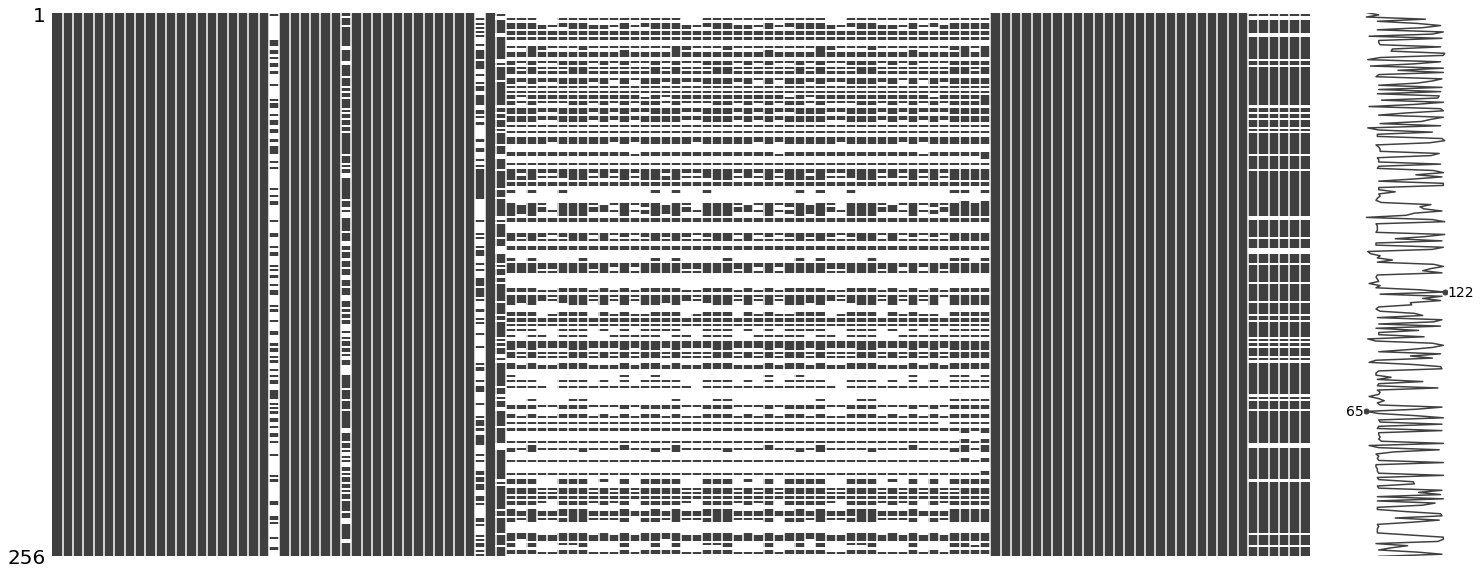

In [9]:
# Analyze missing values
msno.matrix(applications.sample(256))

Seems that there are a lot of missing values

In [10]:
# Read columns description csv file and view first 5 rows
columns_description = pd.read_csv("./data/homecredit_columns_description.csv", 
                                  encoding='cp1252')
columns_description.head()

,Unnamed: 0,Table,Row,Description,Special
0,1,applications.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,applications.csv,TARGET,Target variable (0 - client with payment diffi...,NaN
2,5,applications.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,applications.csv,CODE_GENDER,Gender of the client,NaN
4,7,applications.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [11]:
columns_description.Table.unique()

array(['applications.csv', 'bureau.csv', 'bureau_balance.csv',
       'POS_CASH_balance.csv', 'credit_card_balance.csv',
       'previous_application.csv', 'installments_payments.csv'],
      dtype=object)

In [12]:
# Remove NaN values
columns_description["Special"].fillna("No special mentions about this column", 
                                      inplace=True)

### <b> EDA for TARGET column

Target is the column that the model will have to learn to predict. $0$ means that the credit loan was not defaulted and $1$ means that the credit was defaulted (i.e. was not paid back)

<AxesSubplot:>

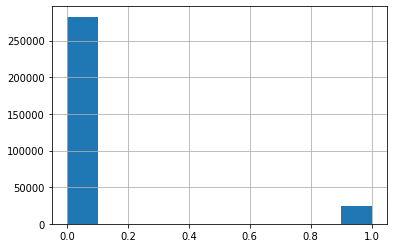

In [13]:
# Plot hist of TARGET column
applications["TARGET"].hist()

In [14]:
# Check number of positive examples in dataset
applications["TARGET"].sum()

24825

In [15]:
# Check number of NaN in TARGET column
applications["TARGET"].isna().sum()

0

For TARGET column we have a ***imbalanced class*** problem. There are much more credits that were returned that the ones that were not.

Thus, *Accuracy* is not a good metric because it will be misleading. Something like *Precision*, *Recall* or AUC will be much better. I choose ROC AUC because it will show model performance based on various tresholds, thus the business will get a better understanding about how this algorithm can be used in production and the deployment options (canary deployment/partial automation/full automation etc).

In [133]:
# Function for generating useful statistics about dataframes
def dataframe_analysis(dataframe, datatype, table_name="applications.csv", n=4):
    i = 0
    for column in dataframe.columns:
        if dataframe[column].dtype==datatype:
            
            # Show statistics only about 4 (n) columns
            # Remove this condition if want to see statistics about all columns
            i += 1
            if i == n:
                break
            
            print('\n'+"-"*80)
            print(f"NOW ANALYZING COLUMN: {column}")
            print("-"*80)
            try:
                print("COLUMN DESCRIPTION:")
                print(columns_description.loc[
                    (columns_description["Table"]==table_name) & 
                    (columns_description["Row"]==column)]["Description"].values[0], '\n')
                print("SPECIAL MENTIONS:")
                print(columns_description.loc[
                    (columns_description["Table"]==table_name) & (columns_description["Row"]=="TARGET")]["Special"].values[0], '\n')
            except:
                print("Did not find description for this column")
            print("TOP 5 ROWS:")
            print(dataframe[column].head())
            print("\nCOLUMN STATISTICS:")
            print(dataframe[column].describe())
            if datatype=="object":
                print("\nUNIQUE VALUESL")
                print(dataframe[column].unique())
            else:
                print("\nNumber of zeros:")
                print((dataframe[column]==0.0).sum())            
            print("\nNumber of NaN in column:")
            print(dataframe[column].isna().sum())
            dataframe[column].hist()
            plt.show()
            

### <b> EDA for *float64* columns


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_INCOME_TOTAL
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Income of the client 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   202500.00
1   270000.00
2    67500.00
3   135000.00
4   121500.00
Name: AMT_INCOME_TOTAL, dtype: float64

COLUMN STATISTICS:
count      307511.00
mean       168797.92
std        237123.15
min         25650.00
25%        112500.00
50%        147150.00
75%        202500.00
max     117000000.00
Name: AMT_INCOME_TOTAL, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


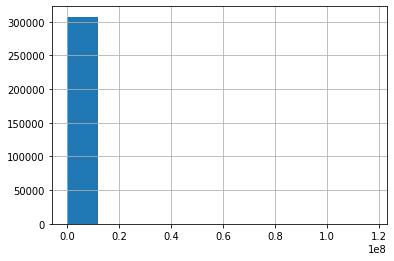


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_CREDIT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Credit amount of the loan 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    406597.50
1   1293502.50
2    135000.00
3    312682.50
4    513000.00
Name: AMT_CREDIT, dtype: float64

COLUMN STATISTICS:
count    307511.00
mean     599026.00
std      402490.78
min       45000.00
25%      270000.00
50%      513531.00
75%      808650.00
max     4050000.00
Name: AMT_CREDIT, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


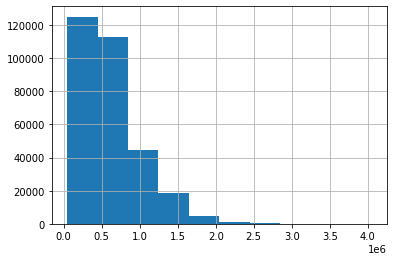


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_ANNUITY
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Loan annuity 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   24700.50
1   35698.50
2    6750.00
3   29686.50
4   21865.50
Name: AMT_ANNUITY, dtype: float64

COLUMN STATISTICS:
count   307499.00
mean     27108.57
std      14493.74
min       1615.50
25%      16524.00
50%      24903.00
75%      34596.00
max     258025.50
Name: AMT_ANNUITY, dtype: float64

Number of zeros:
0

Number of NaN in column:
12


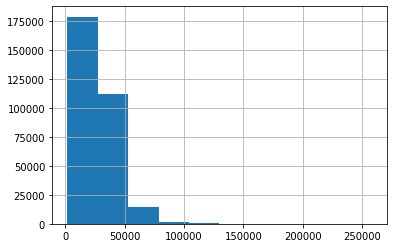

In [81]:
# View statistics about float64 columns
dataframe_analysis(applications, "float64")

### <b> EDA for *int64* columns


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: SK_ID_CURR
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
ID of loan in our sample 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    100002
1    100003
2    100004
3    100006
4    100007
Name: SK_ID_CURR, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean    278180.52
std     102790.18
min     100002.00
25%     189145.50
50%     278202.00
75%     367142.50
max     456255.00
Name: SK_ID_CURR, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


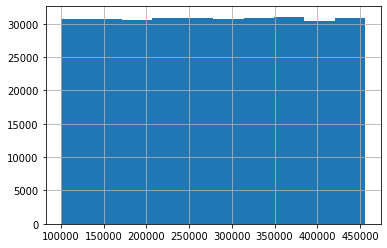


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: TARGET
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Target variable (0 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 1 - all other cases) 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    1
1    0
2    0
3    0
4    0
Name: TARGET, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         0.08
std          0.27
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: TARGET, dtype: float64

Number of zeros:
282686

Number of NaN in column:
0


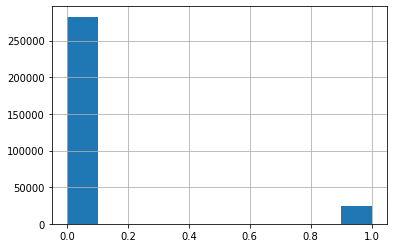


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: CNT_CHILDREN
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Number of children the client has 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    0
1    0
2    0
3    0
4    0
Name: CNT_CHILDREN, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         0.42
std          0.72
min          0.00
25%          0.00
50%          0.00
75%          1.00
max         19.00
Name: CNT_CHILDREN, dtype: float64

Number of zeros:
215371

Number of NaN in column:
0


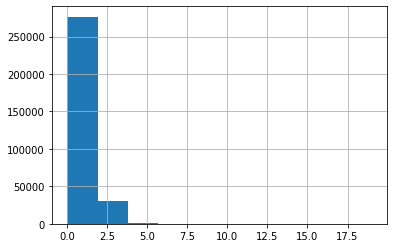

In [82]:
# View statistics about int64 columns
dataframe_analysis(applications, "int64")

### <b> EDA for *object (string)* columns


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: NAME_CONTRACT_TYPE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Identification if loan is cash or revolving 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0         Cash loans
1         Cash loans
2    Revolving loans
3         Cash loans
4         Cash loans
Name: NAME_CONTRACT_TYPE, dtype: object

COLUMN STATISTICS:
count         307511
unique             2
top       Cash loans
freq          278232
Name: NAME_CONTRACT_TYPE, dtype: object

UNIQUE VALUESL
['Cash loans' 'Revolving loans']

Number of NaN in column:
0


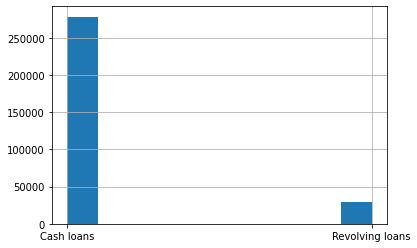


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: CODE_GENDER
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Gender of the client 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    M
1    F
2    M
3    F
4    M
Name: CODE_GENDER, dtype: object

COLUMN STATISTICS:
count     307511
unique         3
top            F
freq      202448
Name: CODE_GENDER, dtype: object

UNIQUE VALUESL
['M' 'F' 'XNA']

Number of NaN in column:
0


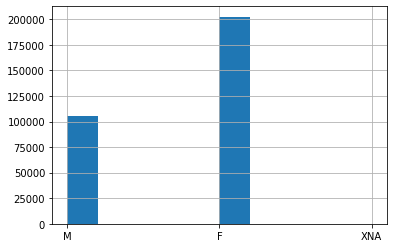


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLAG_OWN_CAR
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Flag if the client owns a car 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    N
1    N
2    Y
3    N
4    N
Name: FLAG_OWN_CAR, dtype: object

COLUMN STATISTICS:
count     307511
unique         2
top            N
freq      202924
Name: FLAG_OWN_CAR, dtype: object

UNIQUE VALUESL
['N' 'Y']

Number of NaN in column:
0


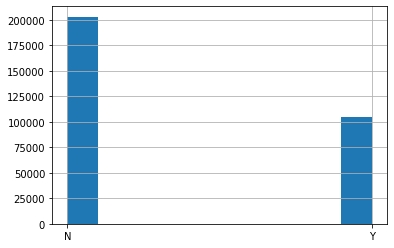

In [83]:
# View statistics about object columns
dataframe_analysis(applications, "object")

### <b> Analyze correlations

Analyze correlations with the TARGET column to better understand the dataset.

In [20]:
correlations = applications.corr().TARGET.sort_values(ascending=False).drop("TARGET")

In [21]:
# Print 20 most correlated columns
correlations.head(20)

DAYS_BIRTH                    0.08
REGION_RATING_CLIENT_W_CITY   0.06
REGION_RATING_CLIENT          0.06
DAYS_LAST_PHONE_CHANGE        0.06
DAYS_ID_PUBLISH               0.05
REG_CITY_NOT_WORK_CITY        0.05
FLAG_EMP_PHONE                0.05
REG_CITY_NOT_LIVE_CITY        0.04
FLAG_DOCUMENT_3               0.04
DAYS_REGISTRATION             0.04
OWN_CAR_AGE                   0.04
LIVE_CITY_NOT_WORK_CITY       0.03
DEF_30_CNT_SOCIAL_CIRCLE      0.03
DEF_60_CNT_SOCIAL_CIRCLE      0.03
FLAG_WORK_PHONE               0.03
AMT_REQ_CREDIT_BUREAU_YEAR    0.02
CNT_CHILDREN                  0.02
CNT_FAM_MEMBERS               0.01
OBS_30_CNT_SOCIAL_CIRCLE      0.01
OBS_60_CNT_SOCIAL_CIRCLE      0.01
Name: TARGET, dtype: float64

In [22]:
# Print 20 least correlated columns
correlations.tail(20)

AMT_CREDIT                   -0.03
LIVINGAREA_MODE              -0.03
ELEVATORS_MODE               -0.03
TOTALAREA_MODE               -0.03
FLOORSMIN_MODE               -0.03
LIVINGAREA_MEDI              -0.03
LIVINGAREA_AVG               -0.03
FLOORSMIN_MEDI               -0.03
FLOORSMIN_AVG                -0.03
ELEVATORS_MEDI               -0.03
ELEVATORS_AVG                -0.03
REGION_POPULATION_RELATIVE   -0.04
AMT_GOODS_PRICE              -0.04
FLOORSMAX_MODE               -0.04
FLOORSMAX_MEDI               -0.04
FLOORSMAX_AVG                -0.04
DAYS_EMPLOYED                -0.04
EXT_SOURCE_1                 -0.16
EXT_SOURCE_2                 -0.16
EXT_SOURCE_3                 -0.18
Name: TARGET, dtype: float64

<AxesSubplot:>

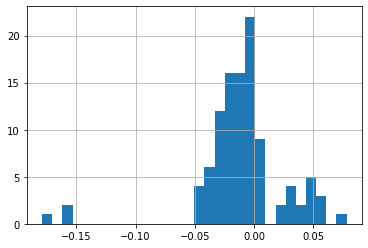

In [23]:
# View correlations histogram
correlations.hist(bins=30)

<a id=4></a>
<div style="padding:15px;color:white;margin:0;font-size:200%;text-align:center;display:fill;border-radius:5px;background-color:#5f0f40;overflow:hidden;font-weight:500"><b>4. Initial Preprocessing</b></div>

[go on top ↑](#0)

## <b>Managing missing values

For *float64* and *int64* columns I will fill NaN values with the mean.
For *object* columns NaNs will be automatically processed when performing one-hot encoding.

In [24]:
# Fill NaN with mean for numeric columns
for column in applications.columns:
    if applications[column].dtype != "object":
        applications[column].fillna(applications[column].mean(),
                                    inplace=True)        

## <b> Managing anomalies

During EDA I have noticed that the column Days Employeed has 
some anomalies. More than 50000 people worked for
more than 1000 years ar current job. This is not good
Will replace this with the mean value.

count   307511.00
mean     63815.05
std     141275.77
min     -17912.00
25%      -2760.00
50%      -1213.00
75%       -289.00
max     365243.00
Name: DAYS_EMPLOYED, dtype: float64

<AxesSubplot:>

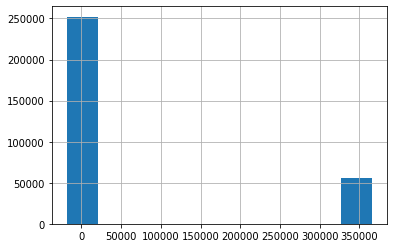

In [25]:
applications["DAYS_EMPLOYED"].describe()
applications["DAYS_EMPLOYED"].hist()

In [26]:
# Get mean value excepting anomalies
days_employed_mean = applications[applications.DAYS_EMPLOYED<300000].DAYS_EMPLOYED.mean()

It is ok that the value is negative, as seen in EDA, in this column, all values, except for anomalies, are negative.

In [27]:
applications["DAYS_EMPLOYED"].replace(to_replace=365243.00, 
                                      value=days_employed_mean,
                                      inplace=True)

<AxesSubplot:>

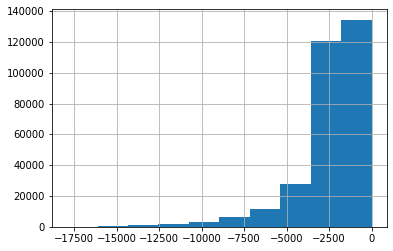

In [28]:
applications["DAYS_EMPLOYED"].hist()

## One-hot encoding

In [ ]:
# Copy of data for later experiments
applications_copy = applications.copy()

In [30]:
applications.dtypes.value_counts()

float64    66
int64      40
object     16
dtype: int64

In [31]:
# One-hot encode object columns
object_columns = applications.select_dtypes("object").columns
applications = pd.get_dummies(data=applications,
                         columns=object_columns,
                         dummy_na=False,
                         drop_first=False)
applications.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,...,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,1,0,202500.00,406597.50,24700.50,351000.00,0.02,-9461,-637.00,-3648.00,-2120,12.06,1,1,0,1,1,0,1.00,2,2,10,0,0,0,0,0,0,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.63,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0
1,100003,0,0,270000.00,1293502.50,35698.50,1129500.00,0.00,-16765,-1188.00,-1186.00,-291,12.06,1,1,0,1,1,0,2.00,1,1,11,0,0,0,0,0,0,0.31,0.62,0.51,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.05,0.00,0.01,0.09,0.05,0.99,0.80,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0
2,100004,0,0,67500.00,135000.00,6750.00,135000.00,0.01,-19046,-225.00,-4260.00,-2531,26.00,1,1,1,1,1,0,1.00,2,2,9,0,0,0,0,0,0,0.50,0.56,0.73,0.12,0.09,0.98,0.75,0.04,0.08,0.15,0.23,0.23,0.07,0.10,0.11,0.01,0.03,0.11,0.09,0.98,0.76,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,135000.00,312682.50,29686.50,297000.00,0.01,-19005,-3039.00,-9833.00,-2437,12.06,1,1,0,1,0,0,2.00,2,2,17,0,0,0,0,0,0,0.50,0.65,0.51,0.12,0.09,0.98,0.75,0.04,0.08,0.15,0.23,0.23,0.07,0.10,0.11,0.01,0.03,0.11,0.09,0.98,0.76,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,121500.00,513000.00,21865.50,513000.00,0.03,-19932,-3038.00,-4311.00,-3458,12.06,1,1,0,1,0,0,1.00,2,2,11,0,0,0,0,1,1,0.50,0.32,0.51,0.12,0.09,0.98,0.75,0.04,0.08,0.15,0.23,0.23,0.07,0.10,0.11,0.01,0.03,0.11,0.09,0.98,0.76,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0

## <b> Input scalling

To avoid target leakage I will split the dataset in train and test before training any scaller.
Scaller will be trained only on train data.

In [32]:
# Train/test split. 
# Because this is a big dataset, 10% for test set will be enough
x_train, x_test, y_train, y_test = train_test_split(
    applications.drop(["TARGET", "SK_ID_CURR"], axis=1),
    applications.TARGET,
    random_state=1,
    test_size=0.1,
    stratify=applications.TARGET)

x_train.shape, x_test.shape, y_train.shape, y_test.shape 

((276759, 244), (30752, 244), (276759,), (30752,))

Will normalize only the columns with mean>1.
The rest columns are already normalized according to data description.

In [33]:
for column in x_train.columns:
    if x_train[column].abs().mean()>1:
        scaler = StandardScaler().fit(x_train[column].to_numpy().reshape(-1,1))
        x_train[column] = scaler.transform(x_train[column].to_numpy().reshape(-1,1))
        x_test[column] = scaler.transform(x_test[column].to_numpy().reshape(-1,1))                

**Conclusions based on above data:**
- The target variable is imbalanced: 92% of our examples are credits that did not default
    - Will need to use a suitable metric. Something like accuracy will be misleading.
- Many columns have missing data. This needs to be addressed
- There are 16 string (object) columnds. Although some algorithms can work with strings,
    I will encode all string columns to be able to test various models on this dataset.

    


<a id=5></a><div style="padding:15px;color:white;margin:0;font-size:200%;text-align:center;display:fill;border-radius:5px;background-color:#55828b;overflow:hidden;font-weight:500"><b>5. Baseline</div>

[go on top ↑](#0)

In [34]:
def evaluate(model, features, labels, n_folds=5):
    """
    Function to evaluate the performance of models
    """
    # Rename feature columns
    #features.columns = np.arange(len(features.columns))
    
    # Record initial time
    t0 = time()
    
    # Initialize stratified kfold. Stratified because we have class imbalance
    kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1)

    # Initialize variable for storing score
    auc_all_folds = []
    fold = 0
    for train_indices, valid_indices in kfold.split(features, labels):
        train_features = features.iloc[train_indices]
        train_labels = labels.iloc[train_indices]
        validation_features = features.iloc[valid_indices]
        validation_labels = labels.iloc[valid_indices]   

        model = model.fit(train_features, train_labels)
        predictions = model.predict_proba(validation_features)
        
        fpr, tpr, thresholds = roc_curve(validation_labels, predictions[:,1])
        fold_auc = auc(fpr, tpr)
        auc_all_folds.append(fold_auc)
    print(f"Training took {(time()-t0):.0f} seconds")        
    print(f"Mean AUC for all folds is {np.mean(auc_all_folds):.4f}")
  
    print("ROC curve for last model:")
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=fold_auc,
                                   estimator_name="ROC Curve").plot()    
    plt.show()
    return None

## <b> Baseline: Logistic Regression

Training took 17 seconds
Mean AUC for all folds is 0.7459
ROC curve for last model:


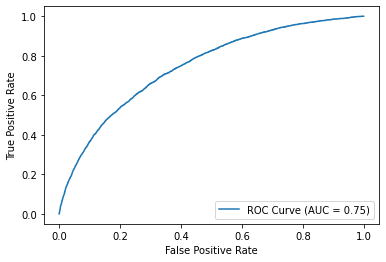

In [35]:
evaluate(LogisticRegression(random_state=1), x_train, y_train)

## <b> KNN 

Training took 92 seconds
Mean AUC for all folds is 0.5619
ROC curve for last model:


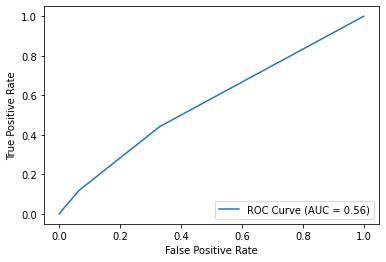

In [37]:
evaluate(KNeighborsClassifier(), x_train, y_train)

## <b> Decision Tree

Training took 80 seconds
Mean AUC for all folds is 0.5362
ROC curve for last model:


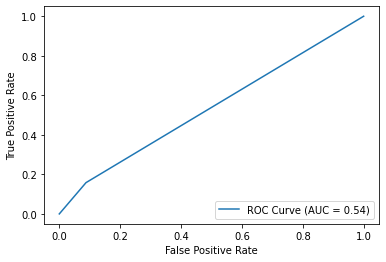

In [38]:
evaluate(DecisionTreeClassifier(random_state=1), x_train, y_train)

## <b> Random Forest

Training took 57 seconds
Mean AUC for all folds is 0.7092
ROC curve for last model:


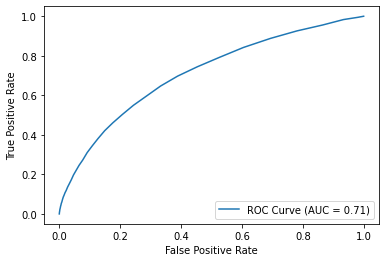

In [39]:
evaluate(RandomForestClassifier(random_state=1, n_jobs=16), x_train, y_train)

## <b> XGBoosting

Training took 74 seconds
Mean AUC for all folds is 0.7245
ROC curve for last model:


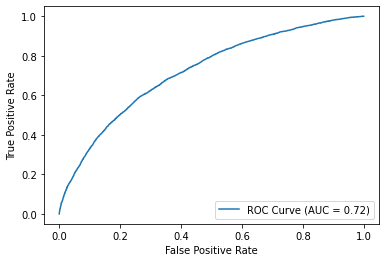

In [ ]:
evaluate(XGBRFClassifier(random_state=1, n_jobs=16), x_train, y_train)

## <b> LGBM

Training took 10 seconds
Mean AUC for all folds is 0.7550
ROC curve for last model:


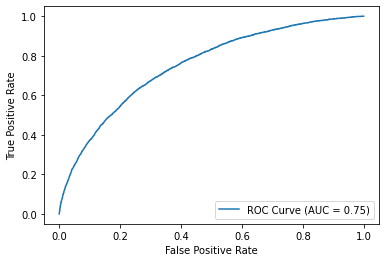

In [42]:
# Rename columns according to LGBM requirments
x_train = x_train.rename(
    columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
x_test = x_test.rename(
    columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

evaluate(LGBMClassifier(random_state=1, n_jobs=16), x_train, y_train)

## <b> MLP

In [43]:
# Record initial time
t0 = time()

# Initialize stratified kfold. Stratified because we have class imbalance
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Initialize variable for storing score
auc_all_folds = []
fold = 0
for train_indices, valid_indices in kfold.split(x_train, y_train):
    train_features = x_train.iloc[train_indices]
    train_labels = y_train.iloc[train_indices]
    validation_features = x_train.iloc[valid_indices]
    validation_labels = y_train.iloc[valid_indices]       
    
    model = keras.Sequential([
    layers.Dense(50, activation="relu"),
    layers.Dense(30, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["AUC"])
    history = model.fit(train_features,
                        train_labels,
                        epochs=10,
                        batch_size=256,
                        validation_data=(validation_features, validation_labels),
                        verbose=0)
    
    fold_auc = max(history.history["val_auc"])
    
    auc_all_folds.append(fold_auc)

print(f"Training took {(time()-t0):.2f} seconds")
print(f"Mean AUC for all folds is {np.mean(auc_all_folds):.4f}")


Training took 217.15 seconds
Mean AUC for all folds is 0.7465


Seems like LGBMClassifier has the highes AUC

## <b> Some experiments

In [46]:
def split_and_scale(df):
    x_train, x_test, y_train, y_test = train_test_split(
    applications.drop(["TARGET", "SK_ID_CURR"], axis=1),
    applications.TARGET,
    random_state=1,
    test_size=0.1,
    stratify=applications.TARGET)

    for column in x_train.columns:
        if x_train[column].abs().mean()>1:
            scaler = StandardScaler().fit(x_train[column].to_numpy().reshape(-1,1))
            x_train[column] = scaler.transform(x_train[column].to_numpy().reshape(-1,1))
            x_test[column] = scaler.transform(x_test[column].to_numpy().reshape(-1,1))  
    
    x_train = x_train.rename(
        columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    x_test = x_test.rename(
        columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    
    return x_train, x_test, y_train, y_test

Try to get k-1 dummies out of k categorical levels by removing the first level.
Previous I created k dummies for k categorical levels.


Training took 13 seconds
Mean AUC for all folds is 0.7550
ROC curve for last model:


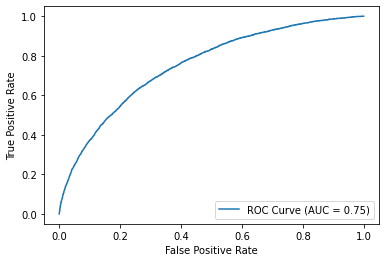

In [48]:
# Try drop first One-hot encoding
applications_new = pd.get_dummies(data=applications_copy,
                         columns=applications_copy.select_dtypes("object").columns,
                         dummy_na=False,
                         drop_first=True)

x_train_new, x_test_new, y_train_new, y_test_new = split_and_scale(applications_new)

evaluate(LGBMClassifier(random_state=1, n_jobs=10), x_train_new, y_train_new)

Try to not create dummy for NaN values in categorical columns

Training took 10 seconds
Mean AUC for all folds is 0.7550
ROC curve for last model:


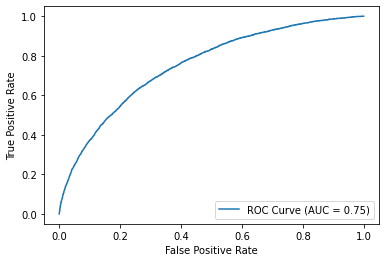

In [49]:
# Try create dummy for NaN
applications_new = pd.get_dummies(data=applications_copy,
                         columns=applications_copy.select_dtypes("object").columns,
                         dummy_na=True,
                         drop_first=False)

x_train_new, x_test_new, y_train_new, y_test_new = split_and_scale(applications_new)

evaluate(LGBMClassifier(random_state=1, n_jobs=10), x_train_new, y_train_new)

No experiment showed improvement over baseling, thus will not change the configuration.

<a id=6></a><div style="padding:15px;color:white;margin:0;font-size:200%;text-align:center;display:fill;border-radius:5px;background-color:#489fb5;overflow:hidden;font-weight:500"><b>6. Feature Engineering</b></div>

[go on top ↑](#0)

In [23]:
# Read files
app = pd.read_csv("./data/applications.csv").drop("TARGET", axis=1)
bureau = pd.read_csv("./data/bureau.csv")
bureau_balance = pd.read_csv("./data/bureau_balance.csv")
credit = pd.read_csv("./data/credit_card_balance.csv")
cash = pd.read_csv("./data/pos_cash_balance.csv")
previous = pd.read_csv("./data/previous_application.csv")
installments = pd.read_csv("./data/installments_payments.csv")            

In [24]:
app.shape

(307511, 121)

## <b>Additional EDA

Lets do some more EDA before constructing new features

In [25]:
columns_description.Table.unique()

array(['applications.csv', 'bureau.csv', 'bureau_balance.csv',
       'POS_CASH_balance.csv', 'credit_card_balance.csv',
       'previous_application.csv', 'installments_payments.csv'],
      dtype=object)

### <b>bureau.csv

In [26]:
# View shape of file
bureau.shape

(1716428, 17)

In [27]:
# View first 5 rows
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.00,-153.00,NaN,0,91323.00,0.00,NaN,0.00,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.00,NaN,NaN,0,225000.00,171342.00,NaN,0.00,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.00,NaN,NaN,0,464323.50,NaN,NaN,0.00,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.00,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.00,NaN,77674.50,0,2700000.00,NaN,NaN,0.00,Consumer credit,-21,NaN


In [28]:
# View last 5 rows
bureau.tail()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
1716423,259355,5057750,Active,currency 1,-44,0,-30.00,NaN,0.00,0,11250.00,11250.00,0.00,0.00,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.00,-2493.00,5476.50,0,38130.84,0.00,0.00,0.00,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.00,-970.00,NaN,0,15570.00,NaN,NaN,0.00,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.00,-1513.00,NaN,0,36000.00,0.00,0.00,0.00,Consumer credit,-1508,NaN
1716427,246829,5057778,Closed,currency 1,-463,0,NaN,-387.00,NaN,0,22500.00,0.00,NaN,0.00,Microloan,-387,NaN


In [29]:
# View dataframe statistics
bureau.describe()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1716428.00,1716428.00,1716428.00,1716428.00,1610875.00,1082775.00,591940.00,1716428.00,1716415.00,1458759.00,1124648.00,1716428.00,1716428.00,489637.00
mean,278214.93,5924434.49,-1142.11,0.82,510.52,-1017.44,3825.42,0.01,354994.59,137085.12,6229.51,37.91,-593.75,15712.76
std,102938.56,532265.73,795.16,36.54,4994.22,714.01,206031.61,0.10,1149811.34,677401.13,45032.03,5937.65,720.75,325826.95
min,100001.00,5000000.00,-2922.00,0.00,-42060.00,-42023.00,0.00,0.00,0.00,-4705600.32,-586406.11,0.00,-41947.00,0.00
25%,188866.75,5463953.75,-1666.00,0.00,-1138.00,-1489.00,0.00,0.00,51300.00,0.00,0.00,0.00,-908.00,0.00
50%,278055.00,5926303.50,-987.00,0.00,-330.00,-897.00,0.00,0.00,125518.50,0.00,0.00,0.00,-395.00,0.00
75%,367426.00,6385681.25,-474.00,0.00,474.00,-425.00,0.00,0.00,315000.00,40153.50,0.00,0.00,-33.00,13500.00
max,456255.00,6843457.00,0.00,2792.00,31199.00,0.00,115987185.00,9.00,585000000.00,170100000.00,4705600.32,3756681.00,372.00,118453423.50


In [30]:
# View columns datatypes
bureau.dtypes.value_counts()

float64    8
int64      6
object     3
dtype: int64

#### <b> EDA for *float64* columns


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: DAYS_CREDIT_ENDDATE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Remaining duration of CB credit (in days) at the time of application in Home Credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
5714462   -153.00
5714463   1075.00
5714464    528.00
5714465       NaN
5714466   1197.00
Name: DAYS_CREDIT_ENDDATE, dtype: float64

COLUMN STATISTICS:
count   1610875.00
mean        510.52
std        4994.22
min      -42060.00
25%       -1138.00
50%        -330.00
75%         474.00
max       31199.00
Name: DAYS_CREDIT_ENDDATE, dtype: float64

Number of zeros:
883

Number of NaN in column:
105553


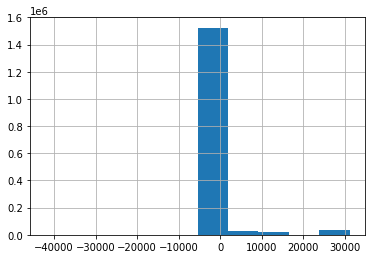


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: DAYS_ENDDATE_FACT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Days since CB credit ended at the time of application in Home Credit (only for closed credit) 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
5714462   -153.00
5714463       NaN
5714464       NaN
5714465       NaN
5714466       NaN
Name: DAYS_ENDDATE_FACT, dtype: float64

COLUMN STATISTICS:
count   1082775.00
mean      -1017.44
std         714.01
min      -42023.00
25%       -1489.00
50%        -897.00
75%        -425.00
max           0.00
Name: DAYS_ENDDATE_FACT, dtype: float64

Number of zeros:
64

Number of NaN in column:
633653


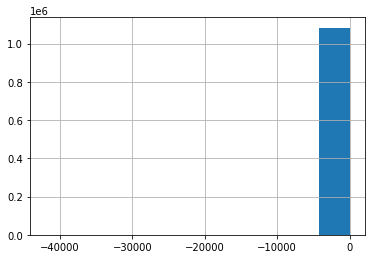


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_CREDIT_MAX_OVERDUE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample) 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
5714462        NaN
5714463        NaN
5714464        NaN
5714465        NaN
5714466   77674.50
Name: AMT_CREDIT_MAX_OVERDUE, dtype: float64

COLUMN STATISTICS:
count      591940.00
mean         3825.42
std        206031.61
min             0.00
25%             0.00
50%             0.00
75%             0.00
max     115987185.00
Name: AMT_CREDIT_MAX_OVERDUE, dtype: float64

Number of zeros:
470650

Number of NaN in column:
1124488


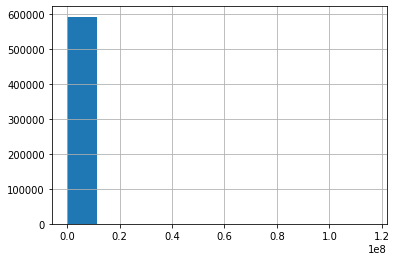

In [84]:
# View statistics about float64 columns
dataframe_analysis(bureau, "float64", table_name="bureau.csv")

#### <b> EDA for *int64* columns


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: SK_ID_CURR
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau  

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
5714462    215354
5714463    215354
5714464    215354
5714465    215354
5714466    215354
Name: SK_ID_CURR, dtype: int64

COLUMN STATISTICS:
count   1716428.00
mean     278214.93
std      102938.56
min      100001.00
25%      188866.75
50%      278055.00
75%      367426.00
max      456255.00
Name: SK_ID_CURR, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


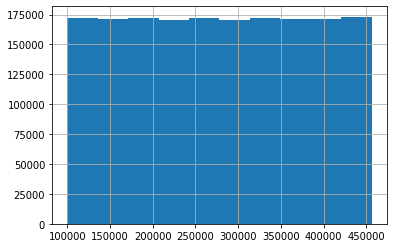


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: SK_ID_BUREAU
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did not find description for this column
TOP 5 ROWS:
5714462    5714462
5714463    5714463
5714464    5714464
5714465    5714465
5714466    5714466
Name: SK_ID_BUREAU, dtype: int64

COLUMN STATISTICS:
count   1716428.00
mean    5924434.49
std      532265.73
min     5000000.00
25%     5463953.75
50%     5926303.50
75%     6385681.25
max     6843457.00
Name: SK_ID_BUREAU, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


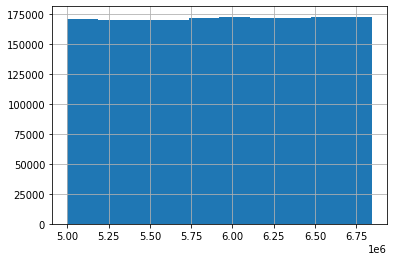


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: DAYS_CREDIT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
How many days before current application did client apply for Credit Bureau credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
5714462   -497
5714463   -208
5714464   -203
5714465   -203
5714466   -629
Name: DAYS_CREDIT, dtype: int64

COLUMN STATISTICS:
count   1716428.00
mean      -1142.11
std         795.16
min       -2922.00
25%       -1666.00
50%        -987.00
75%        -474.00
max           0.00
Name: DAYS_CREDIT, dtype: float64

Number of zeros:
25

Number of NaN in column:
0


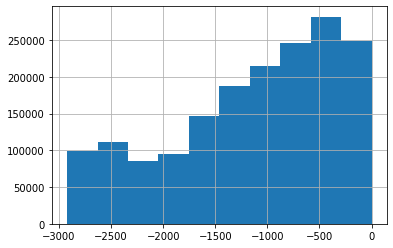

In [85]:
# View statistics about int64 columns
dataframe_analysis(bureau, "int64", table_name="bureau.csv")

#### <b> EDA for *object (string)* columns

In [86]:
# View statistics about object columns
dataframe_analysis(bureau, "object", table_name="bureau.csv")

### <b>bureau_balance.csv

In [87]:
# View shape of file
bureau_balance.shape

(27299925, 4)

In [88]:
# View first 5 rows
bureau_balance.head()

,bureau_balance_index,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,0,5715448,0,C
1,1,5715448,-1,C
2,2,5715448,-2,C
3,3,5715448,-3,C
4,4,5715448,-4,C


In [89]:
# View last 5 rows
bureau_balance.tail()

,bureau_balance_index,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
27299920,27299920,5041336,-47,X
27299921,27299921,5041336,-48,X
27299922,27299922,5041336,-49,X
27299923,27299923,5041336,-50,X
27299924,27299924,5041336,-51,X


In [90]:
# View dataframe statistics
bureau_balance.describe()

,bureau_balance_index,SK_ID_BUREAU,MONTHS_BALANCE
count,27299925.00,27299925.00,27299925.00
mean,13649962.00,6036297.33,-30.74
std,7880809.67,492348.86,23.86
min,0.00,5001709.00,-96.00
25%,6824981.00,5730933.00,-46.00
50%,13649962.00,6070821.00,-25.00
75%,20474943.00,6431951.00,-11.00
max,27299924.00,6842888.00,0.00


In [91]:
# View columns datatypes
bureau_balance.dtypes.value_counts()

int64       3
category    1
dtype: int64

#### <b> EDA for *float64* columns

In [92]:
# View statistics about float64 columns
dataframe_analysis(bureau_balance, "float64", table_name="bureau_balance.csv")

#### <b> EDA for *int64* columns


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: bureau_balance_index
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did not find description for this column
TOP 5 ROWS:
0    0
1    1
2    2
3    3
4    4
Name: bureau_balance_index, dtype: int64

COLUMN STATISTICS:
count   27299925.00
mean    13649962.00
std      7880809.67
min            0.00
25%      6824981.00
50%     13649962.00
75%     20474943.00
max     27299924.00
Name: bureau_balance_index, dtype: float64

Number of zeros:
1

Number of NaN in column:
0


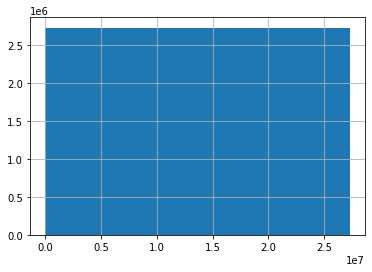


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: SK_ID_BUREAU
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did not find description for this column
TOP 5 ROWS:
0    5715448
1    5715448
2    5715448
3    5715448
4    5715448
Name: SK_ID_BUREAU, dtype: int64

COLUMN STATISTICS:
count   27299925.00
mean     6036297.33
std       492348.86
min      5001709.00
25%      5730933.00
50%      6070821.00
75%      6431951.00
max      6842888.00
Name: SK_ID_BUREAU, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


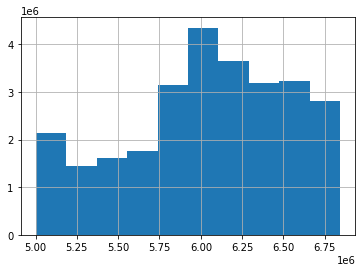


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: MONTHS_BALANCE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Month of balance relative to application date (-1 means the freshest balance date) 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    0
1   -1
2   -2
3   -3
4   -4
Name: MONTHS_BALANCE, dtype: int64

COLUMN STATISTICS:
count   27299925.00
mean         -30.74
std           23.86
min          -96.00
25%          -46.00
50%          -25.00
75%          -11.00
max            0.00
Name: MONTHS_BALANCE, dtype: float64

Number of zeros:
610965

Number of NaN in column:
0


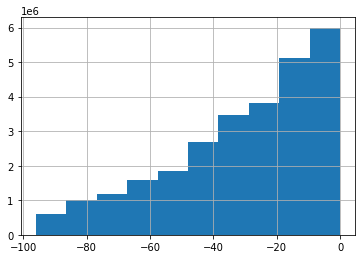

In [93]:
# View statistics about int64 columns
dataframe_analysis(bureau_balance, "int64", table_name="bureau_balance.csv")

#### <b> EDA for *object (string)* columns

In [94]:
# View statistics about object columns
dataframe_analysis(bureau_balance, "object", table_name="bureau_balance.csv")

### <b>POS_CASH_balance.csv

In [95]:
# View shape of file
cash.shape

(10001358, 9)

In [96]:
# View first 5 rows
cash.head()

,cash_index,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,0,1803195,182943,-31,48.00,45.00,Active,0,0
1,1,1715348,367990,-33,36.00,35.00,Active,0,0
2,2,1784872,397406,-32,12.00,9.00,Active,0,0
3,3,1903291,269225,-35,48.00,42.00,Active,0,0
4,4,2341044,334279,-35,36.00,35.00,Active,0,0


In [97]:
# View last 5 rows
cash.tail()

,cash_index,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
10001353,10001353,2448283,226558,-20,6.00,0.00,Active,843,0
10001354,10001354,1717234,141565,-19,12.00,0.00,Active,602,0
10001355,10001355,1283126,315695,-21,10.00,0.00,Active,609,0
10001356,10001356,1082516,450255,-22,12.00,0.00,Active,614,0
10001357,10001357,1259607,174278,-52,16.00,0.00,Completed,0,0


In [98]:
# View dataframe statistics
cash.describe()

,cash_index,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
count,10001358.00,10001358.00,10001358.00,10001358.00,9975287.00,9975271.00,10001358.00,10001358.00
mean,5000678.50,1903216.60,278403.86,-35.01,17.09,10.48,11.61,0.65
std,2887143.51,535846.53,102763.75,26.07,12.00,11.11,132.71,32.76
min,0.00,1000001.00,100001.00,-96.00,1.00,0.00,0.00,0.00
25%,2500339.25,1434405.00,189550.00,-54.00,10.00,3.00,0.00,0.00
50%,5000678.50,1896565.00,278654.00,-28.00,12.00,7.00,0.00,0.00
75%,7501017.75,2368963.00,367429.00,-13.00,24.00,14.00,0.00,0.00
max,10001357.00,2843499.00,456255.00,-1.00,92.00,85.00,4231.00,3595.00


In [99]:
# View columns datatypes
cash.dtypes.value_counts()

int64       6
float64     2
category    1
dtype: int64

#### <b> EDA for *float64* columns


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: CNT_INSTALMENT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Term of previous credit (can change over time) 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0   48.00
1   36.00
2   12.00
3   48.00
4   36.00
Name: CNT_INSTALMENT, dtype: float64

COLUMN STATISTICS:
count   9975287.00
mean         17.09
std          12.00
min           1.00
25%          10.00
50%          12.00
75%          24.00
max          92.00
Name: CNT_INSTALMENT, dtype: float64

Number of zeros:
0

Number of NaN in column:
26071


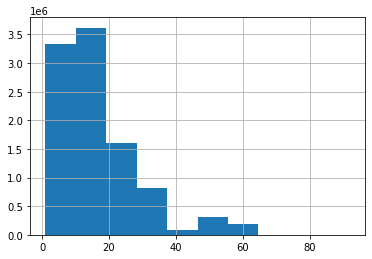


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: CNT_INSTALMENT_FUTURE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Installments left to pay on the previous credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0   45.00
1   35.00
2    9.00
3   42.00
4   35.00
Name: CNT_INSTALMENT_FUTURE, dtype: float64

COLUMN STATISTICS:
count   9975271.00
mean         10.48
std          11.11
min           0.00
25%           3.00
50%           7.00
75%          14.00
max          85.00
Name: CNT_INSTALMENT_FUTURE, dtype: float64

Number of zeros:
1185960

Number of NaN in column:
26087


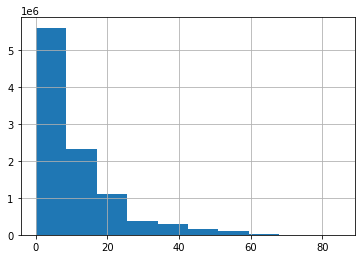

In [100]:
# View statistics about float64 columns
dataframe_analysis(cash, "float64", table_name="POS_CASH_balance.csv")

#### <b> EDA for *int64* columns


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: cash_index
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did not find description for this column
TOP 5 ROWS:
0    0
1    1
2    2
3    3
4    4
Name: cash_index, dtype: int64

COLUMN STATISTICS:
count   10001358.00
mean     5000678.50
std      2887143.51
min            0.00
25%      2500339.25
50%      5000678.50
75%      7501017.75
max     10001357.00
Name: cash_index, dtype: float64

Number of zeros:
1

Number of NaN in column:
0


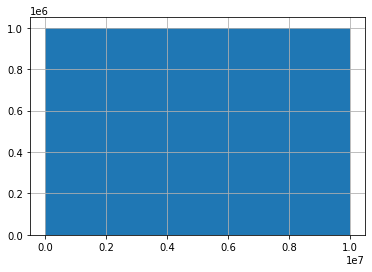


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: SK_ID_PREV
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did not find description for this column
TOP 5 ROWS:
0    1803195
1    1715348
2    1784872
3    1903291
4    2341044
Name: SK_ID_PREV, dtype: int64

COLUMN STATISTICS:
count   10001358.00
mean     1903216.60
std       535846.53
min      1000001.00
25%      1434405.00
50%      1896565.00
75%      2368963.00
max      2843499.00
Name: SK_ID_PREV, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


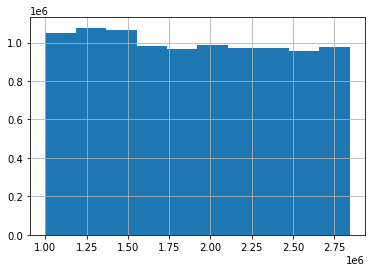


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: SK_ID_CURR
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
ID of loan in our sample 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    182943
1    367990
2    397406
3    269225
4    334279
Name: SK_ID_CURR, dtype: int64

COLUMN STATISTICS:
count   10001358.00
mean      278403.86
std       102763.75
min       100001.00
25%       189550.00
50%       278654.00
75%       367429.00
max       456255.00
Name: SK_ID_CURR, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


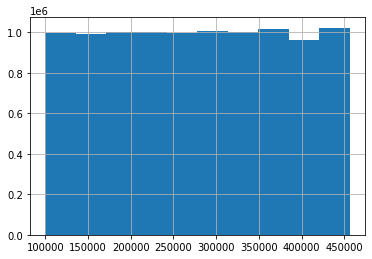

In [101]:
# View statistics about int64 columns
dataframe_analysis(cash, "int64", table_name="POS_CASH_balance.csv")

#### <b> EDA for *object (string)* columns

In [102]:
# View statistics about object columns
dataframe_analysis(cash, "object", table_name="POS_CASH_balance.csv")

### <b>credit_card_balance.csv

In [103]:
# View shape of file
credit.shape

(3840312, 24)

In [104]:
# View first 5 rows
credit.head()

,credit_index,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,0,2562384,378907,-6,56.97,135000,0.00,877.50,0.00,877.50,1700.33,1800.00,1800.00,0.00,0.00,0.00,0.00,1,0.00,1.00,35.00,Active,0,0
1,1,2582071,363914,-1,63975.56,45000,2250.00,2250.00,0.00,0.00,2250.00,2250.00,2250.00,60175.08,64875.56,64875.56,1.00,1,0.00,0.00,69.00,Active,0,0
2,2,1740877,371185,-7,31815.22,450000,0.00,0.00,0.00,0.00,2250.00,2250.00,2250.00,26926.42,31460.08,31460.08,0.00,0,0.00,0.00,30.00,Active,0,0
3,3,1389973,337855,-4,236572.11,225000,2250.00,2250.00,0.00,0.00,11795.76,11925.00,11925.00,224949.29,233048.97,233048.97,1.00,1,0.00,0.00,10.00,Active,0,0
4,4,1891521,126868,-1,453919.46,450000,0.00,11547.00,0.00,11547.00,22924.89,27000.00,27000.00,443044.40,453919.46,453919.46,0.00,1,0.00,1.00,101.00,Active,0,0


In [105]:
# View last 5 rows
credit.tail()

,credit_index,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
3840307,3840307,1036507,328243,-9,0.00,45000,NaN,0.00,NaN,NaN,0.00,NaN,0.00,0.00,0.00,0.00,NaN,0,NaN,NaN,0.00,Active,0,0
3840308,3840308,1714892,347207,-9,0.00,45000,0.00,0.00,0.00,0.00,0.00,1879.11,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,23.00,Active,0,0
3840309,3840309,1302323,215757,-9,275784.97,585000,270000.00,270000.00,0.00,0.00,2250.00,375750.00,356994.67,269356.14,273093.97,273093.97,2.00,2,0.00,0.00,18.00,Active,0,0
3840310,3840310,1624872,430337,-10,0.00,450000,NaN,0.00,NaN,NaN,0.00,NaN,0.00,0.00,0.00,0.00,NaN,0,NaN,NaN,0.00,Active,0,0
3840311,3840311,2411345,236760,-10,0.00,157500,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,21.00,Completed,0,0


In [106]:
# View dataframe statistics
credit.describe()

,credit_index,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
count,3840312.00,3840312.00,3840312.00,3840312.00,3840312.00,3840312.00,3090496.00,3840312.00,3090496.00,3090496.00,3535076.00,3072324.00,3840312.00,3840312.00,3840312.00,3840312.00,3090496.00,3840312.00,3090496.00,3090496.00,3535076.00,3840312.00,3840312.00
mean,1920155.50,1904503.59,278324.21,-34.52,58300.16,153807.96,5961.32,7433.39,288.17,2968.80,3540.20,10280.54,7588.86,55965.88,58088.81,58098.29,0.31,0.70,0.00,0.56,20.83,9.28,0.33
std,1108602.73,536469.47,102704.48,26.67,106307.03,165145.70,28225.69,33846.08,8201.99,20796.89,5600.15,36078.08,32005.99,102533.62,105965.37,105971.80,1.10,3.19,0.08,3.24,20.05,97.52,21.48
min,0.00,1000018.00,100006.00,-96.00,-420250.18,0.00,-6827.31,-6211.62,0.00,0.00,0.00,0.00,0.00,-423305.82,-420250.18,-420250.18,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,960077.75,1434385.00,189517.00,-55.00,0.00,45000.00,0.00,0.00,0.00,0.00,0.00,152.37,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,0.00,0.00
50%,1920155.50,1897122.00,278396.00,-28.00,0.00,112500.00,0.00,0.00,0.00,0.00,0.00,2702.70,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,15.00,0.00,0.00
75%,2880233.25,2369327.75,367580.00,-11.00,89046.69,180000.00,0.00,0.00,0.00,0.00,6633.91,9000.00,6750.00,85359.24,88899.49,88914.51,0.00,0.00,0.00,0.00,32.00,0.00,0.00
max,3840311.00,2843496.00,456250.00,-1.00,1505902.19,1350000.00,2115000.00,2287098.31,1529847.00,2239274.16,202882.01,4289207.45,4278315.69,1472316.79,1493338.19,1493338.19,51.00,165.00,12.00,165.00,120.00,3260.00,3260.00


In [107]:
# View columns datatypes
credit.dtypes.value_counts()

float64     15
int64        8
category     1
dtype: int64

#### <b> EDA for *float64* columns


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_BALANCE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Balance during the month of previous credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0       56.97
1    63975.56
2    31815.22
3   236572.11
4   453919.46
Name: AMT_BALANCE, dtype: float64

COLUMN STATISTICS:
count   3840312.00
mean      58300.16
std      106307.03
min     -420250.18
25%           0.00
50%           0.00
75%       89046.69
max     1505902.19
Name: AMT_BALANCE, dtype: float64

Number of zeros:
2156420

Number of NaN in column:
0


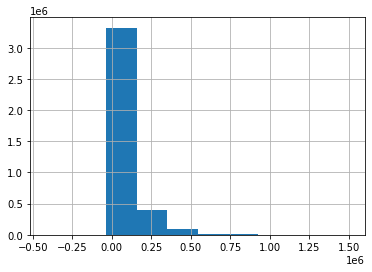


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_DRAWINGS_ATM_CURRENT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Amount drawing at ATM during the month of the previous credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0      0.00
1   2250.00
2      0.00
3   2250.00
4      0.00
Name: AMT_DRAWINGS_ATM_CURRENT, dtype: float64

COLUMN STATISTICS:
count   3090496.00
mean       5961.32
std       28225.69
min       -6827.31
25%           0.00
50%           0.00
75%           0.00
max     2115000.00
Name: AMT_DRAWINGS_ATM_CURRENT, dtype: float64

Number of zeros:
2665718

Number of NaN in column:
749816


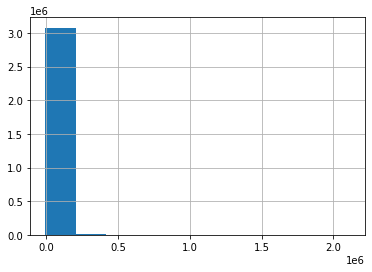


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_DRAWINGS_CURRENT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Amount drawing during the month of the previous credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0     877.50
1    2250.00
2       0.00
3    2250.00
4   11547.00
Name: AMT_DRAWINGS_CURRENT, dtype: float64

COLUMN STATISTICS:
count   3840312.00
mean       7433.39
std       33846.08
min       -6211.62
25%           0.00
50%           0.00
75%           0.00
max     2287098.31
Name: AMT_DRAWINGS_CURRENT, dtype: float64

Number of zeros:
3223443

Number of NaN in column:
0


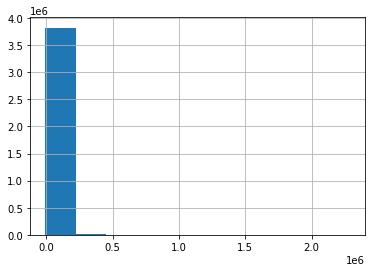

In [108]:
# View statistics about float64 columns
dataframe_analysis(credit, "float64", table_name="credit_card_balance.csv")

#### <b> EDA for *int64* columns


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: credit_index
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did not find description for this column
TOP 5 ROWS:
0    0
1    1
2    2
3    3
4    4
Name: credit_index, dtype: int64

COLUMN STATISTICS:
count   3840312.00
mean    1920155.50
std     1108602.73
min           0.00
25%      960077.75
50%     1920155.50
75%     2880233.25
max     3840311.00
Name: credit_index, dtype: float64

Number of zeros:
1

Number of NaN in column:
0


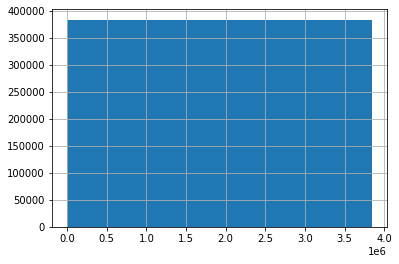


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: SK_ID_PREV
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did not find description for this column
TOP 5 ROWS:
0    2562384
1    2582071
2    1740877
3    1389973
4    1891521
Name: SK_ID_PREV, dtype: int64

COLUMN STATISTICS:
count   3840312.00
mean    1904503.59
std      536469.47
min     1000018.00
25%     1434385.00
50%     1897122.00
75%     2369327.75
max     2843496.00
Name: SK_ID_PREV, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


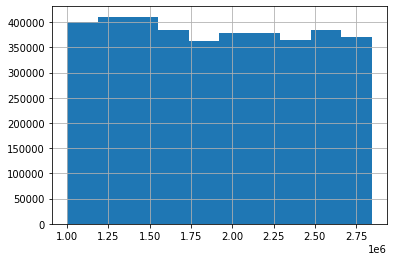


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: SK_ID_CURR
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
ID of loan in our sample 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    378907
1    363914
2    371185
3    337855
4    126868
Name: SK_ID_CURR, dtype: int64

COLUMN STATISTICS:
count   3840312.00
mean     278324.21
std      102704.48
min      100006.00
25%      189517.00
50%      278396.00
75%      367580.00
max      456250.00
Name: SK_ID_CURR, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


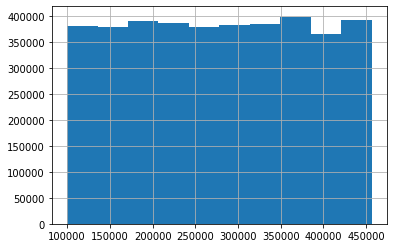

In [109]:
# View statistics about int64 columns
dataframe_analysis(credit, "int64", table_name="credit_card_balance.csv")

#### <b> EDA for *object (string)* columns

In [110]:
# View statistics about object columns
dataframe_analysis(credit, "object", table_name="credit_card_balance.csv")

### <b>previous_application.csv

In [111]:
# View shape of file
previous.shape

(1670214, 37)

In [112]:
# View first 5 rows
previous.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
2030495,2030495,271877,Consumer loans,1730.43,17145.00,17145.00,0.00,17145.00,SATURDAY,15,Y,1,0.00,0.18,0.87,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.00,middle,POS mobile with interest,365243.00,-42.00,300.00,-42.00,-37.00,0.00
2802425,2802425,108129,Cash loans,25188.62,607500.00,679671.00,NaN,607500.00,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.00,low_action,Cash X-Sell: low,365243.00,-134.00,916.00,365243.00,365243.00,1.00
2523466,2523466,122040,Cash loans,15060.74,112500.00,136444.50,NaN,112500.00,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.00,high,Cash X-Sell: high,365243.00,-271.00,59.00,365243.00,365243.00,1.00
2819243,2819243,176158,Cash loans,47041.33,450000.00,470790.00,NaN,450000.00,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.00,middle,Cash X-Sell: middle,365243.00,-482.00,-152.00,-182.00,-177.00,1.00
1784265,1784265,202054,Cash loans,31924.40,337500.00,404055.00,NaN,337500.00,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.00,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
# View last 5 rows
previous.tail()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
2300464,2300464,352015,Consumer loans,14704.29,267295.50,311400.00,0.00,267295.50,WEDNESDAY,12,Y,1,0.00,NaN,NaN,XAP,Approved,-544,Cash through the bank,XAP,NaN,Refreshed,Furniture,POS,XNA,Stone,43,Furniture,30.00,low_normal,POS industry with interest,365243.00,-508.00,362.00,-358.00,-351.00,0.00
2357031,2357031,334635,Consumer loans,6622.02,87750.00,64291.50,29250.00,87750.00,TUESDAY,15,Y,1,0.34,NaN,NaN,XAP,Approved,-1694,Cash through the bank,XAP,Unaccompanied,New,Furniture,POS,XNA,Stone,43,Furniture,12.00,middle,POS industry with interest,365243.00,-1604.00,-1274.00,-1304.00,-1297.00,0.00
2659632,2659632,249544,Consumer loans,11520.85,105237.00,102523.50,10525.50,105237.00,MONDAY,12,Y,1,0.10,NaN,NaN,XAP,Approved,-1488,Cash through the bank,XAP,"Spouse, partner",Repeater,Consumer Electronics,POS,XNA,Country-wide,1370,Consumer electronics,10.00,low_normal,POS household with interest,365243.00,-1457.00,-1187.00,-1187.00,-1181.00,0.00
2785582,2785582,400317,Cash loans,18821.52,180000.00,191880.00,NaN,180000.00,WEDNESDAY,9,Y,1,NaN,NaN,NaN,XNA,Approved,-1185,Cash through the bank,XAP,Family,Repeater,XNA,Cash,x-sell,AP+ (Cash loan),-1,XNA,12.00,low_normal,Cash X-Sell: low,365243.00,-1155.00,-825.00,-825.00,-817.00,1.00
2418762,2418762,261212,Cash loans,16431.30,360000.00,360000.00,NaN,360000.00,SUNDAY,10,Y,1,NaN,NaN,NaN,XNA,Approved,-1193,Cash through the bank,XAP,Family,Repeater,XNA,Cash,x-sell,AP+ (Cash loan),-1,XNA,48.00,middle,Cash X-Sell: middle,365243.00,-1163.00,247.00,-443.00,-423.00,0.00


In [114]:
# View dataframe statistics
previous.describe()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1670214.00,1670214.00,1297979.00,1670214.00,1670213.00,774370.00,1284699.00,1670214.00,1670214.00,774370.00,5951.00,5951.00,1670214.00,1670214.00,1297984.00,997149.00,997149.00,997149.00,997149.00,997149.00,997149.00
mean,1923089.14,278357.17,15955.12,175233.86,196114.02,6697.40,227847.28,12.48,1.00,0.08,0.19,0.77,-880.68,313.95,16.05,342209.86,13826.27,33767.77,76582.40,81992.34,0.33
std,532597.96,102814.82,14782.14,292779.76,318574.62,20921.50,315396.56,3.33,0.06,0.11,0.09,0.10,779.10,7127.44,14.57,88916.12,72444.87,106857.03,149647.42,153303.52,0.47
min,1000001.00,100001.00,0.00,0.00,0.00,-0.90,0.00,0.00,0.00,-0.00,0.03,0.37,-2922.00,-1.00,0.00,-2922.00,-2892.00,-2801.00,-2889.00,-2874.00,0.00
25%,1461857.25,189329.00,6321.78,18720.00,24160.50,0.00,50841.00,10.00,1.00,0.00,0.16,0.72,-1300.00,-1.00,6.00,365243.00,-1628.00,-1242.00,-1314.00,-1270.00,0.00
50%,1923110.50,278714.50,11250.00,71046.00,80541.00,1638.00,112320.00,12.00,1.00,0.05,0.19,0.84,-581.00,3.00,12.00,365243.00,-831.00,-361.00,-537.00,-499.00,0.00
75%,2384279.75,367514.00,20658.42,180360.00,216418.50,7740.00,234000.00,15.00,1.00,0.11,0.19,0.85,-280.00,82.00,24.00,365243.00,-411.00,129.00,-74.00,-44.00,1.00
max,2845382.00,456255.00,418058.15,6905160.00,6905160.00,3060045.00,6905160.00,23.00,1.00,1.00,1.00,1.00,-1.00,4000000.00,84.00,365243.00,365243.00,365243.00,365243.00,365243.00,1.00


In [115]:
# View columns datatypes
previous.dtypes.value_counts()

float64     15
int64        6
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
dtype: int64

#### <b> EDA for *float64* columns


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_ANNUITY
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Annuity of previous application 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
2030495    1730.43
2802425   25188.62
2523466   15060.74
2819243   47041.33
1784265   31924.40
Name: AMT_ANNUITY, dtype: float64

COLUMN STATISTICS:
count   1297979.00
mean      15955.12
std       14782.14
min           0.00
25%        6321.78
50%       11250.00
75%       20658.42
max      418058.15
Name: AMT_ANNUITY, dtype: float64

Number of zeros:
1637

Number of NaN in column:
372235


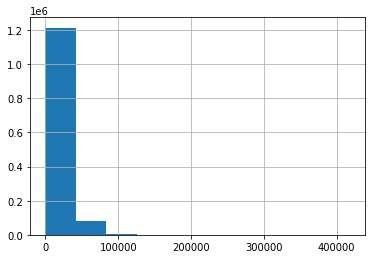


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_APPLICATION
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
For how much credit did client ask on the previous application 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
2030495    17145.00
2802425   607500.00
2523466   112500.00
2819243   450000.00
1784265   337500.00
Name: AMT_APPLICATION, dtype: float64

COLUMN STATISTICS:
count   1670214.00
mean     175233.86
std      292779.76
min           0.00
25%       18720.00
50%       71046.00
75%      180360.00
max     6905160.00
Name: AMT_APPLICATION, dtype: float64

Number of zeros:
392402

Number of NaN in column:
0


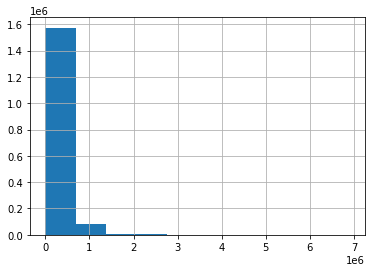


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_CREDIT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received different amount - AMT_CREDIT 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
2030495    17145.00
2802425   679671.00
2523466   136444.50
2819243   470790.00
1784265   404055.00
Name: AMT_CREDIT, dtype: float64

COLUMN STATISTICS:
count   1670213.00
mean     196114.02
std      318574.62
min           0.00
25%       24160.50
50%       80541.00
75%      216418.50
max     6905160.00
Name: AMT_CREDIT, dtype: float64

Number of zeros:
336768

Number of NaN in column:
1


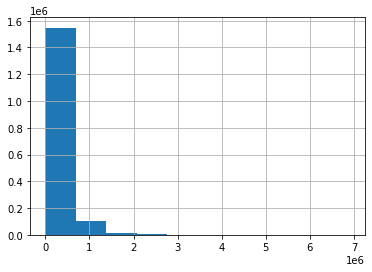

In [116]:
# View statistics about float64 columns
dataframe_analysis(previous, "float64", table_name="previous_application.csv")

#### <b> EDA for *int64* columns


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: SK_ID_PREV
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did not find description for this column
TOP 5 ROWS:
2030495    2030495
2802425    2802425
2523466    2523466
2819243    2819243
1784265    1784265
Name: SK_ID_PREV, dtype: int64

COLUMN STATISTICS:
count   1670214.00
mean    1923089.14
std      532597.96
min     1000001.00
25%     1461857.25
50%     1923110.50
75%     2384279.75
max     2845382.00
Name: SK_ID_PREV, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


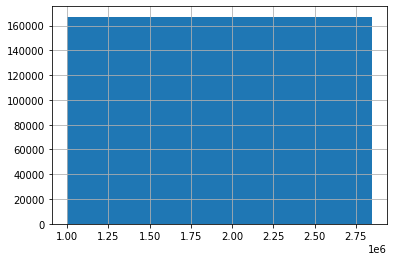


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: SK_ID_CURR
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
ID of loan in our sample 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
2030495    271877
2802425    108129
2523466    122040
2819243    176158
1784265    202054
Name: SK_ID_CURR, dtype: int64

COLUMN STATISTICS:
count   1670214.00
mean     278357.17
std      102814.82
min      100001.00
25%      189329.00
50%      278714.50
75%      367514.00
max      456255.00
Name: SK_ID_CURR, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


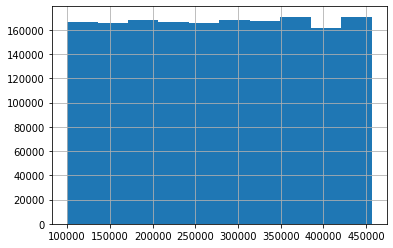


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: HOUR_APPR_PROCESS_START
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Approximately at what day hour did the client apply for the previous application 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
2030495    15
2802425    11
2523466    11
2819243     7
1784265     9
Name: HOUR_APPR_PROCESS_START, dtype: int64

COLUMN STATISTICS:
count   1670214.00
mean         12.48
std           3.33
min           0.00
25%          10.00
50%          12.00
75%          15.00
max          23.00
Name: HOUR_APPR_PROCESS_START, dtype: float64

Number of zeros:
109

Number of NaN in column:
0


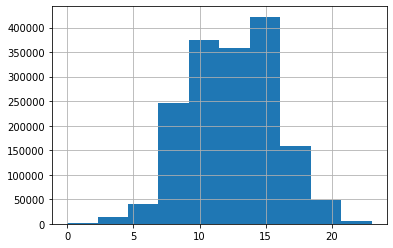

In [117]:
# View statistics about int64 columns
dataframe_analysis(previous, "int64", table_name="previous_application.csv")

#### <b> EDA for *object (string)* columns

In [118]:
# View statistics about object columns
dataframe_analysis(previous, "object", table_name="previous_application.csv")

### <b>installments_payments.csv

In [119]:
# View shape of file
installments.shape

(13605401, 9)

In [120]:
# View first 5 rows
installments.head()

,installments_index,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,0,1054186,161674,1.00,6,-1180.00,-1187.00,6948.36,6948.36
1,1,1330831,151639,0.00,34,-2156.00,-2156.00,1716.53,1716.53
2,2,2085231,193053,2.00,1,-63.00,-63.00,25425.00,25425.00
3,3,2452527,199697,1.00,3,-2418.00,-2426.00,24350.13,24350.13
4,4,2714724,167756,1.00,2,-1383.00,-1366.00,2165.04,2160.59


In [121]:
# View last 5 rows
installments.tail()

,installments_index,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
13605396,13605396,2186857,428057,0.00,66,-1624.00,NaN,67.50,NaN
13605397,13605397,1310347,414406,0.00,47,-1539.00,NaN,67.50,NaN
13605398,13605398,1308766,402199,0.00,43,-7.00,NaN,43737.43,NaN
13605399,13605399,1062206,409297,0.00,43,-1986.00,NaN,67.50,NaN
13605400,13605400,2448869,434321,1.00,19,-27.00,NaN,11504.25,NaN


In [122]:
# View dataframe statistics
installments.describe()

,installments_index,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,13605401.00,13605401.00,13605401.00,13605401.00,13605401.00,13605401.00,13602496.00,13605401.00,13602496.00
mean,6802700.00,1903364.97,278444.88,0.86,18.87,-1042.27,-1051.11,17050.91,17238.22
std,3927541.11,536202.91,102718.31,1.04,26.66,800.95,800.59,50570.25,54735.78
min,0.00,1000001.00,100001.00,0.00,1.00,-2922.00,-4921.00,0.00,0.00
25%,3401350.00,1434191.00,189639.00,0.00,4.00,-1654.00,-1662.00,4226.09,3398.26
50%,6802700.00,1896520.00,278685.00,1.00,8.00,-818.00,-827.00,8884.08,8125.52
75%,10204050.00,2369094.00,367530.00,1.00,19.00,-361.00,-370.00,16710.21,16108.42
max,13605400.00,2843499.00,456255.00,178.00,277.00,-1.00,-1.00,3771487.85,3771487.85


In [123]:
# View columns datatypes
installments.dtypes.value_counts()

float64    5
int64      4
dtype: int64

#### <b> EDA for *float64* columns


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: NUM_INSTALMENT_VERSION
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0   1.00
1   0.00
2   2.00
3   1.00
4   1.00
Name: NUM_INSTALMENT_VERSION, dtype: float64

COLUMN STATISTICS:
count   13605401.00
mean           0.86
std            1.04
min            0.00
25%            0.00
50%            1.00
75%            1.00
max          178.00
Name: NUM_INSTALMENT_VERSION, dtype: float64

Number of zeros:
4082498

Number of NaN in column:
0


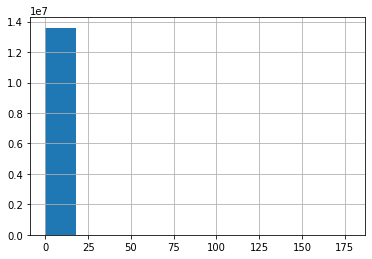


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: DAYS_INSTALMENT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
When the installment of previous credit was supposed to be paid (relative to application date of current loan) 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0   -1180.00
1   -2156.00
2     -63.00
3   -2418.00
4   -1383.00
Name: DAYS_INSTALMENT, dtype: float64

COLUMN STATISTICS:
count   13605401.00
mean       -1042.27
std          800.95
min        -2922.00
25%        -1654.00
50%         -818.00
75%         -361.00
max           -1.00
Name: DAYS_INSTALMENT, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


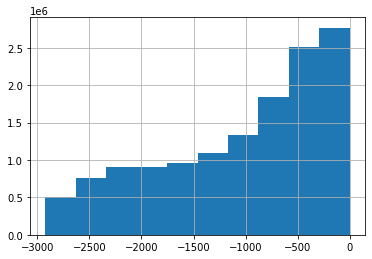


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: DAYS_ENTRY_PAYMENT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
When was the installments of previous credit paid actually (relative to application date of current loan) 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0   -1187.00
1   -2156.00
2     -63.00
3   -2426.00
4   -1366.00
Name: DAYS_ENTRY_PAYMENT, dtype: float64

COLUMN STATISTICS:
count   13602496.00
mean       -1051.11
std          800.59
min        -4921.00
25%        -1662.00
50%         -827.00
75%         -370.00
max           -1.00
Name: DAYS_ENTRY_PAYMENT, dtype: float64

Number of zeros:
0

Number of NaN in column:
2905


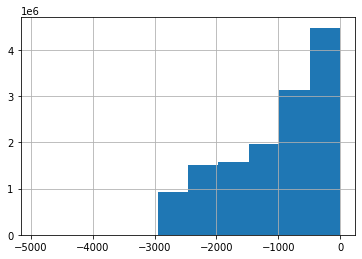

In [124]:
# View statistics about float64 columns
dataframe_analysis(installments, "float64", table_name="installments_payments.csv")

#### <b> EDA for *int64* columns


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: installments_index
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did not find description for this column
TOP 5 ROWS:
0    0
1    1
2    2
3    3
4    4
Name: installments_index, dtype: int64

COLUMN STATISTICS:
count   13605401.00
mean     6802700.00
std      3927541.11
min            0.00
25%      3401350.00
50%      6802700.00
75%     10204050.00
max     13605400.00
Name: installments_index, dtype: float64

Number of zeros:
1

Number of NaN in column:
0


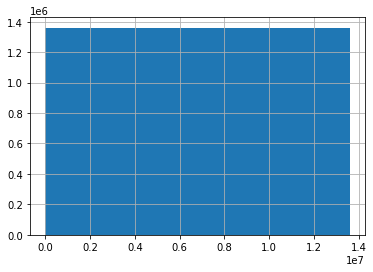


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: SK_ID_PREV
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did not find description for this column
TOP 5 ROWS:
0    1054186
1    1330831
2    2085231
3    2452527
4    2714724
Name: SK_ID_PREV, dtype: int64

COLUMN STATISTICS:
count   13605401.00
mean     1903364.97
std       536202.91
min      1000001.00
25%      1434191.00
50%      1896520.00
75%      2369094.00
max      2843499.00
Name: SK_ID_PREV, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


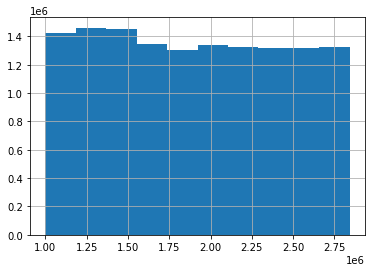


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: SK_ID_CURR
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
ID of loan in our sample 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    161674
1    151639
2    193053
3    199697
4    167756
Name: SK_ID_CURR, dtype: int64

COLUMN STATISTICS:
count   13605401.00
mean      278444.88
std       102718.31
min       100001.00
25%       189639.00
50%       278685.00
75%       367530.00
max       456255.00
Name: SK_ID_CURR, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


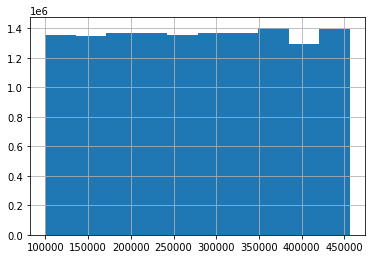

In [125]:
# View statistics about int64 columns
dataframe_analysis(installments, "int64", table_name="installments_payments.csv")

#### <b> EDA for *object (string)* columns

In [126]:
# View statistics about object columns
dataframe_analysis(installments, "object", table_name="installments_payments.csv")

## <b>Feature creation

For feature creation I will use ***Featuretools*** which is an open-source Python library for automatically creating features out of a set of related tables.

In [127]:
# Entity set
es = ft.EntitySet(id="client")

In [128]:
# Add dataframes to the entity set
es = es.add_dataframe(dataframe_name="applications", 
                      dataframe=app, 
                      index="SK_ID_CURR")
es = es.add_dataframe(dataframe_name="bureau", 
                      dataframe=bureau, 
                      index="SK_ID_BUREAU")
es = es.add_dataframe(dataframe_name="previous",
                      dataframe=previous,
                      index="SK_ID_PREV")

# Entities that do not have a unique index
es = es.add_dataframe(dataframe_name="bureau_balance", 
                      dataframe=bureau_balance, 
                      make_index=True,
                      index="bureau_balance_index")
es = es.add_dataframe(dataframe_name="credit",
                      dataframe=credit,
                      make_index=True,
                      index="credit_index")
es = es.add_dataframe(dataframe_name="cash",
                      dataframe=cash,
                      make_index=True,
                      index="cash_index")
es = es.add_dataframe(dataframe_name="installments",
                      dataframe=installments,
                      make_index=True,
                      index="installments_index")

In [129]:
# Add relationships
es = es.add_relationships([
    ("applications", "SK_ID_CURR", "bureau", "SK_ID_CURR"),
    ("applications", "SK_ID_CURR", "previous", "SK_ID_CURR"),
    ("bureau", "SK_ID_BUREAU", "bureau_balance", "SK_ID_BUREAU"),
    ("previous", "SK_ID_PREV", "installments", "SK_ID_PREV"),
    ("previous", "SK_ID_PREV", "credit", "SK_ID_PREV"),
    ("previous", "SK_ID_PREV", "cash", "SK_ID_PREV")
])

In [130]:
es

Entityset: client
  DataFrames:
    applications [Rows: 307511, Columns: 121]
    bureau [Rows: 1716428, Columns: 17]
    previous [Rows: 1670214, Columns: 37]
    bureau_balance [Rows: 27299925, Columns: 4]
    credit [Rows: 3840312, Columns: 24]
    cash [Rows: 10001358, Columns: 9]
    installments [Rows: 13605401, Columns: 9]
  Relationships:
    bureau.SK_ID_CURR -> applications.SK_ID_CURR
    previous.SK_ID_CURR -> applications.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    installments.SK_ID_PREV -> previous.SK_ID_PREV
    credit.SK_ID_PREV -> previous.SK_ID_PREV
    cash.SK_ID_PREV -> previous.SK_ID_PREV

In [131]:
# View aggregation primitives
primitives = ft.primitives.list_primitives()
print("Aggregation type primitives:")
primitives[primitives['type'] == 'aggregation'].drop(["type"], axis=1)

Aggregation type primitives:


,name,dask_compatible,spark_compatible,description,valid_inputs,return_type
0,time_since_last,False,False,Calculates the time elapsed since the last dat...,<ColumnSchema (Logical Type = Datetime) (Seman...,None
1,mode,False,False,Determines the most commonly repeated value.,<ColumnSchema (Semantic Tags = ['category'])>,None
2,median,False,False,Determines the middlemost number in a list of ...,<ColumnSchema (Semantic Tags = ['numeric'])>,None
3,time_since_first,False,False,Calculates the time elapsed since the first da...,<ColumnSchema (Logical Type = Datetime) (Seman...,None
4,skew,False,False,Computes the extent to which a distribution di...,<ColumnSchema (Semantic Tags = ['numeric'])>,None
5,first,False,False,Determines the first value in a list.,<ColumnSchema>,None
6,entropy,False,False,Calculates the entropy for a categorical column,<ColumnSchema (Semantic Tags = ['category'])>,None
7,sum,True,True,"Calculates the total addition, ignoring `NaN`.",<ColumnSchema (Semantic Tags = ['numeric'])>,None
8,max,True,True,"Calculates the highest value, ignoring `NaN` v...",<ColumnSchema (Semantic Tags = ['numeric'])>,None
9,trend,False,False,Calculates the trend of a column over time.,<ColumnSchema (Logical Type = Datetime) (Seman...,None


In [132]:
# View transformation primitives
print("Transform type primitives:")
primitives[primitives['type'] == 'transform'].drop(["type"], axis=1)

Transform type primitives:


,name,dask_compatible,spark_compatible,description,valid_inputs,return_type
22,longitude,False,False,Returns the second tuple value in a list of La...,<ColumnSchema (Logical Type = LatLong)>,None
23,cum_mean,False,False,Calculates the cumulative mean.,<ColumnSchema (Semantic Tags = ['numeric'])>,None
24,tangent,True,True,Computes the tangent of a number.,<ColumnSchema (Semantic Tags = ['numeric'])>,None
25,hour,True,True,Determines the hour value of a datetime.,<ColumnSchema (Logical Type = Datetime)>,None
26,divide_numeric,True,True,Element-wise division of two lists.,<ColumnSchema (Semantic Tags = ['numeric'])>,None
27,rolling_count,False,False,Determines a rolling count of events over a gi...,<ColumnSchema (Logical Type = Datetime) (Seman...,None
28,time_since_previous,False,False,Compute the time since the previous entry in a...,<ColumnSchema (Logical Type = Datetime) (Seman...,None
29,less_than_equal_to,True,True,Determines if values in one list are less than...,"<ColumnSchema (Logical Type = Ordinal: None)>,...",None
30,sine,True,True,Computes the sine of a number.,<ColumnSchema (Semantic Tags = ['numeric'])>,None
31,latitude,False,False,Returns the first tuple value in a list of Lat...,<ColumnSchema (Logical Type = LatLong)>,None


## <b>Deep Feature Synthesis with default primitives

In [117]:
# Primitive to be used
aggregation_primitives = ["min", "count", "max", "std", "mean"]
transform_primitives = ["percentile"]

In [118]:
# Generate feature names 
t0 = time()
features_name = ft.dfs(entityset=es, 
                       target_dataframe_name="applications",
                       trans_primitives=transform_primitives,
                       agg_primitives=aggregation_primitives, 
                       max_depth=2,
                       features_only=True)
print(f"It took {(time()-t0):.0f} seconds")
print(f"Number of features created is {len(features_name)}")

It took 0 seconds
Number of features created is 1635


In [119]:
# Generate feature matrix
t0 = time()
feature_matrix, features_name = ft.dfs(entityset=es, 
                       target_dataframe_name="applications",
                       trans_primitives=transform_primitives,
                       agg_primitives=aggregation_primitives, 
                       max_depth=2,
                       features_only=False,
                       verbose=True)

Built 1635 features
Elapsed: 11:35 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [120]:
feature_matrix.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,PERCENTILE(STD(cash.SK_DPD)),PERCENTILE(STD(cash.SK_DPD_DEF)),PERCENTILE(STD(cash.SK_ID_CURR)),PERCENTILE(STD(credit.AMT_BALANCE)),PERCENTILE(STD(credit.AMT_CREDIT_LIMIT_ACTUAL)),PERCENTILE(STD(credit.AMT_DRAWINGS_ATM_CURRENT)),PERCENTILE(STD(credit.AMT_DRAWINGS_CURRENT)),PERCENTILE(STD(credit.AMT_DRAWINGS_OTHER_CURRENT)),PERCENTILE(STD(credit.AMT_DRAWINGS_POS_CURRENT)),PERCENTILE(STD(credit.AMT_INST_MIN_REGULARITY)),PERCENTILE(STD(credit.AMT_PAYMENT_CURRENT)),PERCENTILE(STD(credit.AMT_PAYMENT_TOTAL_CURRENT)),PERCENTILE(STD(credit.AMT_RECEIVABLE_PRINCIPAL)),PERCENTILE(STD(credit.AMT_RECIVABLE)),PERCENTILE(STD(credit.AMT_TOTAL_RECEIVABLE)),PERCENTILE(STD(credit.CNT_DRAWINGS_ATM_CURRENT)),PERCENTILE(STD(credit.CNT_DRAWINGS_CURRENT)),PERCENTILE(STD(credit.CNT_DRAWINGS_OTHER_CURRENT)),PERCENTILE(STD(credit.CNT_DRAWINGS_POS_CURRENT)),PERCENTILE(STD(credit.CNT_INSTALMENT_MATURE_CUM)),PERCENTILE(STD(credit.MONTHS_BALANCE)),PERCENTILE(STD(credit.SK_DPD)),PERCENTILE(STD(credit.SK_DPD_DEF)),PERCENTILE(STD(credit.SK_ID_CURR)),PERCENTILE(STD(installments.AMT_INSTALMENT)),PERCENTILE(STD(installments.AMT_PAYMENT)),PERCENTILE(STD(installments.DAYS_ENTRY_PAYMENT)),PERCENTILE(STD(installments.DAYS_INSTALMENT)),PERCENTILE(STD(installments.NUM_INSTALMENT_NUMBER)),PERCENTILE(STD(installments.NUM_INSTALMENT_VERSION)),PERCENTILE(STD(installments.SK_ID_CURR)),PERCENTILE(STD(previous.AMT_ANNUITY)),PERCENTILE(STD(previous.AMT_APPLICATION)),PERCENTILE(STD(previous.AMT_CREDIT)),PERCENTILE(STD(previous.AMT_DOWN_PAYMENT)),PERCENTILE(STD(previous.AMT_GOODS_PRICE)),PERCENTILE(STD(previous.CNT_PAYMENT)),PERCENTILE(STD(previous.DAYS_DECISION)),PERCENTILE(STD(previous.DAYS_FIRST_DRAWING)),PERCENTILE(STD(previous.DAYS_FIRST_DUE)),PERCENTILE(STD(previous.DAYS_LAST_DUE)),PERCENTILE(STD(previous.DAYS_LAST_DUE_1ST_VERSION)),PERCENTILE(STD(previous.DAYS_TERMINATION)),PERCENTILE(STD(previous.HOUR_APPR_PROCESS_START)),PERCENTILE(STD(previous.NFLAG_INSURED_ON_APPROVAL)),PERCENTILE(STD(previous.NFLAG_LAST_APPL_IN_DAY)),PERCENTILE(STD(previous.RATE_DOWN_PAYMENT)),PERCENTILE(STD(previous.RATE_INTEREST_PRIMARY)),PERCENTILE(STD(previous.RATE_INTEREST_PRIVILEGED)),PERCENTILE(STD(previous.SELLERPLACE_AREA))
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,Cash loans,M,N,Y,0,202500.00,406597.50,24700.50,351000.00,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.02,-9461,-637,-3648.00,-2120,NaN,1,1,0,1,1,0,Laborers,1.00,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,...,0.41,0.43,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.56,0.55,0.35,0.35,0.73,0.44,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,Cash loans,F,N,N,0,270000.00,1293502.50,35698.50,1129500.00,Family,State servant,Higher education,Married,House / apartment,0.00,-16765,-1188,-1186.00,-291,NaN,1,1,0,1,1,0,Core staff,2.00,1,1,MONDAY,11,0,0,0,0,0,0,School,0.31,0.62,NaN,0.10,0.05,0.99,0.80,0.06,0.08,0.03

In [121]:
feature_matrix.to_csv("./data/ft_1635_columns", index=False)
print("Successfuly saved to disk")

Successfuly saved to disk


## <b>Test performance after feature creation:

In [4]:
# Load data
feature_matrix = pd.read_csv("./data/ft_1635_columns.csv")
labels = pd.read_csv("./data/applications.csv").TARGET

In [5]:
# OneHot Encoding
feature_matrix = pd.get_dummies(feature_matrix)

# Rename columns according to LGBMClassifier requirments
feature_matrix = feature_matrix.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [6]:
labels = pd.read_csv("./data/applications.csv").TARGET

In [7]:
# There are some errors with datatype in the feature_matrix dataframe
# Will change all columns datatype to float64. Not 
# Not the most efficient solution from memory standpoint but certainly fast and effective.
feature_matrix = feature_matrix.astype("float64")
feature_matrix.dtypes.unique()

In [9]:
# Train/test split
x_train, x_test, y_train, y_test = train_test_split(feature_matrix,
                                                    labels,
                                                    random_state=1,
                                                    test_size=0.1,
                                                    stratify=labels)
                                                    
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((276759, 1759), (30752, 1759), (276759,), (30752,))

In [10]:
scaler = StandardScaler()
scaler = scaler.fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train), columns=feature_matrix.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=feature_matrix.columns)

In [11]:
for col in x_train.columns:
    col_mean = x_train[col].mean()
    x_train[col] = x_train[col].fillna(col_mean)
    x_test[col] = x_test[col].fillna(col_mean)

In [26]:
# Split in train and validation datasets. 
# Will do hold-out validation for faster training
# This will not affect final performance
x_t, x_v, y_t, y_v = train_test_split(x_train, 
                                      y_train, 
                                      random_state=1,
                                      test_size=0.2, 
                                      stratify=y_train)
model = LGBMClassifier(random_state=1)
model = model.fit(X=x_t, 
                  y=y_t, 
                  eval_metric="auc",
                  eval_set=[(x_t, y_t), (x_v, y_v)],
                  eval_names=["train", "validation"],
                  early_stopping_rounds=100,
                  verbose=0)
print(f"On {len(x_t.columns)} features the model scored: {model.best_score_['validation']['auc']}")

On 1759 features the model scored: 0.7739042440484816


0.7739 is much better than previous score of 0.7550

<a id=7></a><div style="padding:15px;color:white;margin:0;font-size:200%;text-align:center;display:fill;border-radius:5px;background-color:#00afb9;overflow:hidden;font-weight:500">7. Feature Selection</div>

[go on top ↑](#0)

## <b>Drop zero imporance features

In [27]:
x_t.shape, x_v.shape, y_t.shape, y_v.shape

((221407, 1759), (55352, 1759), (221407,), (55352,))

In [28]:
# Count number of zero importance features
zero_importance =[]
for i in range(len(model.feature_importances_)):
    if model.feature_importances_[i] == 0:
        zero_importance.append(model.feature_name_[i])
len(zero_importance)

982

In [29]:
# Drop zero importance features
x_t.drop(zero_importance, axis=1, inplace=True)
x_v.drop(zero_importance, axis=1, inplace=True)

In [30]:
x_t.shape, x_v.shape, y_t.shape, y_v.shape

((221407, 777), (55352, 777), (221407,), (55352,))

## Drop till 50 features

Iteratively, will train the model and will drop 3 least important features till 
I will get to 50 features

In [31]:
all_valid_auc = []
train_columns = dict()

t0 = time()
while len(x_t.columns)>50:
    model = LGBMClassifier(random_state=1, n_jobs=10)
    model = model.fit(X=x_t, 
                      y=y_t, 
                      eval_metric="auc",
                      eval_set=[(x_t, y_t), (x_v, y_v)],
                      eval_names=["train", "validation"],
                      early_stopping_rounds=100,
                      verbose=0)
    all_valid_auc.append(model.best_score_['validation']['auc'])
    
    feateure_importance = pd.DataFrame(model.feature_importances_, index=model.feature_name_)
    feateure_importance.sort_values(ascending=True, by=0, inplace=True)
    
    # Drop 3 least important columns
    for i in range(0, 4):
        x_t.drop(feateure_importance.index[i], axis=1, inplace=True)
        x_v.drop(feateure_importance.index[i], axis=1, inplace=True)    
        
    train_columns[len(x_t.columns)] = x_t.columns
    
print(f"Training took {(time()-t0):.0f} seconds")

Training took 1807 seconds


Text(0, 0.5, 'AUC on validation data')

Text(0.5, 0, 'Number of features used by algorithm')

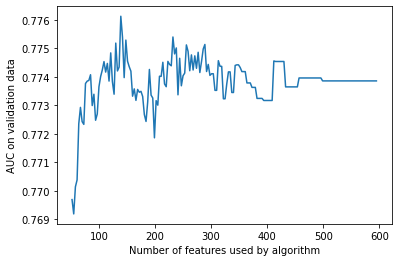

In [32]:
# Plot data
n_removed_features = np.arange((len(all_valid_auc)*3)+len(x_t.columns), len(x_t.columns), -3)
plt.plot(n_removed_features, all_valid_auc)
plt.ylabel("AUC on validation data")
plt.xlabel("Number of features used by algorithm")
plt.show()

In [51]:
# I will choose 145 features because it will provide best performance/efficiency
x_train_145_features = x_train[train_columns[145]]
x_test_145_features = x_test[train_columns[145]]
x_train_145_features.shape, x_test_145_features.shape

((276759, 145), (30752, 145))

In [53]:
# Test performance on 125 features
x_t, x_v, y_t, y_v = train_test_split(x_train_145_features, 
                                      y_train, 
                                      random_state=1,
                                      test_size=0.2, 
                                      stratify=y_train)
model = LGBMClassifier(random_state=1)
model = model.fit(X=x_t, 
                  y=y_t, 
                  eval_metric="auc",
                  eval_set=[(x_t, y_t), (x_v, y_v)],
                  eval_names=["train", "validation"],
                  early_stopping_rounds=100,
                  verbose=0)
print(f"On {len(x_t.columns)} features the model scored: {model.best_score_['validation']['auc']}")

On 145 features the model scored: 0.7748425210232948


We have decreased number of features from 1759 to 145 and the AUC has increased from 0.7739 to 0.7748.
This will result in better predictions and faster training/inference time.

In [60]:
# Safe to disk:
x_train_145_features.to_csv("./data/x_train_145_features.csv", index=False)
x_test_145_features.to_csv("./data/x_test_145_features.csv", index=False)
y_train.to_csv("./data/y_train_145_features.csv", index=False)
y_test.to_csv("./data/y_test_145_features.csv", index=False)

<a id=8></a><div style="padding:15px;color:white;margin:0;font-size:200%;text-align:center;display:fill;border-radius:5px;background-color:#bc4b51;overflow:hidden;font-weight:500"><b>8. PCA - Dimensionality Reduction</div>

[go on top ↑](#0)

Lets try PCA and see how it will affect performance of algrithm.

## PCA before removing 0 importance features

In [69]:
# Remove columns with NaN
nan_columns = []
for col in x_train.columns:
    if x_train[col].isna().sum()>0:
        nan_columns.append(col)
x_train.drop(nan_columns, axis=1, inplace=True)

In [70]:
# Try PCA with 0.99 variance to be kept
pca = PCA(0.99)
x_train_pca = pca.fit_transform(x_train)

In [73]:
# Number of remaining features
len(x_train_pca[1])

524

In [77]:
# Check algorithm accuracy
x_t, x_v, y_t, y_v = train_test_split(x_train_pca, 
                                      y_train, 
                                      random_state=1,
                                      test_size=0.2, 
                                      stratify=y_train)
model = LGBMClassifier(random_state=1, n_jobs=10)
model = model.fit(X=x_t,
                  y=y_t, 
                  eval_metric="auc",
                  eval_set=[(x_t, y_t), (x_v, y_v)],
                  eval_names=["train", "validation"],
                  early_stopping_rounds=100,
                  verbose=0)
print(f"On {len(x_t[1])} features after PCA(0.99) the model scored: {model.best_score_['validation']['auc']}")

On 524 features after PCA(0.99) the model scored: 0.7472551449724291


Notice a performance decrease from prior feature selection (i.e. 0.7748)

## <b>PCA (drop zero importance variables)

Train algorithm on all 1700 features, drop the ones that have zero importance, then perform PCA

In [78]:
# Split data
x_t, x_v, y_t, y_v = train_test_split(x_train, 
                                      y_train, 
                                      random_state=1,
                                      test_size=0.2, 
                                      stratify=y_train)
x_t.shape, x_v.shape, y_t.shape, y_v.shape

((221407, 1751), (55352, 1751), (221407,), (55352,))

In [80]:
# Initial training to get feature importance
model = LGBMClassifier(random_state=1)
model = model.fit(X=x_t, 
                  y=y_t, 
                  eval_metric="auc",
                  eval_set=[(x_t, y_t), (x_v, y_v)],
                  eval_names=["train", "validation"],
                  early_stopping_rounds=100,
                  verbose=0)

# Count number of zero importance features
zero_importance =[]
for i in range(len(model.feature_importances_)):
    if model.feature_importances_[i] == 0:
        zero_importance.append(model.feature_name_[i])
print(f"There are {len(zero_importance)} features with zero importance")

# Drop zero importance features
x_t.drop(zero_importance, axis=1, inplace=True)
x_v.drop(zero_importance, axis=1, inplace=True)

There are 974 features with zero importance


In [82]:
# Print shape after dropping features with zero importance
x_t.shape, x_v.shape, y_t.shape, y_v.shape

((221407, 777), (55352, 777), (221407,), (55352,))

In [83]:
# PCA 
pca = PCA(0.99).fit(x_t)
x_t_pca = pca.transform(x_t)
x_v_pca = pca.transform(x_v)
x_t_pca.shape, x_v_pca.shape

((221407, 336), (55352, 336))

In [86]:
# Try AUC score with PCA and dropped zero importance features
model = LGBMClassifier(random_state=1)
model = model.fit(X=x_t_pca, 
                  y=y_t, 
                  eval_metric="auc",
                  eval_set=[(x_t_pca, y_t), (x_v_pca, y_v)],
                  eval_names=["train", "validation"],
                  early_stopping_rounds=100,
                  verbose=0)
print(f"On {len(x_t_pca[1])} features the model scored: {model.best_score_['validation']['auc']}")

On 336 features the model scored: 0.7499692060309273


Removing zero-importance features before PCA resulted in a slight increase in performance compared to PCA on all features (AUC =  0.7472), but it is still well below performance of simple feature selection  (i.e. 0.7748)

<a id=9></a><div style="padding:15px;color:white;margin:0;font-size:200%;text-align:center;display:fill;border-radius:5px;background-color:#9a031e;overflow:hidden;font-weight:500"><b>9. Hyperparameter Tunning</b></div>

[go on top ↑](#0)

In [88]:
# Split data
x_t, x_v, y_t, y_v = train_test_split(x_train_145_features, 
                                      y_train, 
                                      random_state=1,
                                      test_size=0.2, 
                                      stratify=y_train)

In [89]:
# Hyperparameter tunning with optuna

def objective(trial):
    params = {
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "n_estimators": trial.suggest_int("n_estimators", 8, 2048),
        "max_depth":  trial.suggest_int("max_depth", 2, 256),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1),
    }
    
    model = LGBMClassifier(**params, random_state=1, n_jobs=10)
    model = model.fit(X=x_t, 
                      y=y_t, 
                      eval_metric="auc",
                      eval_set=[(x_t, y_t), (x_v, y_v)],
                      eval_names=["train", "validation"],
                      early_stopping_rounds=100,
                      verbose=0)
    return model.best_score_['validation']['auc']

optuna.logging.set_verbosity(0)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=256)

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value: 0.7809127904239439
  Params: 
    lambda_l1: 3.286140772628291e-06
    lambda_l2: 6.563020721989631e-06
    num_leaves: 21
    feature_fraction: 0.5146629043698071
    bagging_fraction: 0.6438235921042906
    bagging_freq: 2
    min_child_samples: 91
    n_estimators: 1435
    max_depth: 57
    learning_rate: 0.01839560050173244


In [90]:
hyperparameter_importange = optuna.importance.get_param_importances(study)

In [91]:
hyperparameter_importange

OrderedDict([('learning_rate', 0.9565289438541278),
             ('num_leaves', 0.017835663026582356),
             ('feature_fraction', 0.010577490718783202),
             ('min_child_samples', 0.006763687663353062),
             ('max_depth', 0.003970944849042695),
             ('n_estimators', 0.0026129248233443814),
             ('bagging_fraction', 0.0009990703133264868),
             ('bagging_freq', 0.000686250185585807),
             ('lambda_l2', 2.2001548740790435e-05),
             ('lambda_l1', 3.023017113416916e-06)])

<a id=10></a><div style="padding:15px;color:white;margin:0;font-size:200%;text-align:center;display:fill;border-radius:5px;background-color:#4c5c68;overflow:hidden;font-weight:500"><b>10. Final testing</b></div>

[go on top ↑](#0)

In [96]:
params = trial.params

In [98]:
model = LGBMClassifier(**params, random_state=1, n_jobs=10)
model = model.fit(X=x_train_145_features, 
                  y=y_train, 
                  eval_metric="auc",
                  eval_set=[(x_train_145_features, y_train), (x_test_145_features, y_test)],
                  eval_names=["train", "test"],
                  early_stopping_rounds=100,
                  verbose=0)
print(f"Model performance on test data: {model.best_score_['test']['auc']}")

Model performance on test data: 0.790634099559626


Final performance is slightly increased from 0.7748 to 0.7906 due to the fact that the model was trained on all training data, with no holdout for validation.